## Notebook that calculates polynya area from visible imagery
Uses effective MODIS pixel dimension that varies depending on zenith view angles (i.e., scene-dependent). Sensitivity analysis included where each polynya category (total, west, east, etc.) also has an upper and lower bound (e.g., utotal, ltotal) based on thresholds that are +/- 1000 DN from selected DN = 3000 threhsold for polynya delineation. See manuscript for details.
<br>
Run all cells. I write these one at the time because I check all scenes to ensure code is running as desired.
<br>

Elena Savidge
<br>
3 Aug 2023

In [1]:
import matplotlib.pyplot as plt
import cartopy
import xarray as xr
import cmocean
from pyhdf.SD import SD, SDC
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import pyproj
from pyproj import Proj, transform, CRS
from glob import glob
from matplotlib.collections import PatchCollection
from shapely.geometry import Point, Polygon
import geopandas as gpd
import scipy
from scipy import ndimage
from cartopy.geodesic import Geodesic
import datetime

/opt/anaconda3/envs/polyarea/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
# NOTE: need dir to be set up this way for pyproj to work
pyproj.datadir.set_data_dir('/opt/anaconda3/envs/polyarea/share/proj') 

In [9]:
pwd

'/Users/elenasavidge/Documents/Documents - Elena’s MacBook Pro/PhD_Ch2/manuscriptcode_2'

In [10]:
cd ../'polynyatimeseries'

/Users/elenasavidge/Documents/Documents - Elena’s MacBook Pro/PhD_Ch2/polynyatimeseries


In [10]:
# change directory to where satellite imagery is stored
#cd ../'polynyatimeseries'

### Calculate haversine distance in km between lat bounds and lon bouds
#### 1. Define function

In [4]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

#### 2. Plot test image to visualize lat/lon bounds (defined with: llcrnrlat=-75.3;urcrnrlat=-74.55;llcrnrlon=-102.7;urcrnrlon=-100 in second cell)

In [13]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221230/MYD09.A2022364.2300.061.2023001023428.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

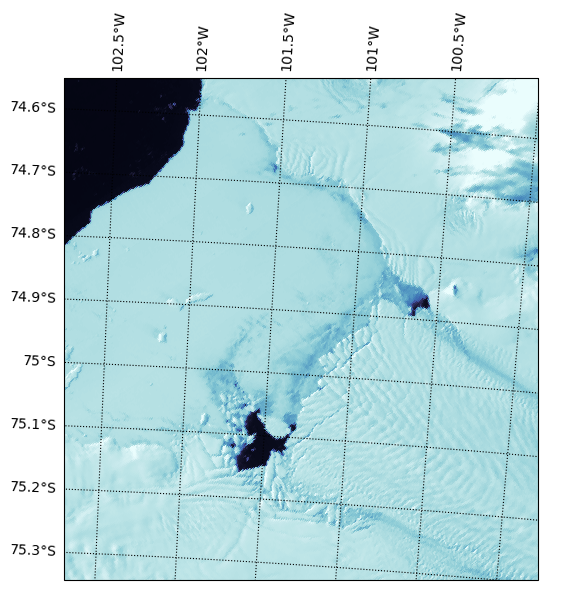

In [7]:
# Plot
llcrnrlat=-75.3;urcrnrlat=-74.55;llcrnrlon=-102.7;urcrnrlon=-100 

fig,ax = plt.subplots(figsize=(6,6)) # give two axes 

plt.axis('off')
m = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-105.0))
m.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
gl = m.gridlines(draw_labels=True,xlocs=[-102.5,-102,-101.5,-101,-100.5,-100],ylocs=[-75.3,-75.2,-75.1,-75,-74.9,-74.8,-74.7,-74.6,-74.5],y_inline=False,color='k',linestyle=':')
gl.bottom_labels = gl.right_labels =  False

data = m.pcolormesh(lon250,lat250,B1,transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice,vmin=0,vmax=10000)
#data = m.pcolormesh(lon,lat,B31,transform=ccrs.PlateCarree(),cmap=cmocean.cm.thermal,vmin=-30,vmax=0)

#cb = plt.colorbar(data,fraction=0.045,pad=0.025,orientation='horizontal')#,shrink=0.84)
#plt.savefig('Dpanel.png', format='png',  bbox_inches="tight",dpi=400)

plt.tight_layout()

## Run through all visible images
### Define 3 required functions

#### Function 1: extracts modis lat, lon, DN and subsets fig (with constrained coordinate bounds) into store xarray

In [11]:
def modis_to_xarray(longitude,latitude,bandvals):
    
    '''Extracts modis lat, lon, B1 and subsets figure into xarray'''
    
    # Convert input data from pandas dataframe to xarray dataArray for easier use and less memory intensive
    data_xr = xr.DataArray(bandvals,dims=["y","x"], coords={"latitude": (["y", "x"],latitude), "longitude": (["y", "x"],longitude)})
    
    # Subset entire modis image to PIG bounds and store output for area calc fct
    figure_bounds = data_xr.where((data_xr.longitude>-102.7)&(data_xr.longitude<-100) & (data_xr.latitude>-75.3)&(data_xr.latitude<-74.55),drop=True)

    #return data_xr
    return figure_bounds

#### Function 2: Calculate effective pixel size to be input into fct 3 call

In [12]:
def effectivepixel(figure_bounds):
    
    '''Calculates effective avg pixel sixe within individual scene'''
    
    # these are image corners, with y positive down, which doesn't really matter
    # for our purposes but can get confusing nonetheless
    upperleft = figure_bounds[0,0]
    upperright = figure_bounds[0,-1]
    lowerleft = figure_bounds[-1,0]
    lowerright = figure_bounds[-1,-1]

    # calculate the length of each side of the image based on the corner coordinates
    top_len = haversine_np(upperleft.longitude.values, upperleft.latitude.values,
                           upperright.longitude.values, upperright.latitude.values)
    bottom_len = haversine_np(lowerleft.longitude.values, lowerleft.latitude.values,
                              lowerright.longitude.values, lowerright.latitude.values)
    left_len = haversine_np(upperleft.longitude.values, upperleft.latitude.values,
                            lowerleft.longitude.values, lowerleft.latitude.values)
    right_len = haversine_np(upperright.longitude.values, upperright.latitude.values,
                             lowerright.longitude.values, lowerright.latitude.values)
    
    # divide through by the number of pixels to get the effective pixel size for each side
    eff_pixel_top = top_len/len(figure_bounds.x)
    eff_pixel_bottom = bottom_len/len(figure_bounds.x)
    eff_pixel_left = left_len/len(figure_bounds.y)
    eff_pixel_right = right_len/len(figure_bounds.y)
    
    # take the mean of the top and bottom sides for the average pixel width
    # and the mean of the left and right sides for the average pixel height
    avgpixelwidth = (eff_pixel_top + eff_pixel_bottom)/2
    avgpixelheight = (eff_pixel_left + eff_pixel_right)/2
    
    return avgpixelwidth,avgpixelheight 

#### Function 3: calculates polynya area by location (west, mid, east, other).

In [13]:
#def polynya_mask(fig_bounds, date, westpoint, midpoint, eastpoint, thresh = None):
def polynya_mask(fig_bounds, westpoint, midpoint, eastpoint, pixelwidth, pixelheight, thresh = None):
    
    '''Calculates polynya area by type (east [e], west [w], mid [m], other [o]) and total [tot].
    This fct is based on radius search area from lat,lon point
    
    This version uses xarray instead of pd.Dataframe to make more efficient'''

    # distance (radius) from point method 
    # convert lat, lon to radians
    # x, y center points polynya
    lat_w = westpoint[0]; lon_w = westpoint[1]; # west polynya center lat, lon
    lat_e = eastpoint[0]; lon_e = eastpoint[1]; #east
    lat_m = midpoint[0]; lon_m = midpoint[1]; # mid

    # convert lats, lons to radians for distance calc
    modislat_rad = np.radians(figure_bounds.latitude)
    modislon_rad = np.radians(figure_bounds.longitude)

    # target points of polynyas (east, west, mid) -- can be approx for now as we'll look in a multiple km search area
    targetlat_rad_e = np.radians(lat_e); targetlon_rad_e = np.radians(lon_e)
    targetlat_rad_w = np.radians(lat_w); targetlon_rad_w = np.radians(lon_w)
    targetlat_rad_m = np.radians(lat_m); targetlon_rad_m = np.radians(lon_m)

    # haversine dist calc, by polynya 
    a_e = np.sin((targetlat_rad_e-modislat_rad)/2.0)**2 + \
        np.cos(modislat_rad) * np.cos(targetlat_rad_e) * np.sin((targetlon_rad_e-modislon_rad)/2.0)**2

    a_w = np.sin((targetlat_rad_w-modislat_rad)/2.0)**2 + \
        np.cos(modislat_rad) * np.cos(targetlat_rad_w) * np.sin((targetlon_rad_w-modislon_rad)/2.0)**2

    a_m = np.sin((targetlat_rad_m-modislat_rad)/2.0)**2 + \
        np.cos(modislat_rad) * np.cos(targetlat_rad_m) * np.sin((targetlon_rad_m-modislon_rad)/2.0)**2

    # calc dist search area in km for each polynya
    earth_radius = 6371 #km
    distkm_e = earth_radius * 2 * np.arcsin(np.sqrt(a_e)) #km
    distkm_w = earth_radius * 2 * np.arcsin(np.sqrt(a_w)) #km
    distkm_m = earth_radius * 2 * np.arcsin(np.sqrt(a_m)) #km

    # will need diff dist thresh for each polynya
    dist_thresh_e = 12 # km
    dist_thresh_w = 12 # km
    dist_thresh_m = 6.5 # km
    east_bounds = figure_bounds.where(distkm_e < dist_thresh_e, drop=True)
    west_bounds = figure_bounds.where(distkm_w < dist_thresh_w, drop=True)
    middle_bounds = figure_bounds.where(distkm_m < dist_thresh_m, drop=True)

    # ADD ERROR HERE
    # Define DN threshold and modis pixel size for optical imagery
    thresh = thresh; 
    u_thresh = thresh + 1000
    l_thresh = thresh - 1000
    pixelarea = pixelwidth*pixelheight; # in km2

    # Create polynya mask for each type based on threshold
    mask_w = west_bounds.where(west_bounds<=thresh)
    mask_e = east_bounds.where(east_bounds<=thresh)
    mask_m = middle_bounds.where(middle_bounds<=thresh)
    mask_total = figure_bounds.where(figure_bounds<=thresh)
    
    u_mask_w = west_bounds.where(west_bounds<=u_thresh)
    u_mask_e = east_bounds.where(east_bounds<=u_thresh)
    u_mask_m = middle_bounds.where(middle_bounds<=u_thresh)
    u_mask_total = figure_bounds.where(figure_bounds<=u_thresh)
    
    l_mask_w = west_bounds.where(west_bounds<=l_thresh)
    l_mask_e = east_bounds.where(east_bounds<=l_thresh)
    l_mask_m = middle_bounds.where(middle_bounds<=l_thresh)
    l_mask_total = figure_bounds.where(figure_bounds<=l_thresh)

    # Calculate area (km2) of all polynya types and total area 
    area_w = (mask_w.count()) * pixelarea 
    area_e = (mask_e.count()) * pixelarea 
    area_m = (mask_m.count()) * pixelarea 
    area_tot = (mask_total.count()) * pixelarea # in km2
    
    u_area_w = (u_mask_w.count()) * pixelarea 
    u_area_e = (u_mask_e.count()) * pixelarea 
    u_area_m = (u_mask_m.count()) * pixelarea 
    u_area_tot = (u_mask_total.count()) * pixelarea # in km2
    
    l_area_w = (l_mask_w.count()) * pixelarea 
    l_area_e = (l_mask_e.count()) * pixelarea 
    l_area_m = (l_mask_m.count()) * pixelarea 
    l_area_tot = (l_mask_total.count()) * pixelarea # in km2

    # other = total mask minus all polynya
    area_o = area_tot - (area_w + area_e + area_m) # km2
    
    u_area_o = u_area_tot - (u_area_w + u_area_e + u_area_m) # km2
        
    l_area_o = l_area_tot - (l_area_w + l_area_e + l_area_m) # km2

    # Store all values in horizontal vector and add date (format 'yyyymmdd')
    area = np.array([area_w,area_e,area_m,area_o,area_tot,u_area_w,u_area_e,u_area_m,u_area_o,u_area_tot,l_area_w,
                     l_area_e,l_area_m,l_area_o,l_area_tot,pixelwidth,pixelheight])

    # Create dataframe that stores these vals 
    area_df = pd.DataFrame(area)
    area_df = area_df.T
    area_df.columns = ['west','east', 'mid','other','total','uwest','ueast', 'umid','uother','utotal',
                      'lwest','least', 'lmid','lother','ltotal','pixelwidth','pixelheight']
    return area_df

    # Delete excessive variables
    del modislat_rad,modislon_rad,targetlat_rad_e,targetlat_rad_w,targetlat_rad_m,a_e,a_w,a_m,distkm_e,distkm_w,distkm_m,east_bounds,west_bounds,middle_bounds, \
        mask_w,mask_e,mask_m,mask_total

In [5]:
# #SAME FCT but with fixed pixel dimensions 250 m x 250 m


# #def polynya_mask(fig_bounds, date, westpoint, midpoint, eastpoint, thresh = None):
# def polynya_mask(fig_bounds, westpoint, midpoint, eastpoint, thresh = None):
    
#     '''Calculates polynya area by type (east [e], west [w], mid [m], other [o]) and total [tot].
#     This fct is based on radius search area from lat,lon point
    
#     This version uses xarray instead of pd.Dataframe to make more efficient'''

#     # distance (radius) from point method 
#     # convert lat, lon to radians
#     # x, y center points polynya
#     lat_w = westpoint[0]; lon_w = westpoint[1]; # west polynya center lat, lon
#     lat_e = eastpoint[0]; lon_e = eastpoint[1]; #east
#     lat_m = midpoint[0]; lon_m = midpoint[1]; # mid

#     # convert lats, lons to radians for distance calc
#     modislat_rad = np.radians(figure_bounds.latitude)
#     modislon_rad = np.radians(figure_bounds.longitude)

#     # target points of polynyas (east, west, mid) 
#     targetlat_rad_e = np.radians(lat_e); targetlon_rad_e = np.radians(lon_e)
#     targetlat_rad_w = np.radians(lat_w); targetlon_rad_w = np.radians(lon_w)
#     targetlat_rad_m = np.radians(lat_m); targetlon_rad_m = np.radians(lon_m)

#     # haversine dist calc, by polynya 
#     a_e = np.sin((targetlat_rad_e-modislat_rad)/2.0)**2 + \
#         np.cos(modislat_rad) * np.cos(targetlat_rad_e) * np.sin((targetlon_rad_e-modislon_rad)/2.0)**2

#     a_w = np.sin((targetlat_rad_w-modislat_rad)/2.0)**2 + \
#         np.cos(modislat_rad) * np.cos(targetlat_rad_w) * np.sin((targetlon_rad_w-modislon_rad)/2.0)**2

#     a_m = np.sin((targetlat_rad_m-modislat_rad)/2.0)**2 + \
#         np.cos(modislat_rad) * np.cos(targetlat_rad_m) * np.sin((targetlon_rad_m-modislon_rad)/2.0)**2

#     # calc dist search area in km for each polynya
#     earth_radius = 6371 #km
#     distkm_e = earth_radius * 2 * np.arcsin(np.sqrt(a_e)) #km
#     distkm_w = earth_radius * 2 * np.arcsin(np.sqrt(a_w)) #km
#     distkm_m = earth_radius * 2 * np.arcsin(np.sqrt(a_m)) #km

#     # diff dist thresh for each polynya
#     dist_thresh_e = 12 # km
#     dist_thresh_w = 12 # km
#     dist_thresh_m = 6.5 # km
#     east_bounds = figure_bounds.where(distkm_e < dist_thresh_e, drop=True)
#     west_bounds = figure_bounds.where(distkm_w < dist_thresh_w, drop=True)
#     middle_bounds = figure_bounds.where(distkm_m < dist_thresh_m, drop=True)

#     # ADD ERROR HERE
#     # Define DN threshold and modis pixel size for optical imagery
#     thresh = thresh; 
#     u_thresh = thresh + 1000
#     l_thresh = thresh - 1000
#     pixelarea = 0.25*0.25; # in km2

#     # Create polynya mask for each type based on threshold
#     mask_w = west_bounds.where(west_bounds<=thresh)
#     mask_e = east_bounds.where(east_bounds<=thresh)
#     mask_m = middle_bounds.where(middle_bounds<=thresh)
#     mask_total = figure_bounds.where(figure_bounds<=thresh)
    
#     u_mask_w = west_bounds.where(west_bounds<=u_thresh)
#     u_mask_e = east_bounds.where(east_bounds<=u_thresh)
#     u_mask_m = middle_bounds.where(middle_bounds<=u_thresh)
#     u_mask_total = figure_bounds.where(figure_bounds<=u_thresh)
    
#     l_mask_w = west_bounds.where(west_bounds<=l_thresh)
#     l_mask_e = east_bounds.where(east_bounds<=l_thresh)
#     l_mask_m = middle_bounds.where(middle_bounds<=l_thresh)
#     l_mask_total = figure_bounds.where(figure_bounds<=l_thresh)

#     # Calculate area (km2) of all polynya types and total area 
#     area_w = (mask_w.count()) * pixelarea 
#     area_e = (mask_e.count()) * pixelarea 
#     area_m = (mask_m.count()) * pixelarea 
#     area_tot = (mask_total.count()) * pixelarea # in km2
    
#     u_area_w = (u_mask_w.count()) * pixelarea 
#     u_area_e = (u_mask_e.count()) * pixelarea 
#     u_area_m = (u_mask_m.count()) * pixelarea 
#     u_area_tot = (u_mask_total.count()) * pixelarea # in km2
    
#     l_area_w = (l_mask_w.count()) * pixelarea 
#     l_area_e = (l_mask_e.count()) * pixelarea 
#     l_area_m = (l_mask_m.count()) * pixelarea 
#     l_area_tot = (l_mask_total.count()) * pixelarea # in km2

#     # other = total mask minus all polynya
#     area_o = area_tot - (area_w + area_e + area_m) # km2
    
#     u_area_o = u_area_tot - (u_area_w + u_area_e + u_area_m) # km2
        
#     l_area_o = l_area_tot - (l_area_w + l_area_e + l_area_m) # km2

#     # Store all values in horizontal vector and add date (format 'yyyymmdd')
#     area = np.array([area_w,area_e,area_m,area_o,area_tot,u_area_w,u_area_e,u_area_m,u_area_o,u_area_tot,l_area_w,
#                      l_area_e,l_area_m,l_area_o,l_area_tot])

#     # Create dataframe that stores these vals 
#     area_df = pd.DataFrame(area)
#     area_df = area_df.T
#     area_df.columns = ['west','east', 'mid','other','total','uwest','ueast', 'umid','uother','utotal',
#                       'lwest','least', 'lmid','lother','ltotal']
#     return area_df

#     # Delete excessive variables
#     del modislat_rad,modislon_rad,targetlat_rad_e,targetlat_rad_w,targetlat_rad_m,a_e,a_w,a_m,distkm_e,distkm_w,distkm_m,east_bounds,west_bounds,middle_bounds, \
#         mask_w,mask_e,mask_m,mask_total

## Data/scenes

#### Define search center coords for 2022

In [14]:
# manual selection but the precision of these does not matter too much, because we are looking within multiple km search area of these points
w2022late = [-75.12,-101.46]
w2022 = [-75.155,-101.32]
m2022 = [-75.01, -101.00]
e2022 = [-74.87,-100.66]

## 2022/12/30

In [15]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221230/MYD09.A2022364.2300.061.2023001023428.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [16]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221230 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221230['Date'] = '20221230' # Add date
area_20221230

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,44.414345,4.255267,0.0,360.633846,409.303457,47.605795,4.986641,0.0,361.830639,414.423075,41.621827,3.457404,0.0,358.838655,403.917886,0.266558,0.249434,20221230


In [952]:
# Manual correction to remove open ocean area (e.g., see ex scene above where this is required -- can do so this way b/c here clearly no other polynya open)
oth = np.array(area_20221230['other'])
tot = np.array(area_20221230['total'])
area_20221230['other'] = area_20221230['other'].replace(oth, 0)
area_20221230['total'] = area_20221230['total'].replace(tot, tot-oth)

uoth = np.array(area_20221230['uother'])
utot = np.array(area_20221230['utotal'])
area_20221230['uother'] = area_20221230['uother'].replace(uoth, 0)
area_20221230['utotal'] = area_20221230['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221230['lother'])
ltot = np.array(area_20221230['ltotal'])
area_20221230['lother'] = area_20221230['lother'].replace(loth, 0)
area_20221230['ltotal'] = area_20221230['ltotal'].replace(ltot, ltot-loth)
area_20221230

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,44.414345,4.255267,0.0,0.0,48.669612,47.605795,4.986641,0.0,0.0,52.592436,41.621827,3.457404,0.0,0.0,45.079231,0.266558,0.249434,20221230


## 2022/12/29

In [953]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221229/MYD09.A2022363.2215.061.2022365021637.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [954]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221229 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) # call fct 2
area_20221229['Date'] = '20221229' # Add date
area_20221229

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,43.019046,2.51496,0.0,372.809675,418.343681,47.651867,6.221216,0.0,374.861352,428.734435,37.658211,0.463282,0.0,371.155096,409.276589,0.265989,0.248819,20221229


In [955]:
# Manual correction to remove open oceam area
oth = np.array(area_20221229['other'])
tot = np.array(area_20221229['total'])
area_20221229['other'] = area_20221229['other'].replace(oth, 0)
area_20221229['total'] = area_20221229['total'].replace(tot, tot-oth)

uoth = np.array(area_20221229['uother'])
utot = np.array(area_20221229['utotal'])
area_20221229['uother'] = area_20221229['uother'].replace(uoth, 0)
area_20221229['utotal'] = area_20221229['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221229['lother'])
ltot = np.array(area_20221229['ltotal'])
area_20221229['lother'] = area_20221229['lother'].replace(loth, 0)
area_20221229['ltotal'] = area_20221229['ltotal'].replace(ltot, ltot-loth)
area_20221229

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,43.019046,2.51496,0.0,0.0,45.534006,47.651867,6.221216,0.0,0.0,53.873083,37.658211,0.463282,0.0,0.0,38.121493,0.265989,0.248819,20221229


In [956]:
# # concat into df as we go through scenes
df_concat = pd.concat([area_20221230,area_20221229])
# df_concat

## 2022/12/26

In [957]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221226/MYD09.A2022360.2325.061.2022362113123.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [958]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
#width, height = effectivepixel(figure_bounds.x,figure_bounds.y) # km
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221226 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) # call fct 2
area_20221226['Date'] = '20221226' # Add date
area_20221226

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,45.884412,3.409827,0.0,355.882172,405.176411,48.997733,4.521727,0.0,359.217872,412.737332,42.548712,1.704914,0.0,351.879331,396.132957,0.298797,0.248084,20221226


In [959]:
# Manual correction to remove open oceam area
oth = np.array(area_20221226['other'])
tot = np.array(area_20221226['total'])
area_20221226['other'] = area_20221226['other'].replace(oth, 0)
area_20221226['total'] = area_20221226['total'].replace(tot, tot-oth)

uoth = np.array(area_20221226['uother'])
utot = np.array(area_20221226['utotal'])
area_20221226['uother'] = area_20221226['uother'].replace(uoth, 0)
area_20221226['utotal'] = area_20221226['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221226['lother'])
ltot = np.array(area_20221226['ltotal'])
area_20221226['lother'] = area_20221226['lother'].replace(loth, 0)
area_20221226['ltotal'] = area_20221226['ltotal'].replace(ltot, ltot-loth)
area_20221226

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,45.884412,3.409827,0.0,0.0,49.29424,48.997733,4.521727,0.0,0.0,53.51946,42.548712,1.704914,0.0,0.0,44.253626,0.298797,0.248084,20221226


In [960]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221226])
# df_concat

In [961]:
df_concat

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,44.414345,4.255267,0.0,0.0,48.669612,47.605795,4.986641,0.0,0.0,52.592436,41.621827,3.457404,0.0,0.0,45.079231,0.266558,0.249434,20221230
0,43.019046,2.514960,0.0,0.0,45.534006,47.651867,6.221216,0.0,0.0,53.873083,37.658211,0.463282,0.0,0.0,38.121493,0.265989,0.248819,20221229
0,45.884412,3.409827,0.0,0.0,49.294240,48.997733,4.521727,0.0,0.0,53.519460,42.548712,1.704914,0.0,0.0,44.253626,0.298797,0.248084,20221226


## 2022/12/22

In [962]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221222/MYD09.A2022356.0715.061.2022358025559.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [963]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221222 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) # call fct 2
area_20221222['Date'] = '20221222' # Add date
area_20221222

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,34.486708,5.253503,0.0,390.708138,430.44835,48.722008,8.897062,0.169468,874.538862,932.3274,30.843149,3.558825,0.0,253.947579,288.349554,0.339818,0.249351,20221222


In [964]:
# Manual correction to remove open oceam area
oth = np.array(area_20221222['other'])
tot = np.array(area_20221222['total'])
area_20221222['other'] = area_20221222['other'].replace(oth, 0)
area_20221222['total'] = area_20221222['total'].replace(tot, tot-oth)

uoth = np.array(area_20221222['uother'])
utot = np.array(area_20221222['utotal'])
area_20221222['uother'] = area_20221222['uother'].replace(uoth, 0)
area_20221222['utotal'] = area_20221222['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221222['lother'])
ltot = np.array(area_20221222['ltotal'])
area_20221222['lother'] = area_20221222['lother'].replace(loth, 0)
area_20221222['ltotal'] = area_20221222['ltotal'].replace(ltot, ltot-loth)
area_20221222

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,34.486708,5.253503,0.0,0.0,39.740212,48.722008,8.897062,0.169468,0.0,57.788538,30.843149,3.558825,0.0,0.0,34.401974,0.339818,0.249351,20221222


In [965]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221222])
# df_concat

## 2022/12/21

In [966]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221221/MYD09.A2022355.2310.061.2022357023941.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [967]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221221 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) # call fct 2
area_20221221['Date'] = '20221221' # Add date
area_20221221

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,37.186043,6.392425,0.0,245.111696,288.690164,40.760302,6.942311,0.068736,251.297914,299.069262,34.092934,5.773803,0.0,240.368929,280.235666,0.276732,0.248384,20221221


In [968]:
# Manual correction to remove open oceam area
oth = np.array(area_20221221['other'])
tot = np.array(area_20221221['total'])
area_20221221['other'] = area_20221221['other'].replace(oth, 0)
area_20221221['total'] = area_20221221['total'].replace(tot, tot-oth)

uoth = np.array(area_20221221['uother'])
utot = np.array(area_20221221['utotal'])
area_20221221['uother'] = area_20221221['uother'].replace(uoth, 0)
area_20221221['utotal'] = area_20221221['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221221['lother'])
ltot = np.array(area_20221221['ltotal'])
area_20221221['lother'] = area_20221221['lother'].replace(loth, 0)
area_20221221['ltotal'] = area_20221221['ltotal'].replace(ltot, ltot-loth)
area_20221221

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,37.186043,6.392425,0.0,0.0,43.578468,40.760302,6.942311,0.068736,0.0,47.771349,34.092934,5.773803,0.0,0.0,39.866737,0.276732,0.248384,20221221


In [969]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221221])
# df_concat

## 2022/12/19

In [970]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221219/MYD09.A2022353.2145.061.2022355051943.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [971]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221219 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) # call fct 2
area_20221219['Date'] = '20221219' # Add date
area_20221219

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,34.963053,0.794615,0.0,133.654216,169.411884,37.50582,4.688228,0.0,172.034113,214.228161,31.546209,0.079461,0.0,98.611702,130.237372,0.322612,0.246307,20221219


In [972]:
# Manual correction to remove open oceam area
oth = np.array(area_20221219['other'])
tot = np.array(area_20221219['total'])
area_20221219['other'] = area_20221219['other'].replace(oth, 0)
area_20221219['total'] = area_20221219['total'].replace(tot, tot-oth)

uoth = np.array(area_20221219['uother'])
utot = np.array(area_20221219['utotal'])
area_20221219['uother'] = area_20221219['uother'].replace(uoth, 0)
area_20221219['utotal'] = area_20221219['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221219['lother'])
ltot = np.array(area_20221219['ltotal'])
area_20221219['lother'] = area_20221219['lother'].replace(loth, 0)
area_20221219['ltotal'] = area_20221219['ltotal'].replace(ltot, ltot-loth)
area_20221219

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,34.963053,0.794615,0.0,0.0,35.757668,37.50582,4.688228,0.0,0.0,42.194048,31.546209,0.079461,0.0,0.0,31.625671,0.322612,0.246307,20221219


In [973]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221219])
# df_concat

## 2022/12/16

In [974]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221216/MYD09.A2022350.2115.061.2022355053333.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [975]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221216 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) # call fct 2
area_20221216['Date'] = '20221216' # Add date
area_20221216

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,25.082001,3.492431,0.0,122.764224,151.338656,30.373562,4.868236,0.0,152.185305,187.427104,22.43622,2.645781,0.0,106.04289,131.124891,0.429141,0.246612,20221216


In [976]:
# Manual correction to remove open oceam area
oth = np.array(area_20221216['other'])
tot = np.array(area_20221216['total'])
area_20221216['other'] = area_20221216['other'].replace(oth, 0)
area_20221216['total'] = area_20221216['total'].replace(tot, tot-oth)

uoth = np.array(area_20221216['uother'])
utot = np.array(area_20221216['utotal'])
area_20221216['uother'] = area_20221216['uother'].replace(uoth, 0)
area_20221216['utotal'] = area_20221216['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221216['lother'])
ltot = np.array(area_20221216['ltotal'])
area_20221216['lother'] = area_20221216['lother'].replace(loth, 0)
area_20221216['ltotal'] = area_20221216['ltotal'].replace(ltot, ltot-loth)
area_20221216

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,25.082001,3.492431,0.0,0.0,28.574431,30.373562,4.868236,0.0,0.0,35.241799,22.43622,2.645781,0.0,0.0,25.082001,0.429141,0.246612,20221216


In [977]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221216])
# df_concat

## 2022/12/15

In [978]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221215/MYD09.A2022349.2210.061.2022355042448.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [979]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221215 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221215['Date'] = '20221215' # Add date
area_20221215

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,23.687953,3.316313,0.0,154.986894,181.991161,26.192108,4.060792,0.0,167.50767,197.76057,21.319158,2.842554,0.0,110.927301,135.089014,0.272543,0.248327,20221215


In [980]:
# Manual correction to remove open oceam area
oth = np.array(area_20221215['other'])
tot = np.array(area_20221215['total'])
area_20221215['other'] = area_20221215['other'].replace(oth, 0)
area_20221215['total'] = area_20221215['total'].replace(tot, tot-oth)

uoth = np.array(area_20221215['uother'])
utot = np.array(area_20221215['utotal'])
area_20221215['uother'] = area_20221215['uother'].replace(uoth, 0)
area_20221215['utotal'] = area_20221215['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221215['lother'])
ltot = np.array(area_20221215['ltotal'])
area_20221215['lother'] = area_20221215['lother'].replace(loth, 0)
area_20221215['ltotal'] = area_20221215['ltotal'].replace(ltot, ltot-loth)
area_20221215

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,23.687953,3.316313,0.0,0.0,27.004267,26.192108,4.060792,0.0,0.0,30.2529,21.319158,2.842554,0.0,0.0,24.161712,0.272543,0.248327,20221215


In [981]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221215])
# df_concat

## 2022/12/07

In [982]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221207/MYD09.A2022341.2125.061.2022343023331.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [983]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221207 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221207['Date'] = '20221207' # Add date
area_20221207

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,13.574217,0.477965,0.0,114.233727,128.28591,16.633195,1.147117,0.0,115.667624,133.447936,10.706425,0.0,0.0,112.321866,123.028291,0.386542,0.247303,20221207


In [984]:
# Manual correction to remove open oceam area
oth = np.array(area_20221207['other'])
tot = np.array(area_20221207['total'])
area_20221207['other'] = area_20221207['other'].replace(oth, 0)
area_20221207['total'] = area_20221207['total'].replace(tot, tot-oth)

uoth = np.array(area_20221207['uother'])
utot = np.array(area_20221207['utotal'])
area_20221207['uother'] = area_20221207['uother'].replace(uoth, 0)
area_20221207['utotal'] = area_20221207['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221207['lother'])
ltot = np.array(area_20221207['ltotal'])
area_20221207['lother'] = area_20221207['lother'].replace(loth, 0)
area_20221207['ltotal'] = area_20221207['ltotal'].replace(ltot, ltot-loth)
area_20221207

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,13.574217,0.477965,0.0,0.0,14.052182,16.633195,1.147117,0.0,0.0,17.780312,10.706425,0.0,0.0,0.0,10.706425,0.386542,0.247303,20221207


In [985]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221207])
# df_concat

## 2022/12/06

In [986]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221206/MYD09.A2022340.2220.061.2022342021622.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [987]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221206 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221206['Date'] = '20221206' # Add date
area_20221206

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,12.751892,0.91552,0.0,2.811956,16.479368,16.021608,1.634858,0.0,131.834944,149.49141,8.501261,0.45776,0.0,0.0,8.959022,0.263063,0.248588,20221206


In [988]:
# Manual correction to remove open oceam area
oth = np.array(area_20221206['other'])
tot = np.array(area_20221206['total'])
area_20221206['other'] = area_20221206['other'].replace(oth, 0)
area_20221206['total'] = area_20221206['total'].replace(tot, tot-oth)

uoth = np.array(area_20221206['uother'])
utot = np.array(area_20221206['utotal'])
area_20221206['uother'] = area_20221206['uother'].replace(uoth, 0)
area_20221206['utotal'] = area_20221206['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221206['lother'])
ltot = np.array(area_20221206['ltotal'])
area_20221206['lother'] = area_20221206['lother'].replace(loth, 0)
area_20221206['ltotal'] = area_20221206['ltotal'].replace(ltot, ltot-loth)
area_20221206

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,12.751892,0.91552,0.0,0.0,13.667412,16.021608,1.634858,0.0,0.0,17.656466,8.501261,0.45776,0.0,0.0,8.959022,0.263063,0.248588,20221206


In [989]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221206])
# df_concat

## 2022/12/04

In [990]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221204/MYD09.A2022338.0555.061.2022340022933.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [991]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221204 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221204['Date'] = '20221204' # Add date
area_20221204

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,15.748773,1.845045,0.065894,108.857629,126.517341,24.051474,3.426511,0.59305,115.776546,143.847581,11.926895,0.856628,0.0,107.210268,119.993791,0.265108,0.248557,20221204


In [992]:
# Manual correction to remove open oceam area
oth = np.array(area_20221204['other'])
tot = np.array(area_20221204['total'])
area_20221204['other'] = area_20221204['other'].replace(oth, 0)
area_20221204['total'] = area_20221204['total'].replace(tot, tot-oth)

uoth = np.array(area_20221204['uother'])
utot = np.array(area_20221204['utotal'])
area_20221204['uother'] = area_20221204['uother'].replace(uoth, 0)
area_20221204['utotal'] = area_20221204['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221204['lother'])
ltot = np.array(area_20221204['ltotal'])
area_20221204['lother'] = area_20221204['lother'].replace(loth, 0)
area_20221204['ltotal'] = area_20221204['ltotal'].replace(ltot, ltot-loth)
area_20221204

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,15.748773,1.845045,0.065894,0.0,17.659712,24.051474,3.426511,0.59305,0.0,28.071035,11.926895,0.856628,0.0,0.0,12.783523,0.265108,0.248557,20221204


In [993]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221204])
# df_concat

## 2022/12/02

In [994]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221202/MYD09.A2022336.2245.061.2022338025612.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [995]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221202 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221202['Date'] = '20221202' # Add date
area_20221202

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,15.715172,0.708471,0.0,121.406146,137.829789,17.003301,1.030503,0.064406,122.114617,140.212828,14.040605,0.644064,0.0,120.568862,135.253532,0.259235,0.248448,20221202


In [996]:
# Manual correction to remove open oceam area
oth = np.array(area_20221202['other'])
tot = np.array(area_20221202['total'])
area_20221202['other'] = area_20221202['other'].replace(oth, 0)
area_20221202['total'] = area_20221202['total'].replace(tot, tot-oth)

uoth = np.array(area_20221202['uother'])
utot = np.array(area_20221202['utotal'])
area_20221202['uother'] = area_20221202['uother'].replace(uoth, 0)
area_20221202['utotal'] = area_20221202['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221202['lother'])
ltot = np.array(area_20221202['ltotal'])
area_20221202['lother'] = area_20221202['lother'].replace(loth, 0)
area_20221202['ltotal'] = area_20221202['ltotal'].replace(ltot, ltot-loth)
area_20221202

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,15.715172,0.708471,0.0,0.0,16.423643,17.003301,1.030503,0.064406,0.0,18.098211,14.040605,0.644064,0.0,0.0,14.684669,0.259235,0.248448,20221202


In [997]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221202])
# df_concat

## 2022/12/01

In [998]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221201/MYD09.A2022335.0705.061.2022337024055.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [999]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221201 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221201['Date'] = '20221201' # Add date
area_20221201

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,19.499719,1.238077,0.0,107.403212,128.141008,24.297268,3.636852,0.464279,113.670979,142.069378,16.095006,0.541659,0.0,106.397274,123.033939,0.313436,0.246876,20221201


In [1000]:
# Manual correction to remove open oceam area
oth = np.array(area_20221201['other'])
tot = np.array(area_20221201['total'])
area_20221201['other'] = area_20221201['other'].replace(oth, 0)
area_20221201['total'] = area_20221201['total'].replace(tot, tot-oth)

uoth = np.array(area_20221201['uother'])
utot = np.array(area_20221201['utotal'])
area_20221201['uother'] = area_20221201['uother'].replace(uoth, 0)
area_20221201['utotal'] = area_20221201['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221201['lother'])
ltot = np.array(area_20221201['ltotal'])
area_20221201['lother'] = area_20221201['lother'].replace(loth, 0)
area_20221201['ltotal'] = area_20221201['ltotal'].replace(ltot, ltot-loth)
area_20221201

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,19.499719,1.238077,0.0,0.0,20.737796,24.297268,3.636852,0.464279,0.0,28.3984,16.095006,0.541659,0.0,0.0,16.636665,0.313436,0.246876,20221201


In [1001]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221201])
# df_concat

## 2022/11/30

In [1002]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221130/MYD09.A2022334.2120.061.2022336033015.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1003]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221130 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221130['Date'] = '20221130' # Add date
area_20221130

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,15.482138,0.391953,0.0,116.214024,132.088114,17.245926,0.489941,0.0,117.683847,135.419714,13.130421,0.195976,0.0,115.136153,128.46255,0.399779,0.245106,20221130


In [1004]:
# Manual correction to remove open oceam area
oth = np.array(area_20221130['other'])
tot = np.array(area_20221130['total'])
area_20221130['other'] = area_20221130['other'].replace(oth, 0)
area_20221130['total'] = area_20221130['total'].replace(tot, tot-oth)

uoth = np.array(area_20221130['uother'])
utot = np.array(area_20221130['utotal'])
area_20221130['uother'] = area_20221130['uother'].replace(uoth, 0)
area_20221130['utotal'] = area_20221130['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221130['lother'])
ltot = np.array(area_20221130['ltotal'])
area_20221130['lother'] = area_20221130['lother'].replace(loth, 0)
area_20221130['ltotal'] = area_20221130['ltotal'].replace(ltot, ltot-loth)
area_20221130

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,15.482138,0.391953,0.0,0.0,15.874091,17.245926,0.489941,0.0,0.0,17.735867,13.130421,0.195976,0.0,0.0,13.326397,0.399779,0.245106,20221130


In [1005]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221130])
# df_concat

## 2022/11/29

In [1006]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221129/MYD09.A2022333.2215.061.2022335023021.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1007]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221129 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221129['Date'] = '20221129' # Add date
area_20221129

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,13.210273,0.594462,0.0,120.477686,134.282421,14.795505,0.726565,0.0,121.1382,136.66027,12.153451,0.594462,0.0,119.68507,132.432983,0.265786,0.248513,20221129


In [1008]:
# Manual correction to remove open oceam area
oth = np.array(area_20221129['other'])
tot = np.array(area_20221129['total'])
area_20221129['other'] = area_20221129['other'].replace(oth, 0)
area_20221129['total'] = area_20221129['total'].replace(tot, tot-oth)

uoth = np.array(area_20221129['uother'])
utot = np.array(area_20221129['utotal'])
area_20221129['uother'] = area_20221129['uother'].replace(uoth, 0)
area_20221129['utotal'] = area_20221129['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221129['lother'])
ltot = np.array(area_20221129['ltotal'])
area_20221129['lother'] = area_20221129['lother'].replace(loth, 0)
area_20221129['ltotal'] = area_20221129['ltotal'].replace(ltot, ltot-loth)
area_20221129

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,13.210273,0.594462,0.0,0.0,13.804735,14.795505,0.726565,0.0,0.0,15.52207,12.153451,0.594462,0.0,0.0,12.747913,0.265786,0.248513,20221129


In [1009]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221129])
# df_concat

## 2022/11/26

In [1010]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221126/MYD09.A2022330.2145.061.2022332015014.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1011]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221126 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221126['Date'] = '20221126' # Add date
area_20221126

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,15.877533,0.464708,0.0,120.66925,137.011492,17.891269,1.161771,0.0,121.985924,141.038963,13.089283,0.154903,0.0,118.655515,131.899701,0.314114,0.246571,20221126


In [1012]:
# Manual correction to remove open oceam area
oth = np.array(area_20221126['other'])
tot = np.array(area_20221126['total'])
area_20221126['other'] = area_20221126['other'].replace(oth, 0)
area_20221126['total'] = area_20221126['total'].replace(tot, tot-oth)

uoth = np.array(area_20221126['uother'])
utot = np.array(area_20221126['utotal'])
area_20221126['uother'] = area_20221126['uother'].replace(uoth, 0)
area_20221126['utotal'] = area_20221126['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221126['lother'])
ltot = np.array(area_20221126['ltotal'])
area_20221126['lother'] = area_20221126['lother'].replace(loth, 0)
area_20221126['ltotal'] = area_20221126['ltotal'].replace(ltot, ltot-loth)
area_20221126

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,15.877533,0.464708,0.0,0.0,16.342241,17.891269,1.161771,0.0,0.0,19.05304,13.089283,0.154903,0.0,0.0,13.244186,0.314114,0.246571,20221126


In [1013]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221126])
# df_concat

## 2022/11/23

In [1014]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221123/MYD09.A2022327.2255.061.2022329024553.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1015]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221123 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221123['Date'] = '20221123' # Add date
area_20221123

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,18.553502,0.460548,0.0,115.202771,134.216821,20.658864,0.723718,0.0,116.255452,137.638034,16.053384,0.0,0.0,113.557957,129.611342,0.264739,0.248518,20221123


In [1016]:
# Manual correction to remove open oceam area
oth = np.array(area_20221123['other'])
tot = np.array(area_20221123['total'])
area_20221123['other'] = area_20221123['other'].replace(oth, 0)
area_20221123['total'] = area_20221123['total'].replace(tot, tot-oth)

uoth = np.array(area_20221123['uother'])
utot = np.array(area_20221123['utotal'])
area_20221123['uother'] = area_20221123['uother'].replace(uoth, 0)
area_20221123['utotal'] = area_20221123['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221123['lother'])
ltot = np.array(area_20221123['ltotal'])
area_20221123['lother'] = area_20221123['lother'].replace(loth, 0)
area_20221123['ltotal'] = area_20221123['ltotal'].replace(ltot, ltot-loth)
area_20221123

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,18.553502,0.460548,0.0,0.0,19.01405,20.658864,0.723718,0.0,0.0,21.382582,16.053384,0.0,0.0,0.0,16.053384,0.264739,0.248518,20221123


In [1017]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221123])
# df_concat

## 2022/11/21

In [1018]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221121/MYD09.A2022325.2130.061.2022327020319.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1019]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221121 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221121['Date'] = '20221121' # Add date
area_20221121

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,16.025051,0.98478,0.0,13.428813,30.438644,17.815559,1.432407,0.0,14.324068,33.572034,13.786915,0.358102,0.0,13.070712,27.215729,0.362737,0.246805,20221121


In [1020]:
# Manual correction to remove open oceam area
oth = np.array(area_20221121['other'])
tot = np.array(area_20221121['total'])
area_20221121['other'] = area_20221121['other'].replace(oth, 0)
area_20221121['total'] = area_20221121['total'].replace(tot, tot-oth)

uoth = np.array(area_20221121['uother'])
utot = np.array(area_20221121['utotal'])
area_20221121['uother'] = area_20221121['uother'].replace(uoth, 0)
area_20221121['utotal'] = area_20221121['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221121['lother'])
ltot = np.array(area_20221121['ltotal'])
area_20221121['lother'] = area_20221121['lother'].replace(loth, 0)
area_20221121['ltotal'] = area_20221121['ltotal'].replace(ltot, ltot-loth)
area_20221121

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,16.025051,0.98478,0.0,0.0,17.00983,17.815559,1.432407,0.0,0.0,19.247966,13.786915,0.358102,0.0,0.0,14.145017,0.362737,0.246805,20221121


In [1021]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221121])
# df_concat

## 2022/11/20

In [1022]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221120/MYD09.A2022324.2225.061.2022326014052.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1023]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221120 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221120['Date'] = '20221120' # Add date
area_20221120

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,17.683425,0.580842,0.0,69.249323,87.51359,19.619566,1.290761,0.0,119.008156,139.918483,15.747283,0.387228,0.0,32.849865,48.984377,0.259488,0.248713,20221120


In [1024]:
# Manual correction to remove open oceam area
oth = np.array(area_20221120['other'])
tot = np.array(area_20221120['total'])
area_20221120['other'] = area_20221120['other'].replace(oth, 0)
area_20221120['total'] = area_20221120['total'].replace(tot, tot-oth)

uoth = np.array(area_20221120['uother'])
utot = np.array(area_20221120['utotal'])
area_20221120['uother'] = area_20221120['uother'].replace(uoth, 0)
area_20221120['utotal'] = area_20221120['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221120['lother'])
ltot = np.array(area_20221120['ltotal'])
area_20221120['lother'] = area_20221120['lother'].replace(loth, 0)
area_20221120['ltotal'] = area_20221120['ltotal'].replace(ltot, ltot-loth)
area_20221120

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,17.683425,0.580842,0.0,0.0,18.264267,19.619566,1.290761,0.0,0.0,20.910327,15.747283,0.387228,0.0,0.0,16.134511,0.259488,0.248713,20221120


In [1025]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221120])
# df_concat

## 2022/11/17

In [1026]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221117/MYD09.A2022321.2155.061.2022323014731.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1027]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221117 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221117['Date'] = '20221117' # Add date
area_20221117

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,13.726928,0.0,0.0,7.77133,21.498258,32.465274,0.0,0.0,33.264196,65.72947,11.184904,0.0,0.0,5.229306,16.41421,0.293124,0.247777,20221117


In [1028]:
# Manual correction to remove open oceam area
oth = np.array(area_20221117['other'])
tot = np.array(area_20221117['total'])
area_20221117['other'] = area_20221117['other'].replace(oth, 0)
area_20221117['total'] = area_20221117['total'].replace(tot, tot-oth)

uoth = np.array(area_20221117['uother'])
utot = np.array(area_20221117['utotal'])
area_20221117['uother'] = area_20221117['uother'].replace(uoth, 0)
area_20221117['utotal'] = area_20221117['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221117['lother'])
ltot = np.array(area_20221117['ltotal'])
area_20221117['lother'] = area_20221117['lother'].replace(loth, 0)
area_20221117['ltotal'] = area_20221117['ltotal'].replace(ltot, ltot-loth)
area_20221117

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,13.726928,0.0,0.0,0.0,13.726928,32.465274,0.0,0.0,0.0,32.465274,11.184904,0.0,0.0,0.0,11.184904,0.293124,0.247777,20221117


In [1029]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221117])
# df_concat

## 2022/11/14

In [1030]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221114/MYD09.A2022318.2305.061.2022320021638.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1031]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221114 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221114['Date'] = '20221114' # Add date
area_20221114

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,15.076828,0.475395,0.0,5.025609,20.577832,17.250064,0.679136,0.0,9.372082,27.301282,14.058123,0.135827,0.0,2.716546,16.910496,0.273374,0.248428,20221114


In [1032]:
# Manual correction to remove open oceam area
oth = np.array(area_20221114['other'])
tot = np.array(area_20221114['total'])
area_20221114['other'] = area_20221114['other'].replace(oth, 0)
area_20221114['total'] = area_20221114['total'].replace(tot, tot-oth)

uoth = np.array(area_20221114['uother'])
utot = np.array(area_20221114['utotal'])
area_20221114['uother'] = area_20221114['uother'].replace(uoth, 0)
area_20221114['utotal'] = area_20221114['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221114['lother'])
ltot = np.array(area_20221114['ltotal'])
area_20221114['lother'] = area_20221114['lother'].replace(loth, 0)
area_20221114['ltotal'] = area_20221114['ltotal'].replace(ltot, ltot-loth)
area_20221114

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,15.076828,0.475395,0.0,0.0,15.552223,17.250064,0.679136,0.0,0.0,17.9292,14.058123,0.135827,0.0,0.0,14.19395,0.273374,0.248428,20221114


In [1033]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221114])
# df_concat

## 2022/10/23

In [1034]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221023/MYD09.A2022296.2210.061.2022298201958.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1035]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221023 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221023['Date'] = '20221023' # Add date
area_20221023

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,3.151516,1.13991,0.0,1.877499,6.168924,4.961961,2.011606,0.0,4.023211,10.996778,0.804642,0.871696,0.0,0.0,1.676338,0.269683,0.248639,20221023


In [1036]:
# Manual correction to remove open oceam area
oth = np.array(area_20221023['other'])
tot = np.array(area_20221023['total'])
area_20221023['other'] = area_20221023['other'].replace(oth, 0)
area_20221023['total'] = area_20221023['total'].replace(tot, tot-oth)

uoth = np.array(area_20221023['uother'])
utot = np.array(area_20221023['utotal'])
area_20221023['uother'] = area_20221023['uother'].replace(uoth, 0)
area_20221023['utotal'] = area_20221023['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221023['lother'])
ltot = np.array(area_20221023['ltotal'])
area_20221023['lother'] = area_20221023['lother'].replace(loth, 0)
area_20221023['ltotal'] = area_20221023['ltotal'].replace(ltot, ltot-loth)
area_20221023

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,3.151516,1.13991,0.0,0.0,4.291426,4.961961,2.011606,0.0,0.0,6.973566,0.804642,0.871696,0.0,0.0,1.676338,0.269683,0.248639,20221023


In [1037]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221023])
# df_concat

## 2022/10/21

In [1038]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221021/MYD09.A2022294.2225.061.2022296024041.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1039]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221021 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221021['Date'] = '20221021' # Add date
area_20221021

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,3.993114,1.481316,0.0,12.108151,17.582581,4.894785,1.738937,0.0,16.80972,23.443442,3.349063,1.159291,0.0,3.413468,7.921822,0.259667,0.248029,20221021


In [1040]:
# Manual correction to remove open oceam area
oth = np.array(area_20221021['other'])
tot = np.array(area_20221021['total'])
area_20221021['other'] = area_20221021['other'].replace(oth, 0)
area_20221021['total'] = area_20221021['total'].replace(tot, tot-oth)

uoth = np.array(area_20221021['uother'])
utot = np.array(area_20221021['utotal'])
area_20221021['uother'] = area_20221021['uother'].replace(uoth, 0)
area_20221021['utotal'] = area_20221021['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221021['lother'])
ltot = np.array(area_20221021['ltotal'])
area_20221021['lother'] = area_20221021['lother'].replace(loth, 0)
area_20221021['ltotal'] = area_20221021['ltotal'].replace(ltot, ltot-loth)
area_20221021

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,3.993114,1.481316,0.0,0.0,5.47443,4.894785,1.738937,0.0,0.0,6.633721,3.349063,1.159291,0.0,0.0,4.508354,0.259667,0.248029,20221021


In [1041]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221021])
# df_concat

## 2022/10/20

In [1042]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221020/MYD09.A2022293.2140.061.2022295022801.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1043]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221020 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221020['Date'] = '20221020' # Add date
area_20221020

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.558822,1.359374,0.0,5.437497,9.355693,3.198528,2.079043,0.0,5.597423,10.874994,1.919117,1.279411,0.0,5.117644,8.316172,0.324833,0.246167,20221020


In [1044]:
# Manual correction to remove open oceam area
oth = np.array(area_20221020['other'])
tot = np.array(area_20221020['total'])
area_20221020['other'] = area_20221020['other'].replace(oth, 0)
area_20221020['total'] = area_20221020['total'].replace(tot, tot-oth)

uoth = np.array(area_20221020['uother'])
utot = np.array(area_20221020['utotal'])
area_20221020['uother'] = area_20221020['uother'].replace(uoth, 0)
area_20221020['utotal'] = area_20221020['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221020['lother'])
ltot = np.array(area_20221020['ltotal'])
area_20221020['lother'] = area_20221020['lother'].replace(loth, 0)
area_20221020['ltotal'] = area_20221020['ltotal'].replace(ltot, ltot-loth)
area_20221020

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.558822,1.359374,0.0,0.0,3.918196,3.198528,2.079043,0.0,0.0,5.277571,1.919117,1.279411,0.0,0.0,3.198528,0.324833,0.246167,20221020


In [1045]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221020])
# df_concat

## 2022/10/19

In [1046]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221019/MYD09.A2022292.2100.061.2022294023548.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1047]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221019 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221019['Date'] = '20221019' # Add date
area_20221019

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.95165,1.097803,0.0,7.318688,10.368141,2.439563,1.341759,0.0,7.684622,11.465945,1.097803,0.853847,0.0,6.586819,8.538469,0.501434,0.243259,20221019


In [1048]:
# Manual correction to remove open oceam area
oth = np.array(area_20221019['other'])
tot = np.array(area_20221019['total'])
area_20221019['other'] = area_20221019['other'].replace(oth, 0)
area_20221019['total'] = area_20221019['total'].replace(tot, tot-oth)

uoth = np.array(area_20221019['uother'])
utot = np.array(area_20221019['utotal'])
area_20221019['uother'] = area_20221019['uother'].replace(uoth, 0)
area_20221019['utotal'] = area_20221019['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20221019['lother'])
ltot = np.array(area_20221019['ltotal'])
area_20221019['lother'] = area_20221019['lother'].replace(loth, 0)
area_20221019['ltotal'] = area_20221019['ltotal'].replace(ltot, ltot-loth)
area_20221019

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.95165,1.097803,0.0,0.0,3.049453,2.439563,1.341759,0.0,0.0,3.781322,1.097803,0.853847,0.0,0.0,1.95165,0.501434,0.243259,20221019


In [1049]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221019])
# df_concat

## 2022/10/11

In [1050]:
# Make list of all MOD09 files in folder
MODfiles = glob('20221011/MYD09.A2022284.2150.061.2022286023924.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1051]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20221011 = polynya_mask(figure_bounds, w2022late, m2022, e2022, width, height, thresh=3000) 
area_20221011['Date'] = '20221011' # Add date
area_20221011

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.821689,1.568678,0.0,0.0,2.390367,1.045786,2.16627,0.0,0.0,3.212055,0.448194,1.195183,0.0,0.0,1.643377,0.302207,0.247178,20221011


In [1052]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20221011])
# df_concat

## 2022/03/22

In [1053]:
# Make list of all MOD09 files in folder
MODfiles = glob('20220322/MYD09.A2022081.2110.061.2022092011740.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1054]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20220322 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20220322['Date'] = '20220322' # Add date
area_20220322

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.0,0.0,0.0,0.0,0.0,0.0,0.104277,0.0,6.882302,6.98658,0.0,0.0,0.0,0.0,0.0,0.422627,0.246736,20220322


In [1055]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20220322])
# df_concat

## 2022/03/13

In [1056]:
# Make list of all MOD09 files in folder
MODfiles = glob('20220313/MYD09.A2022072.2115.006.2022076034604.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1057]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20220313 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20220313['Date'] = '20220313' # Add date
area_20220313

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.772114,0.0,0.0,0.0,0.772114,0.772114,0.193028,0.0,0.0,0.965142,0.579085,0.0,0.0,0.0,0.579085,0.39365,0.245178,20220313


In [1058]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20220313])
# df_concat

## 2022/02/19

In [1059]:
# Make list of all MOD09 files in folder
MODfiles = glob('20220219/MOD09.A2022050.1435.006.2022052022811.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1060]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20220219 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20220219['Date'] = '20220219' # Add date
area_20220219

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,3.736167,3.936319,0.0,6.805162,14.477648,5.070513,5.937837,0.0,33.625505,44.633855,2.802125,2.20167,0.0,-8.881784e-16,5.003795,0.268562,0.248424,20220219


In [1061]:
# Manual correction to remove open oceam area
oth = np.array(area_20220219['other'])
tot = np.array(area_20220219['total'])
area_20220219['other'] = area_20220219['other'].replace(oth, 0)
area_20220219['total'] = area_20220219['total'].replace(tot, tot-oth)

uoth = np.array(area_20220219['uother'])
utot = np.array(area_20220219['utotal'])
area_20220219['uother'] = area_20220219['uother'].replace(uoth, 0)
area_20220219['utotal'] = area_20220219['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20220219['lother'])
ltot = np.array(area_20220219['ltotal'])
area_20220219['lother'] = area_20220219['lother'].replace(loth, 0)
area_20220219['ltotal'] = area_20220219['ltotal'].replace(ltot, ltot-loth)
area_20220219

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,3.736167,3.936319,0.0,0.0,7.672486,5.070513,5.937837,0.0,0.0,11.00835,2.802125,2.20167,0.0,0.0,5.003795,0.268562,0.248424,20220219


In [1062]:
df_concat = pd.concat([df_concat,area_20220219])

## 2022/01/22

In [1063]:
# Make list of all MOD09 files in folder
MODfiles = glob('20220122/MYD09.A2022022.2130.006.2022024130553.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1064]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20220122 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20220122['Date'] = '20220122' # Add date
area_20220122

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,3.92205,4.34836,0.0,0.0,8.270411,4.689408,4.604146,0.0,5.712552,15.006106,3.069431,3.325217,0.0,0.0,6.394648,0.342234,0.249133,20220122


In [1065]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20220122])

## 2021/12/25

In [1066]:
# Make list of all MOD09 files in folder
MODfiles = glob('20211225/MYD09.A2021359.2105.006.2021361020423.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1067]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20211225 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20211225['Date'] = '20211225' # Add date
area_20211225

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.150675,4.30135,0.0,0.0,6.452025,3.118479,5.376687,0.0,0.0,8.495166,1.72054,3.226012,0.0,0.0,4.946552,0.436734,0.246222,20211225


In [1068]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20211225])
#df_concat

## 2021/12/23

In [1069]:
# Make list of all MOD09 files in folder
MODfiles = glob('20211223/MYD09.A2021357.2255.006.2021359020721.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1070]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20211223 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20211223['Date'] = '20211223' # Add date
area_20211223

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,4.046658,4.518768,0.0,0.0,8.565427,4.451324,5.395544,0.0,0.0,9.846868,3.43966,3.372215,0.0,0.0,6.811875,0.271574,0.248346,20211223


In [1071]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20211223])
#df_concat

## 2021/12/09

In [1072]:
# Make list of all MOD09 files in folder
MODfiles = glob('20211209/MOD09.A2021343.1525.006.2021345021824.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1073]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20211209 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20211209['Date'] = '20211209' # Add date
area_20211209

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.365972,0.675992,0.0,0.0,3.041964,2.703968,0.87879,0.0,-4.440892e-16,3.582757,2.095575,0.405595,0.0,0.0,2.50117,0.27224,0.248307,20211209


In [1074]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20211209])
#df_concat

## 2021/12/01

In [1075]:
# Make list of all MOD09 files in folder
MODfiles = glob('20211201/MOD09.A2021335.1615.006.2021337021412.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1076]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20211201 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20211201['Date'] = '20211201' # Add date
area_20211201

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.0,0.689392,0.0,0.0,0.689392,0.098485,0.886362,0.0,0.0,0.984846,0.0,0.295454,0.0,0.0,0.295454,0.399629,0.24644,20211201


In [1077]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20211201])
#df_concat

## 2021/11/29

In [1078]:
# Make list of all MOD09 files in folder
MODfiles = glob('20211129/MOD09.A2021333.1310.006.2021335022312.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1079]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20211129 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20211129['Date'] = '20211129' # Add date
area_20211129

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.0,0.0,0.0,0.0,0.0,0.0,0.107402,0.0,0.0,0.107402,0.0,0.0,0.0,0.0,0.0,0.428884,0.250423,20211129


In [1080]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20211129])
#df_concat

## 2021/11/17

In [1081]:
# Make list of all MOD09 files in folder
MODfiles = glob('20211117/MOD09.A2021321.1425.006.2021323022020.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1082]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20211117 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20211117['Date'] = '20211117' # Add date
area_20211117

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.211045,0.281394,0.0,0.0,0.492439,0.351742,0.42209,0.0,0.0,0.773833,0.211045,0.070348,0.0,0.0,0.281394,0.281505,0.249901,20211117


In [1083]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20211117])

## 2021/11/13

In [1084]:
# Make list of all MOD09 files in folder
MODfiles = glob('20211113/MOD09.A2021317.1450.006.2021319022141.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1085]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20211113 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20211113['Date'] = '20211113' # Add date
area_20211113

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.194508,0.324181,0.0,0.0,0.518689,0.389017,0.518689,0.0,0.064836,0.972542,0.194508,0.194508,0.0,0.0,0.389017,0.260108,0.249266,20211113


In [1086]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20211113])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.365972,0.675992,0.0,0.0,3.041964,2.703968,0.878790,0.0,-4.440892e-16,3.582757,2.095575,0.405595,0.0,0.0,2.501170,0.272240,0.248307,20211209
0,0.000000,0.689392,0.0,0.0,0.689392,0.098485,0.886362,0.0,0.000000e+00,0.984846,0.000000,0.295454,0.0,0.0,0.295454,0.399629,0.246440,20211201
0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.107402,0.0,0.000000e+00,0.107402,0.000000,0.000000,0.0,0.0,0.000000,0.428884,0.250423,20211129
0,0.211045,0.281394,0.0,0.0,0.492439,0.351742,0.422090,0.0,0.000000e+00,0.773833,0.211045,0.070348,0.0,0.0,0.281394,0.281505,0.249901,20211117
0,0.194508,0.324181,0.0,0.0,0.518689,0.389017,0.518689,0.0,6.483612e-02,0.972542,0.194508,0.194508,0.0,0.0,0.389017,0.260108,0.249266,20211113


## 2021/10/18

In [1087]:
# Make list of all MOD09 files in folder
MODfiles = glob('20211018/MOD09.A2021291.1550.006.2021293022444.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1088]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20211018 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20211018['Date'] = '20211018' # Add date
area_20211018

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.317619,0.249527,20211018


In [1089]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20211018])
#df_concat

## 2021/09/14

In [1090]:
# Make list of all MOD09 files in folder
MODfiles = glob('20210914/MOD09.A2021257.1605.006.2021259021545.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1091]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20210914 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20210914['Date'] = '20210914' # Add date
area_20210914

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.346345,0.0,0.0,0.0,0.346345,2.337826,0.692689,0.086586,0.432931,3.550031,0.0,0.0,0.0,0.0,0.0,0.353756,0.244762,20210914


In [1092]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20210914])
#df_concat

## 2020/12/26

In [1093]:
# Make list of all MOD09 files in folder
MODfiles = glob('20201226/MOD09.A2020361.1645.006.2020363014840.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1094]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20201226 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20201226['Date'] = '20201226' # Add date
area_20201226

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.255894,17.912577,3.710462,0.511788,22.390721,0.511788,21.623039,6.397349,0.767682,29.299857,0.255894,13.306485,1.919205,0.383841,15.865425,0.527511,0.242549,20201226


In [1095]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20201226])
#df_concat

## 2020/12/25

In [1096]:
# Make list of all MOD09 files in folder
MODfiles = glob('20201225/MOD09.A2020360.1600.006.2020362014451.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1097]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20201225 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20201225['Date'] = '20201225' # Add date
area_20201225

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.586014,31.393608,3.097503,0.586014,35.663139,0.837163,33.486515,4.939261,0.753447,40.016386,0.251149,29.384417,2.26034,0.334865,32.230771,0.335713,0.249369,20201225


In [1098]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20201225])
#df_concat

## 2020/12/24

In [1099]:
# Make list of all MOD09 files in folder
MODfiles = glob('20201224/MOD09.A2020359.1340.006.2020361015943.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1100]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20201224 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20201224['Date'] = '20201224' # Add date
area_20201224

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.554586,33.644875,3.512377,0.92431,38.636147,0.831879,72.373453,4.898842,7.57934,85.683513,0.462155,29.115757,2.218343,0.462155,32.25841,0.369459,0.250179,20201224


In [1101]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20201224])
#df_concat

## 2020/12/12

In [1102]:
# Make list of all MOD09 files in folder
MODfiles = glob('20201212/MOD09.A2020347.1455.006.2020349021426.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1103]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20201212 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20201212['Date'] = '20201212' # Add date
area_20201212

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.77732,4.469589,2.008076,2.591066,9.846051,0.97165,14.704301,4.210483,2.720619,22.607052,0.647767,2.202406,1.036426,1.9433,5.829899,0.259861,0.249274,20201212


In [1104]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20201212])
#df_concat

## 2020/11/26

In [1105]:
# Make list of all MOD09 files in folder
MODfiles = glob('20201126/MOD09.A2020331.1455.006.2020333021359.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1106]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20201126 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20201126['Date'] = '20201126' # Add date
area_20201126

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.0,0.453414,0.453414,0.323867,1.230695,0.064773,1.489789,1.230695,1.619336,4.404594,0.0,0.259094,0.129547,0.0,0.388641,0.259862,0.249261,20201126


In [1107]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20201126])
#df_concat

## 2020/11/12

In [1108]:
# Make list of all MOD09 files in folder
MODfiles = glob('20201112/MOD09.A2020317.1620.006.2020319051306.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1109]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20201112 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20201112['Date'] = '20201112' # Add date
area_20201112

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.401796,0.247482,20201112


In [1110]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20201112])
#df_concat

## 2020/11/05

In [1111]:
# Make list of all MOD09 files in folder
MODfiles = glob('20201105/MOD09.A2020310.1615.006.2020312021304.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1112]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20201105 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20201105['Date'] = '20201105' # Add date
area_20201105

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.0,0.466284,0.0,0.0,0.466284,0.0,0.746055,0.0,0.0,0.746055,0.0,0.373027,0.0,0.0,0.373027,0.377266,0.247192,20201105


In [1113]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20201105])
#df_concat

## 2020/11/04

In [1114]:
# Make list of all MOD09 files in folder
MODfiles = glob('20201104/MOD09.A2020309.1530.006.2020311020244.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1115]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20201104 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20201104['Date'] = '20201104' # Add date
area_20201104

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.0,1.220386,0.0,0.0,1.220386,0.067799,2.101776,0.0,0.0,2.169575,0.0,0.542394,0.0,0.0,0.542394,0.273055,0.248299,20201104


In [1116]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20201104])
#df_concat

## 2020/11/02

In [1117]:
# Make list of all MOD09 files in folder
MODfiles = glob('20201102/MOD09.A2020307.1405.006.2020309021402.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1118]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20201102 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20201102['Date'] = '20201102' # Add date
area_20201102

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.0,3.433889,0.0,0.0,3.433889,0.079858,4.392184,0.0,-8.881784e-16,4.472041,0.0,1.996447,0.0,0.0,1.996447,0.319074,0.25028,20201102


In [1119]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20201102])
#df_concat

## 2020/09/29

In [1120]:
# Make list of all MOD09 files in folder
MODfiles = glob('20200929/MOD09.A2020273.1555.006.2020275023024.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1121]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20200929 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20200929['Date'] = '20200929' # Add date
area_20200929

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.39319,1.258209,0.0,0.0,1.651399,0.550466,1.336847,0.0,0.078638,1.965951,0.078638,0.629104,0.0,0.0,0.707743,0.319142,0.246405,20200929


In [1122]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20200929])
#df_concat

## 2020/09/26

In [1123]:
# Make list of all MOD09 files in folder
MODfiles = glob('20200926/MOD09.A2020270.1525.006.2020272021310.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1124]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20200926 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20200926['Date'] = '20200926' # Add date
area_20200926

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.921768,1.391625,0.0,0.0,3.313392,2.253107,2.253107,0.198804,0.92775,5.632767,1.060286,0.994018,0.0,0.0,2.054303,0.266628,0.24854,20200926


In [1125]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20200926])
#df_concat

## 2020/09/21

In [1126]:
# Make list of all MOD09 files in folder
MODfiles = glob('20200921/MOD09.A2020265.1645.006.2020267021953.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1127]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20200921 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20200921['Date'] = '20200921' # Add date
area_20200921

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.0,0.0,0.0,0.0,0.0,0.0,0.128703,0.0,0.0,0.128703,0.0,0.0,0.0,0.0,0.0,0.527988,0.243761,20200921


In [1128]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20200921])
#df_concat

## 2020/09/10

In [1129]:
# Make list of all MOD09 files in folder
MODfiles = glob('20200910/MOD09.A2020254.1525.006.2020256021543.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1130]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20200910 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20200910['Date'] = '20200910' # Add date
area_20200910

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.524161,4.174876,0.0,0.0,5.699037,2.120572,6.162912,0.0,0.0,8.283484,0.994018,3.379661,0.0,0.0,4.373679,0.266597,0.24857,20200910


In [1131]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20200910])
#df_concat

## 2020/09/09

In [1132]:
# Make list of all MOD09 files in folder
MODfiles = glob('20200909/MOD09.A2020253.1620.006.2020255020151.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1133]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20200909 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20200909['Date'] = '20200909' # Add date
area_20200909

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.596944,2.387777,0.0,0.0,2.984721,0.895416,3.880137,0.0,0.099491,4.875044,0.198981,1.591851,0.0,0.0,1.790833,0.401995,0.247492,20200909


In [1134]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20200909])
#df_concat

## 2020/09/08

In [1135]:
# Make list of all MOD09 files in folder
MODfiles = glob('20200908/MYD09.A2020252.2110.006.2020254015614.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1136]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20200908 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=3000) 
area_20200908['Date'] = '20200908' # Add date
area_20200908

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.605482,1.816445,0.0,0.0,2.421927,0.908222,2.321013,0.0,0.0,3.229235,0.403654,1.41279,0.0,2.220446e-16,1.816445,0.408285,0.247165,20200908


In [1137]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20200908])
#df_concat

## 2019/09/14

In [1138]:
# here we need diff points:

# manual selection but the precision of these does not matter too much, because we are looking within multiple km search area of these points
w2019 = [-75.105,-101.63]
m2019 = [-75.01, -101.09]
e2019 = [-74.925,-100.53]

In [1139]:
# Make list of all MOD09 files in folder
MODfiles = glob('20190914/MOD09.A2019257.1625.006.2019259021125.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1140]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20190914 = polynya_mask(figure_bounds, w2019, m2019, e2019, width, height, thresh=3000) 
area_20190914['Date'] = '20190914' # Add date
area_20190914

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,93.525797,5.395719,0.105798,58.294925,157.32224,99.027314,9.098663,0.63479,64.219636,172.980405,87.812683,3.279751,0.105798,52.476013,143.674244,0.428891,0.246679,20190914


In [1141]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20190914])
#df_concat

## 2019/09/12

In [1142]:
# Make list of all MOD09 files in folder
MODfiles = glob('20190912/MOD09.A2019255.1500.006.2019260181407.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1143]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20190912 = polynya_mask(figure_bounds, w2019, m2019, e2019, width, height, thresh=3000) 
area_20190912['Date'] = '20190912' # Add date
area_20190912

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,86.21708,7.522296,0.257172,47.576912,141.57346,110.71276,14.594539,0.578638,64.61459,190.500527,0.0,0.642931,0.0,0.0,0.642931,0.258064,0.249136,20190912


In [1144]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20190912])
#df_concat

## 2018/10/01

In [1145]:
# here we need diff points:

# manual selection but the precision of these does not matter too much, because we are looking within multiple km search area of these points
w2018 = [-75.065,-101.77]
m2018 = [-74.99, -101.19]
e2018 = [-74.895,-100.66]

In [1146]:
# Make list of all MOD09 files in folder
MODfiles = glob('20181001/MOD09.A2018274.1425.006.2018276023048.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1147]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20181001 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=3000) 
area_20181001['Date'] = '20181001' # Add date
area_20181001

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,5.206978,0.92727,0.0,0.285314,6.419562,7.91746,12.62514,0.0,15.763592,36.306192,3.923066,0.0,0.0,0.071328,3.994394,0.28745,0.248143,20181001


In [1148]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20181001])
#df_concat

## 2018/09/16

In [1149]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180916/MOD09.A2018259.1645.006.2018261023034.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1150]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180916 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=3000) 
area_20180916['Date'] = '20180916' # Add date
area_20180916

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.517451,0.0,0.0,0.0,0.517451,0.776177,0.129363,0.0,0.129363,1.034902,0.129363,0.0,0.0,0.0,0.129363,0.535141,0.241736,20180916


In [1151]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180916])
#df_concat

## 2018/03/24

In [1152]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180324/MOD09.A2018083.1645.006.2018085023227.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1153]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180324 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=3000) 
area_20180324['Date'] = '20180324' # Add date
area_20180324

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,37.415816,0.0,0.0,10.465963,47.881779,43.041271,0.0,0.0,10.465963,53.507234,32.444484,0.0,0.0,10.465963,42.910447,0.529817,0.246924,20180324


In [1154]:
# Manual correction to remove open oceam area
oth = np.array(area_20180324['other'])
tot = np.array(area_20180324['total'])
area_20180324['other'] = area_20180324['other'].replace(oth, 0)
area_20180324['total'] = area_20180324['total'].replace(tot, tot-oth)

uoth = np.array(area_20180324['uother'])
utot = np.array(area_20180324['utotal'])
area_20180324['uother'] = area_20180324['uother'].replace(uoth, 0)
area_20180324['utotal'] = area_20180324['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20180324['lother'])
ltot = np.array(area_20180324['ltotal'])
area_20180324['lother'] = area_20180324['lother'].replace(loth, 0)
area_20180324['ltotal'] = area_20180324['ltotal'].replace(ltot, ltot-loth)
area_20180324

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,37.415816,0.0,0.0,0.0,37.415816,43.041271,0.0,0.0,0.0,43.041271,32.444484,0.0,0.0,0.0,32.444484,0.529817,0.246924,20180324


In [1155]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180324])
#df_concat

## 2018/03/22

In [1156]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180322/MOD09.A2018081.1520.006.2018083022708.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1157]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180322 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=3000) 
area_20180322['Date'] = '20180322' # Add date
area_20180322

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,53.974523,0.065187,0.0,0.912613,54.952322,65.056248,1.238546,0.0,139.49937,205.794164,50.454445,0.0,0.0,0.0,50.454445,0.262114,0.248696,20180322


In [1158]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180322])
#df_concat

## 2018/03/21

In [1159]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180321/MOD09.A2018080.1615.006.2018082162150.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1160]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180321 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=3000) 
area_20180321['Date'] = '20180321' # Add date
area_20180321

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,49.348953,8.835813,0.0,-7.105427e-15,58.184765,54.424845,15.509671,0.0,34.967258,104.901774,45.871027,0.0,0.0,0.0,45.871027,0.378442,0.248381,20180321


In [1161]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180321])
#df_concat

## 2018/03/19

In [1162]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180319/MOD09.A2018078.1625.006.2018080022951.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1163]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180319 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=3000) 
area_20180319['Date'] = '20180319' # Add date
area_20180319

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,55.340947,0.424069,0.0,7.105427e-15,55.765015,58.94553,0.530086,0.0,0.0,59.475615,50.676193,0.0,0.0,0.0,50.676193,0.430053,0.246521,20180319


In [1164]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180319])
#df_concat

## 2018/03/14

In [1165]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180314/MOD09.A2018073.1430.006.2018075022924.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1166]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180314 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=3000) 
area_20180314['Date'] = '20180314' # Add date
area_20180314

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,62.257238,5.742512,0.0,4.061777,72.061527,76.263365,10.92478,0.0,11.905209,99.093354,55.534296,3.501532,0.0,1.820797,60.856625,0.280339,0.249807,20180314


In [1167]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180314])
#df_concat

## 2017/09/21

In [1168]:
# here we need diff points:

# manual selection but the precision of these does not matter too much, because we are looking within multiple km search area of these points
w2017 = [-75.055,-101.90]
m2017 = [-74.96, -101.36]
e2017 = [-74.86,-100.84]

In [1169]:
# Make list of all MOD09 files in folder
MODfiles = glob('20170921/MOD09.A2017264.1555.006.2017266023426.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1170]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20170921 = polynya_mask(figure_bounds, w2017, m2017, e2017, width, height, thresh=3000) 
area_20170921['Date'] = '20170921' # Add date
area_20170921

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,53.827807,0.157853,0.0,0.0,53.98566,56.669158,0.631411,0.078926,0.078926,57.458422,50.355046,0.0,0.0,0.0,50.355046,0.320462,0.246289,20170921


In [1171]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20170921])
#df_concat

## 2017/09/19

In [1172]:
# Make list of all MOD09 files in folder
MODfiles = glob('20170919/MOD09.A2017262.1610.006.2017264022554.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1173]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20170919 = polynya_mask(figure_bounds, w2017, m2017, e2017, width, height, thresh=3000) 
area_20170919['Date'] = '20170919' # Add date
area_20170919

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,49.625169,0.266802,0.088934,0.0,49.980905,53.093595,0.355736,0.622538,0.355736,54.427604,45.534205,0.0,0.0,0.0,45.534205,0.357464,0.248792,20170919


In [1174]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20170919])
#df_concat

## 2017/09/18

In [1175]:
# Make list of all MOD09 files in folder
MODfiles = glob('20170918/MOD09.A2017261.1525.006.2017263022027.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1176]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20170918 = polynya_mask(figure_bounds, w2017, m2017, e2017, width, height, thresh=3000) 
area_20170918['Date'] = '20170918' # Add date
area_20170918

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,28.684799,0.0664,0.0664,0.0,28.817599,48.471998,0.5976,0.5312,0.0,49.600798,0.0,0.0,0.0,0.0,0.0,0.267123,0.248575,20170918


In [1177]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20170918])
#df_concat

## 2017/09/17

In [1178]:
# Make list of all MOD09 files in folder
MODfiles = glob('20170917/MOD09.A2017260.1620.006.2017262021728.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1179]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20170917 = polynya_mask(figure_bounds, w2017, m2017, e2017, width, height, thresh=3000) 
area_20170917['Date'] = '20170917' # Add date
area_20170917

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,42.813115,0.300092,0.800245,0.0,43.913452,45.113819,0.900276,0.800245,0.500153,47.314494,40.612441,0.0,0.400123,-7.105427e-15,41.012563,0.404251,0.247447,20170917


In [1180]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20170917])
#df_concat

## 2017/09/14

In [1181]:
# Make list of all MOD09 files in folder
MODfiles = glob('20170914/MOD09.A2017257.1550.006.2017259023441.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1182]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20170914 = polynya_mask(figure_bounds, w2017, m2017, e2017, width, height, thresh=3000) 
area_20170914['Date'] = '20170914' # Add date
area_20170914

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,42.590252,1.434778,0.528602,0.0,44.553633,45.308779,1.887866,0.679632,0.226544,48.10282,38.96555,0.453088,0.302059,7.105427e-15,39.720696,0.305672,0.247045,20170914


In [1183]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20170914])
#df_concat

## 2017/09/13

In [1184]:
# Make list of all MOD09 files in folder
MODfiles = glob('20170913/MOD09.A2017256.1505.006.2017258021143.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1185]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20170913 = polynya_mask(figure_bounds, w2017, m2017, e2017, width, height, thresh=3000) 
area_20170913['Date'] = '20170913' # Add date
area_20170913

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,40.954473,2.182527,0.513536,0.0,43.650536,43.586344,6.932732,0.770304,4.044094,55.333473,36.26846,0.32096,0.385152,7.105427e-15,36.974571,0.257777,0.249022,20170913


In [1186]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20170913])
#df_concat

## 2010/12/08

In [1187]:
# here we need diff points:

# manual selection but the precision of these does not matter too much, because we are looking within multiple km search area of these points
w2010 = [-75.09,-100.19] 
m2010 = [-75.09, -100.19]
e2010 = [-74.75,-101.08]

In [1188]:
# Make list of all MOD09 files in folder
MODfiles = glob('20101208/MOD09.A2010342.1500.006.2015213024435.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1189]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20101208 = polynya_mask(figure_bounds, w2010, m2010, e2010, width, height, thresh=3000) 
area_20101208['Date'] = '20101208' # Add date
area_20101208

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.0,28.781944,0.0,1846.670065,1875.452008,0.0,29.80987,0.0,1851.552716,1881.362586,0.0,27.882508,0.0,1840.052787,1867.935295,0.257863,0.249146,20101208


In [1190]:
# Manual correction to remove open oceam area
oth = np.array(area_20101208['other'])
tot = np.array(area_20101208['total'])
area_20101208['other'] = area_20101208['other'].replace(oth, 0)
area_20101208['total'] = area_20101208['total'].replace(tot, tot-oth)

uoth = np.array(area_20101208['uother'])
utot = np.array(area_20101208['utotal'])
area_20101208['uother'] = area_20101208['uother'].replace(uoth, 0)
area_20101208['utotal'] = area_20101208['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20101208['lother'])
ltot = np.array(area_20101208['ltotal'])
area_20101208['lother'] = area_20101208['lother'].replace(loth, 0)
area_20101208['ltotal'] = area_20101208['ltotal'].replace(ltot, ltot-loth)
area_20101208

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.0,28.781944,0.0,0.0,28.781944,0.0,29.80987,0.0,0.0,29.80987,0.0,27.882508,0.0,0.0,27.882508,0.257863,0.249146,20101208


In [1191]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20101208])
#df_concat

## 2007/11/28

In [1192]:
# here we need diff points:

# manual selection but the precision of these does not matter too much, because we are looking within multiple km search area of these points
w2007 = [-75.08,-101.92] 
m2007 = [-74.92, -101.38]
e2007 = [-74.69,-101.57]

In [1193]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071128/MOD09.A2007332.0705.061.2021079092431.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1194]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071128 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071128['Date'] = '20071128' # Add date
area_20071128

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,29.432639,21.97637,0.130812,3.139481,54.679302,40.420824,26.947216,0.588653,9.680068,77.636761,24.396387,17.659583,0.0,2.420017,44.475987,0.263001,0.248691,20071128


In [1195]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071128])
#df_concat

## 2007/11/27

In [1196]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071127/MOD09.A2007331.1430.006.2015168004147.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1197]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071127 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071127['Date'] = '20071127' # Add date
area_20071127

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,30.036248,19.885109,0.0,2.224907,52.146264,36.989083,23.500583,0.069528,2.572549,63.131744,24.682565,16.825861,0.0,2.085851,43.594277,0.279738,0.248548,20071127


In [1198]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071127])
#df_concat

## 2007/11/24

In [1199]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071124/MOD09.A2007328.1535.061.2021079062218.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1200]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071124 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071124['Date'] = '20071124' # Add date
area_20071124

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,28.937827,18.42772,0.0,0.140135,47.505682,34.893554,20.950146,0.070067,2.872763,58.78653,24.453515,16.255632,0.0,-7.105427e-15,40.709147,0.282518,0.248011,20071124


In [1201]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071124])
#df_concat

## 2007/11/23

In [1202]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071123/MOD09.A2007327.1455.061.2021079053713.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1203]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071123 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071123['Date'] = '20071123' # Add date
area_20071123

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,28.600979,19.606553,0.0,0.0,48.207532,34.295291,21.741921,0.0,0.0,56.037212,24.783201,17.34177,0.0,0.0,42.124971,0.259582,0.249278,20071123


In [1204]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071123])
#df_concat

## 2007/11/21

In [1205]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071121/MOD09.A2007325.1505.061.2021079031859.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1206]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071121 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071121['Date'] = '20071121' # Add date
area_20071121

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,26.235344,15.869184,0.0,0.0,42.104528,30.714549,19.324571,0.0,-7.105427e-15,50.03912,21.948105,13.053683,0.0,7.105427e-15,35.001788,0.257805,0.248206,20071121


In [1207]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071121])
#df_concat

## 2007/11/16

In [1208]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071116/MOD09.A2007320.1310.061.2021078074048.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1209]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071116 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071116['Date'] = '20071116' # Add date
area_20071116

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,26.142756,17.755288,0.0,0.0,43.898044,39.649846,20.58742,0.0,0.435713,60.672979,19.824923,16.012438,0.0,0.0,35.837361,0.438677,0.248311,20071116


In [1210]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071116])
#df_concat

## 2007/11/15

In [1211]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071115/MOD09.A2007319.1405.006.2015168024546.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1212]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071115 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071115['Date'] = '20071115' # Add date
area_20071115

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,27.981739,22.417189,0.0,0.0,50.398928,30.923001,24.563515,0.0,0.079494,55.56601,25.040477,20.032381,0.0,0.0,45.072858,0.317635,0.250267,20071115


In [1213]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071115])
#df_concat

## 2007/11/06

In [1214]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071106/MOD09.A2007310.1550.006.2015168004830.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1215]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071106 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071106['Date'] = '20071106' # Add date
area_20071106

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,27.964029,8.993836,0.0,0.0,36.957865,36.050923,9.900778,0.0,0.0,45.951701,24.109527,7.633424,0.0,-3.552714e-15,31.742951,0.305942,0.247036,20071106


In [1216]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071106])
#df_concat

## 2007/11/05

In [1217]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071105/MOD09.A2007309.1505.061.2021077190100.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1218]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071105 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071105['Date'] = '20071105' # Add date
area_20071105

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,26.683171,8.446471,0.0,3.007456,38.137098,35.513573,9.854217,0.0,36.089468,81.457258,22.779877,7.102715,0.0,-3.552714e-15,29.882592,0.257813,0.248197,20071105


In [1219]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071105])
#df_concat

## 2007/11/04

In [1220]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071104/MOD09.A2007308.1600.006.2015167200016.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1221]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071104 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071104['Date'] = '20071104' # Add date
area_20071104

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,24.516395,7.245395,0.0,3.552714e-15,31.761791,28.307591,8.761873,0.0,7.105427e-15,37.069464,20.977947,5.391922,0.0,0.0,26.369869,0.338082,0.249197,20071104


In [1222]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071104])
#df_concat

## 2007/10/31

In [1223]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071031/MOD09.A2007304.1625.006.2015167013853.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1224]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071031 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071031['Date'] = '20071031' # Add date
area_20071031

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,28.695963,3.200293,0.0,0.0,31.896256,35.309902,4.480411,0.0,0.0,39.790312,24.748934,2.453558,0.0,0.0,27.202492,0.432772,0.246496,20071031


In [1225]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071031])
#df_concat

## 2007/10/30

In [1226]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071030/MOD09.A2007303.1405.006.2015166193755.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1227]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071030 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071030['Date'] = '20071030' # Add date
area_20071030

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,31.043558,3.890369,0.0,0.0,34.933927,39.538854,6.7486,0.0,0.0,46.287453,26.041655,2.778835,0.0,3.552714e-15,28.82049,0.317305,0.250218,20071030


In [1228]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071030])
#df_concat

## 2007/10/29

In [1229]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071029/MOD09.A2007302.1500.006.2015166190500.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1230]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071029 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071029['Date'] = '20071029' # Add date
area_20071029

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,30.914583,3.342117,0.0,-7.105427e-15,34.2567,41.262292,6.041519,0.0,0.192814,47.496626,26.801208,2.056687,0.0,0.0,28.857896,0.257969,0.249144,20071029


In [1231]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071029])
#df_concat

## 2007/10/28

In [1232]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071028/MOD09.A2007301.1555.006.2015167025903.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1233]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071028 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071028['Date'] = '20071028' # Add date
area_20071028

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,29.060249,1.425298,0.0,0.0,30.485548,36.345107,3.088146,0.0,7.105427e-15,39.433254,25.338637,0.950199,0.0,0.0,26.288836,0.321392,0.246376,20071028


In [1234]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071028])
#df_concat

## 2007/10/24

In [1235]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071024/MOD09.A2007297.1620.006.2015166181505.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1236]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071024 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071024['Date'] = '20071024' # Add date
area_20071024

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,45.410919,6.993873,0.0,0.098505,52.503297,48.366077,8.274441,0.0,0.492526,57.133044,40.387152,5.319283,0.0,7.105427e-15,45.706435,0.406017,0.242613,20071024


In [1237]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071024])
#df_concat

## 2007/10/23

In [1238]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071023/MYD09.A2007296.2110.006.2015166202401.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1239]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071023 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071023['Date'] = '20071023' # Add date
area_20071023

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,35.636784,7.147491,0.0,1.006689,43.790964,38.556182,8.154179,0.0,1.610702,48.321063,31.710698,6.140802,0.0,0.503344,38.354844,0.407152,0.247251,20071023


In [1240]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071023])
#df_concat

## 2007/10/16

In [1241]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071016/MOD09.A2007289.1530.006.2015166180207.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1242]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071016 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071016['Date'] = '20071016' # Add date
area_20071016

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,42.762048,0.680924,0.0,0.0,43.442973,45.145284,1.429941,0.0,0.0,46.575225,40.310721,0.27237,0.0,0.0,40.583091,0.274264,0.248274,20071016


In [1243]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071016])
#df_concat

## 2007/10/14

In [1244]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071014/MOD09.A2007287.1545.006.2015167001541.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1245]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071014 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071014['Date'] = '20071014' # Add date
area_20071014

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,38.178673,0.945377,0.0,7.105427e-15,39.124049,40.796639,1.599868,0.0,-7.105427e-15,42.396507,35.706149,0.072721,0.0,0.0,35.77887,0.293812,0.24751,20071014


In [1246]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071014])
#df_concat

## 2007/10/13

In [1247]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071013/MOD09.A2007286.1500.006.2015166183733.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1248]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071013 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071013['Date'] = '20071013' # Add date
area_20071013

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,38.292586,0.835241,0.0,0.0,39.127827,40.73406,1.477734,0.0,0.064249,42.276043,34.951622,0.385496,0.0,0.0,35.337118,0.257893,0.249131,20071013


In [1249]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071013])
#df_concat

## 2007/10/03

In [1250]:
# Modify west point just to get rid of black rectangle
#w2007 = [-75.08,-101.92] 
w2007 = [-75.09,-102.09]
#m2007 = [-74.92, -101.38] #previous
m2007 = [-74.83, -101.92] #new
e2007 = [-74.69,-101.57]

In [1251]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071003/MOD09.A2007276.1425.006.2015166190526.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1252]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071003 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071003['Date'] = '20071003' # Add date
area_20071003

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,113.260677,10.71482,0.143823,12.224962,136.344282,116.928166,12.656431,0.215735,15.317158,145.11749,108.658339,9.060854,0.071912,9.204677,126.995782,0.287718,0.249937,20071003


In [1253]:
# remove other here b/c black bar
oth = np.array(area_20071003['other'])
tot = np.array(area_20071003['total'])
area_20071003['other'] = area_20071003['other'].replace(oth, 0)
area_20071003['total'] = area_20071003['total'].replace(tot, tot-oth)

uoth = np.array(area_20071003['uother'])
utot = np.array(area_20071003['utotal'])
area_20071003['uother'] = area_20071003['uother'].replace(uoth, 0)
area_20071003['utotal'] = area_20071003['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20071003['lother'])
ltot = np.array(area_20071003['ltotal'])
area_20071003['lother'] = area_20071003['lother'].replace(loth, 0)
area_20071003['ltotal'] = area_20071003['ltotal'].replace(ltot, ltot-loth)
area_20071003

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,113.260677,10.71482,0.143823,0.0,124.11932,116.928166,12.656431,0.215735,0.0,129.800332,108.658339,9.060854,0.071912,0.0,117.791105,0.287718,0.249937,20071003


In [1254]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071003])

## 2007/10/02

In [1255]:
# Modify west point just to get rid of black rectangle
#w2007 = [-75.08,-101.92] 
w2007 = [-75.09,-102.09]
#m2007 = [-74.92, -101.38] #previous
m2007 = [-74.83, -101.92] #new
e2007 = [-74.69,-101.57]

In [1256]:
# Make list of all MOD09 files in folder
MODfiles = glob('20071002/MYD09.A2007275.2230.061.2021074190324.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1257]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20071002 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20071002['Date'] = '20071002' # Add date
area_20071002

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,111.959919,22.93155,0.449638,19.334444,154.675551,115.300089,95.772943,81.320286,135.341107,427.734424,108.555515,12.140232,0.256936,6.487637,127.440321,0.257722,0.249238,20071002


In [1258]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20071002])

## 2007/01/17

In [1259]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070117/MYD09.A2007017.0605.006.2015126033411.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1260]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070117 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20070117['Date'] = '20070117' # Add date
area_20070117

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,3.339441,40.330167,3.403661,307.100095,354.173364,10.660522,44.440248,4.110081,392.191611,451.402461,1.73394,37.376047,2.825681,303.054235,344.989902,0.257917,0.248995,20070117


In [1261]:
# Manual correction to remove open oceam area
oth = np.array(area_20070117['other'])
tot = np.array(area_20070117['total'])
area_20070117['other'] = area_20070117['other'].replace(oth, 0)
area_20070117['total'] = area_20070117['total'].replace(tot, tot-oth)

uoth = np.array(area_20070117['uother'])
utot = np.array(area_20070117['utotal'])
area_20070117['uother'] = area_20070117['uother'].replace(uoth, 0)
area_20070117['utotal'] = area_20070117['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20070117['lother'])
ltot = np.array(area_20070117['ltotal'])
area_20070117['lother'] = area_20070117['lother'].replace(loth, 0)
area_20070117['ltotal'] = area_20070117['ltotal'].replace(ltot, ltot-loth)
area_20070117

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,3.339441,40.330167,3.403661,0.0,47.073268,10.660522,44.440248,4.110081,0.0,59.210851,1.73394,37.376047,2.825681,0.0,41.935668,0.257917,0.248995,20070117


In [1262]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070117])
#df_concat

## 2007/01/15

In [1263]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070115/MYD09.A2007015.2255.006.2015126042850.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1264]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070115 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20070115['Date'] = '20070115' # Add date
area_20070115

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.101526,39.115502,2.779438,320.720001,364.716467,2.982811,42.369478,3.253976,325.262009,373.868275,1.559197,37.285141,2.237108,318.415102,359.496548,0.271735,0.249475,20070115


In [1265]:
# Manual correction to remove open oceam area
oth = np.array(area_20070115['other'])
tot = np.array(area_20070115['total'])
area_20070115['other'] = area_20070115['other'].replace(oth, 0)
area_20070115['total'] = area_20070115['total'].replace(tot, tot-oth)

uoth = np.array(area_20070115['uother'])
utot = np.array(area_20070115['utotal'])
area_20070115['uother'] = area_20070115['uother'].replace(uoth, 0)
area_20070115['utotal'] = area_20070115['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20070115['lother'])
ltot = np.array(area_20070115['ltotal'])
area_20070115['lother'] = area_20070115['lother'].replace(loth, 0)
area_20070115['ltotal'] = area_20070115['ltotal'].replace(ltot, ltot-loth)
area_20070115

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.101526,39.115502,2.779438,0.0,43.996466,2.982811,42.369478,3.253976,0.0,48.606265,1.559197,37.285141,2.237108,0.0,41.081446,0.271735,0.249475,20070115


In [1266]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070115])
#df_concat

## 2007/01/14

In [1267]:
# Modify west point just to get rid of black rectangle
w2007 = [-75.05,-101.91]
m2007 = [-74.86, -101.86]
e2007 = [-74.69,-101.49]

In [1268]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070114/MYD09.A2007014.2350.006.2015126073945.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1269]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070114 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20070114['Date'] = '20070114' # Add date
area_20070114

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.555366,30.924341,2.744764,317.660683,352.885154,2.470288,33.943581,2.927748,320.862908,360.204525,1.189398,27.9051,2.287303,312.628616,344.010417,0.365398,0.25039,20070114


In [1270]:
# Manual correction to remove open oceam area
oth = np.array(area_20070114['other'])
tot = np.array(area_20070114['total'])
area_20070114['other'] = area_20070114['other'].replace(oth, 0)
area_20070114['total'] = area_20070114['total'].replace(tot, tot-oth)

uoth = np.array(area_20070114['uother'])
utot = np.array(area_20070114['utotal'])
area_20070114['uother'] = area_20070114['uother'].replace(uoth, 0)
area_20070114['utotal'] = area_20070114['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20070114['lother'])
ltot = np.array(area_20070114['ltotal'])
area_20070114['lother'] = area_20070114['lother'].replace(loth, 0)
area_20070114['ltotal'] = area_20070114['ltotal'].replace(ltot, ltot-loth)
area_20070114

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.555366,30.924341,2.744764,0.0,35.224471,2.470288,33.943581,2.927748,0.0,39.341617,1.189398,27.9051,2.287303,0.0,31.381801,0.365398,0.25039,20070114


In [1271]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070114])
#df_concat

## 2007/01/10

In [1272]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070110/MYD09.A2007010.2235.006.2015126023455.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1273]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070110 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20070110['Date'] = '20070110' # Add date
area_20070110

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.779593,23.658862,3.102802,340.467824,370.00908,3.42601,25.921321,3.490652,343.441342,376.279325,2.068534,22.172102,2.714951,334.650071,361.60566,0.259197,0.249392,20070110


In [1274]:
# Manual correction to remove open oceam area
oth = np.array(area_20070110['other'])
tot = np.array(area_20070110['total'])
area_20070110['other'] = area_20070110['other'].replace(oth, 0)
area_20070110['total'] = area_20070110['total'].replace(tot, tot-oth)

uoth = np.array(area_20070110['uother'])
utot = np.array(area_20070110['utotal'])
area_20070110['uother'] = area_20070110['uother'].replace(uoth, 0)
area_20070110['utotal'] = area_20070110['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20070110['lother'])
ltot = np.array(area_20070110['ltotal'])
area_20070110['lother'] = area_20070110['lother'].replace(loth, 0)
area_20070110['ltotal'] = area_20070110['ltotal'].replace(ltot, ltot-loth)
area_20070110

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.779593,23.658862,3.102802,0.0,29.541256,3.42601,25.921321,3.490652,0.0,32.837983,2.068534,22.172102,2.714951,0.0,26.955588,0.259197,0.249392,20070110


In [1275]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070110])
#df_concat

## 2006/12/29

In [1276]:
# Make list of all MOD09 files in folder
MODfiles = glob('20061229/MYD09.A2006363.2350.006.2015125031621.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1277]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20061229 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20061229['Date'] = '20061229' # Add date
area_20061229

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.828945,22.496019,2.65197,303.513361,330.490294,2.011839,24.324964,3.200653,308.634406,338.171861,1.463156,19.935496,2.377628,299.672577,323.448857,0.365384,0.250277,20061229


In [1278]:
# Manual correction to remove open oceam area
oth = np.array(area_20061229['other'])
tot = np.array(area_20061229['total'])
area_20061229['other'] = area_20061229['other'].replace(oth, 0)
area_20061229['total'] = area_20061229['total'].replace(tot, tot-oth)

uoth = np.array(area_20061229['uother'])
utot = np.array(area_20061229['utotal'])
area_20061229['uother'] = area_20061229['uother'].replace(uoth, 0)
area_20061229['utotal'] = area_20061229['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20061229['lother'])
ltot = np.array(area_20061229['ltotal'])
area_20061229['lother'] = area_20061229['lother'].replace(loth, 0)
area_20061229['ltotal'] = area_20061229['ltotal'].replace(ltot, ltot-loth)
area_20061229

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.828945,22.496019,2.65197,0.0,26.976933,2.011839,24.324964,3.200653,0.0,29.537456,1.463156,19.935496,2.377628,0.0,23.77628,0.365384,0.250277,20061229


In [1279]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20061229])
#df_concat

## 2006/12/17

In [1280]:
# Make list of all MOD09 files in folder
MODfiles = glob('20061217/MOD09.A2006351.1615.061.2020278075601.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1281]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20061217 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20061217['Date'] = '20061217' # Add date
area_20061217

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.755314,11.235298,4.343056,279.749474,296.083142,1.132971,13.217997,4.531885,282.487488,301.370341,0.283243,8.591698,3.965399,277.200289,290.040629,0.38038,0.24821,20061217


In [1282]:
# Manual correction to remove open oceam area
oth = np.array(area_20061217['other'])
tot = np.array(area_20061217['total'])
area_20061217['other'] = area_20061217['other'].replace(oth, 0)
area_20061217['total'] = area_20061217['total'].replace(tot, tot-oth)

uoth = np.array(area_20061217['uother'])
utot = np.array(area_20061217['utotal'])
area_20061217['uother'] = area_20061217['uother'].replace(uoth, 0)
area_20061217['utotal'] = area_20061217['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20061217['lother'])
ltot = np.array(area_20061217['ltotal'])
area_20061217['lother'] = area_20061217['lother'].replace(loth, 0)
area_20061217['ltotal'] = area_20061217['ltotal'].replace(ltot, ltot-loth)
area_20061217

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.755314,11.235298,4.343056,0.0,16.333668,1.132971,13.217997,4.531885,0.0,18.882853,0.283243,8.591698,3.965399,0.0,12.84034,0.38038,0.24821,20061217


In [1283]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20061217])
#df_concat

## 2006/12/13

In [1284]:
# Make list of all MOD09 files in folder
MODfiles = glob('20061213/MYD09.A2006347.2350.006.2015125020831.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1285]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20061213 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20061213['Date'] = '20061213' # Add date
area_20061213

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.098869,7.692084,1.831449,282.226216,292.848617,1.556731,9.706677,2.106166,285.248106,298.61768,0.457862,5.952208,1.556731,279.295898,287.262699,0.365764,0.250359,20061213


In [1286]:
# Manual correction to remove open oceam area
oth = np.array(area_20061213['other'])
tot = np.array(area_20061213['total'])
area_20061213['other'] = area_20061213['other'].replace(oth, 0)
area_20061213['total'] = area_20061213['total'].replace(tot, tot-oth)

uoth = np.array(area_20061213['uother'])
utot = np.array(area_20061213['utotal'])
area_20061213['uother'] = area_20061213['uother'].replace(uoth, 0)
area_20061213['utotal'] = area_20061213['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20061213['lother'])
ltot = np.array(area_20061213['ltotal'])
area_20061213['lother'] = area_20061213['lother'].replace(loth, 0)
area_20061213['ltotal'] = area_20061213['ltotal'].replace(ltot, ltot-loth)
area_20061213

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.098869,7.692084,1.831449,0.0,10.622401,1.556731,9.706677,2.106166,0.0,13.369574,0.457862,5.952208,1.556731,0.0,7.966801,0.365764,0.250359,20061213


In [1287]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20061213])
#df_concat

## 2006/12/12

In [1288]:
# Make list of all MOD09 files in folder
MODfiles = glob('20061212/MYD09.A2006346.2130.006.2015125010058.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1289]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20061212 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20061212['Date'] = '20061212' # Add date
area_20061212

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.925204,8.57916,1.934516,301.700458,313.139338,1.513969,10.00902,2.102735,304.30785,317.933574,0.420547,6.896972,1.766298,299.261285,308.345101,0.340442,0.247059,20061212


In [1290]:
# Manual correction to remove open oceam area
oth = np.array(area_20061212['other'])
tot = np.array(area_20061212['total'])
area_20061212['other'] = area_20061212['other'].replace(oth, 0)
area_20061212['total'] = area_20061212['total'].replace(tot, tot-oth)

uoth = np.array(area_20061212['uother'])
utot = np.array(area_20061212['utotal'])
area_20061212['uother'] = area_20061212['uother'].replace(uoth, 0)
area_20061212['utotal'] = area_20061212['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20061212['lother'])
ltot = np.array(area_20061212['ltotal'])
area_20061212['lother'] = area_20061212['lother'].replace(loth, 0)
area_20061212['ltotal'] = area_20061212['ltotal'].replace(ltot, ltot-loth)
area_20061212

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.925204,8.57916,1.934516,0.0,11.43888,1.513969,10.00902,2.102735,0.0,13.625725,0.420547,6.896972,1.766298,0.0,9.083816,0.340442,0.247059,20061212


In [1291]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20061212])
#df_concat

## 2006/12/10

In [1292]:
# Make list of all MOD09 files in folder
MODfiles = glob('20061210/MYD09.A2006344.2140.006.2015125055713.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1293]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20061210 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20061210['Date'] = '20061210' # Add date
area_20061210

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.835459,7.822933,2.126623,310.25905,321.044065,0.987361,9.873605,2.354475,311.854017,325.069458,0.455705,5.696311,1.822819,307.600772,315.575607,0.307759,0.246786,20061210


In [1294]:
# Manual correction to remove open oceam area
oth = np.array(area_20061210['other'])
tot = np.array(area_20061210['total'])
area_20061210['other'] = area_20061210['other'].replace(oth, 0)
area_20061210['total'] = area_20061210['total'].replace(tot, tot-oth)

uoth = np.array(area_20061210['uother'])
utot = np.array(area_20061210['utotal'])
area_20061210['uother'] = area_20061210['uother'].replace(uoth, 0)
area_20061210['utotal'] = area_20061210['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20061210['lother'])
ltot = np.array(area_20061210['ltotal'])
area_20061210['lother'] = area_20061210['lother'].replace(loth, 0)
area_20061210['ltotal'] = area_20061210['ltotal'].replace(ltot, ltot-loth)
area_20061210

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.835459,7.822933,2.126623,0.0,10.785015,0.987361,9.873605,2.354475,0.0,13.215441,0.455705,5.696311,1.822819,0.0,7.974835,0.307759,0.246786,20061210


In [1295]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20061210])
#df_concat

## 2006/12/09

In [1296]:
# Make list of all MOD09 files in folder
MODfiles = glob('20061209/MYD09.A2006343.2235.006.2015125023638.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1297]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20061209 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20061209['Date'] = '20061209' # Add date
area_20061209

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.033588,9.366894,2.390173,305.425355,318.216011,1.356585,10.012887,2.64857,307.62173,321.639772,0.775191,7.622714,2.196375,303.293579,313.88786,0.259344,0.249087,20061209


In [1298]:
# Manual correction to remove open oceam area
oth = np.array(area_20061209['other'])
tot = np.array(area_20061209['total'])
area_20061209['other'] = area_20061209['other'].replace(oth, 0)
area_20061209['total'] = area_20061209['total'].replace(tot, tot-oth)

uoth = np.array(area_20061209['uother'])
utot = np.array(area_20061209['utotal'])
area_20061209['uother'] = area_20061209['uother'].replace(uoth, 0)
area_20061209['utotal'] = area_20061209['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20061209['lother'])
ltot = np.array(area_20061209['ltotal'])
area_20061209['lother'] = area_20061209['lother'].replace(loth, 0)
area_20061209['ltotal'] = area_20061209['ltotal'].replace(ltot, ltot-loth)
area_20061209

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.033588,9.366894,2.390173,0.0,12.790656,1.356585,10.012887,2.64857,0.0,14.018042,0.775191,7.622714,2.196375,0.0,10.594281,0.259344,0.249087,20061209


In [1299]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20061209])
#df_concat

## 2006/12/08

In [1300]:
# Make list of all MOD09 files in folder
MODfiles = glob('20061208/MOD09.A2006342.1620.061.2020278003243.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1301]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20061208 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20061208['Date'] = '20061208' # Add date
area_20061208

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.300505,9.415833,3.105221,265.446346,278.267905,0.701179,11.51937,3.8064,268.35123,284.37818,0.0,7.412464,2.303874,261.139103,270.855441,0.404853,0.247419,20061208


In [1302]:
# Manual correction to remove open oceam area
oth = np.array(area_20061208['other'])
tot = np.array(area_20061208['total'])
area_20061208['other'] = area_20061208['other'].replace(oth, 0)
area_20061208['total'] = area_20061208['total'].replace(tot, tot-oth)

uoth = np.array(area_20061208['uother'])
utot = np.array(area_20061208['utotal'])
area_20061208['uother'] = area_20061208['uother'].replace(uoth, 0)
area_20061208['utotal'] = area_20061208['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20061208['lother'])
ltot = np.array(area_20061208['ltotal'])
area_20061208['lother'] = area_20061208['lother'].replace(loth, 0)
area_20061208['ltotal'] = area_20061208['ltotal'].replace(ltot, ltot-loth)
area_20061208

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.300505,9.415833,3.105221,0.0,12.821559,0.701179,11.51937,3.8064,0.0,16.026949,0.0,7.412464,2.303874,0.0,9.716338,0.404853,0.247419,20061208


In [1303]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20061208])
#df_concat

## 2006/11/16

In [1304]:
# Make list of all MOD09 files in folder
MODfiles = glob('20061116/MYD09.A2006320.2230.006.2015124045024.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1305]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20061116 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20061116['Date'] = '20061116' # Add date
area_20061116

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.408223,4.800762,1.152183,42.374722,49.735889,1.792284,5.760914,1.472234,49.86391,58.889341,0.768122,4.28868,0.960152,35.141574,41.158529,0.25781,0.248284,20061116


In [1306]:
# Manual correction to remove open oceam area
oth = np.array(area_20061116['other'])
tot = np.array(area_20061116['total'])
area_20061116['other'] = area_20061116['other'].replace(oth, 0)
area_20061116['total'] = area_20061116['total'].replace(tot, tot-oth)

uoth = np.array(area_20061116['uother'])
utot = np.array(area_20061116['utotal'])
area_20061116['uother'] = area_20061116['uother'].replace(uoth, 0)
area_20061116['utotal'] = area_20061116['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20061116['lother'])
ltot = np.array(area_20061116['ltotal'])
area_20061116['lother'] = area_20061116['lother'].replace(loth, 0)
area_20061116['ltotal'] = area_20061116['ltotal'].replace(ltot, ltot-loth)
area_20061116

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.408223,4.800762,1.152183,0.0,7.361168,1.792284,5.760914,1.472234,0.0,9.025432,0.768122,4.28868,0.960152,0.0,6.016954,0.25781,0.248284,20061116


In [1307]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20061116])
#df_concat

## 2006/11/13

In [1308]:
# Make list of all MOD09 files in folder
MODfiles = glob('20061113/MOD09.A2006317.0820.061.2020275021254.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1309]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20061113 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20061113['Date'] = '20061113' # Add date
area_20061113

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.740879,4.985245,0.712178,76.044764,83.483065,12.186154,44.788071,2.927842,459.829471,519.731538,0.87044,3.244366,0.553916,70.347341,75.016062,0.316148,0.250297,20061113


In [1310]:
# Manual correction to remove open oceam area
oth = np.array(area_20061113['other'])
tot = np.array(area_20061113['total'])
area_20061113['other'] = area_20061113['other'].replace(oth, 0)
area_20061113['total'] = area_20061113['total'].replace(tot, tot-oth)

uoth = np.array(area_20061113['uother'])
utot = np.array(area_20061113['utotal'])
area_20061113['uother'] = area_20061113['uother'].replace(uoth, 0)
area_20061113['utotal'] = area_20061113['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20061113['lother'])
ltot = np.array(area_20061113['ltotal'])
area_20061113['lother'] = area_20061113['lother'].replace(loth, 0)
area_20061113['ltotal'] = area_20061113['ltotal'].replace(ltot, ltot-loth)
area_20061113

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.740879,4.985245,0.712178,0.0,7.438302,12.186154,44.788071,2.927842,0.0,59.902067,0.87044,3.244366,0.553916,0.0,4.668721,0.316148,0.250297,20061113


In [1311]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20061113])
#df_concat

## 2006/11/12

In [1312]:
# Make list of all MOD09 files in folder
MODfiles = glob('20061112/MYD09.A2006316.2255.006.2015124000207.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1313]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20061112 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20061112['Date'] = '20061112' # Add date
area_20061112

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.628079,4.138034,0.814039,87.102225,93.682377,2.035099,4.8164,0.949713,90.494056,98.295267,1.221059,3.323995,0.746203,84.253086,89.544343,0.271893,0.249497,20061112


In [1314]:
# Manual correction to remove open oceam area
oth = np.array(area_20061112['other'])
tot = np.array(area_20061112['total'])
area_20061112['other'] = area_20061112['other'].replace(oth, 0)
area_20061112['total'] = area_20061112['total'].replace(tot, tot-oth)

uoth = np.array(area_20061112['uother'])
utot = np.array(area_20061112['utotal'])
area_20061112['uother'] = area_20061112['uother'].replace(uoth, 0)
area_20061112['utotal'] = area_20061112['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20061112['lother'])
ltot = np.array(area_20061112['ltotal'])
area_20061112['lother'] = area_20061112['lother'].replace(loth, 0)
area_20061112['ltotal'] = area_20061112['ltotal'].replace(ltot, ltot-loth)
area_20061112

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.628079,4.138034,0.814039,0.0,6.580152,2.035099,4.8164,0.949713,0.0,7.801212,1.221059,3.323995,0.746203,0.0,5.291257,0.271893,0.249497,20061112


In [1315]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20061112])
#df_concat

## 2006/11/04

In [1316]:
# Make list of all MOD09 files in folder
MODfiles = glob('20061104/MYD09.A2006308.2205.006.2015124005635.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1317]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20061104 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20061104['Date'] = '20061104' # Add date
area_20061104

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.464713,4.527295,0.732357,74.167741,80.892105,2.19707,5.459385,0.798934,76.964011,85.4194,1.264979,3.262315,0.466045,71.171737,76.165077,0.267798,0.248612,20061104


In [1318]:
# Manual correction to remove open oceam area
oth = np.array(area_20061104['other'])
tot = np.array(area_20061104['total'])
area_20061104['other'] = area_20061104['other'].replace(oth, 0)
area_20061104['total'] = area_20061104['total'].replace(tot, tot-oth)

uoth = np.array(area_20061104['uother'])
utot = np.array(area_20061104['utotal'])
area_20061104['uother'] = area_20061104['uother'].replace(uoth, 0)
area_20061104['utotal'] = area_20061104['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20061104['lother'])
ltot = np.array(area_20061104['ltotal'])
area_20061104['lother'] = area_20061104['lother'].replace(loth, 0)
area_20061104['ltotal'] = area_20061104['ltotal'].replace(ltot, ltot-loth)
area_20061104

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.464713,4.527295,0.732357,0.0,6.724364,2.19707,5.459385,0.798934,0.0,8.455389,1.264979,3.262315,0.466045,0.0,4.99334,0.267798,0.248612,20061104


In [1319]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20061104])
#df_concat

## 2006/10/04

In [1320]:
# Make list of all MOD09 files in folder
MODfiles = glob('20061004/MOD09.A2006277.1535.061.2020272032433.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1321]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20061004 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20061004['Date'] = '20061004' # Add date
area_20061004

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.467586,1.607356,0.13977,0.0,3.214712,2.026666,2.026666,0.349425,0.209655,4.612412,0.978391,1.327816,0.13977,0.0,2.445976,0.28176,0.24803,20061004


In [1322]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20061004])
#df_concat

## 2006/09/21

In [1323]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060921/MOD09.A2006264.1430.061.2020271012622.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1324]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060921 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20060921['Date'] = '20060921' # Add date
area_20060921

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.043279,0.417312,0.0,0.0,1.460591,1.669246,0.973727,0.069552,0.208656,2.921181,0.34776,0.0,0.0,0.0,0.34776,0.280124,0.24829,20060921


In [1325]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060921])
#df_concat

## 2006/09/13

In [1326]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060913/MYD09.A2006256.2230.006.2015121011129.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1327]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060913 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=3000) 
area_20060913['Date'] = '20060913' # Add date
area_20060913

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.192568,0.962839,0.0,288.081518,289.236925,1.091218,1.989868,0.0,295.527475,298.608561,0.0,0.706082,0.0,262.72675,263.432832,0.257837,0.248953,20060913


In [1328]:
# Manual correction to remove open oceam area
oth = np.array(area_20060913['other'])
tot = np.array(area_20060913['total'])
area_20060913['other'] = area_20060913['other'].replace(oth, 0)
area_20060913['total'] = area_20060913['total'].replace(tot, tot-oth)

uoth = np.array(area_20060913['uother'])
utot = np.array(area_20060913['utotal'])
area_20060913['uother'] = area_20060913['uother'].replace(uoth, 0)
area_20060913['utotal'] = area_20060913['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20060913['lother'])
ltot = np.array(area_20060913['ltotal'])
area_20060913['lother'] = area_20060913['lother'].replace(loth, 0)
area_20060913['ltotal'] = area_20060913['ltotal'].replace(ltot, ltot-loth)
area_20060913

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.192568,0.962839,0.0,0.0,1.155407,1.091218,1.989868,0.0,0.0,3.081086,0.0,0.706082,0.0,0.0,0.706082,0.257837,0.248953,20060913


In [1329]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060913])
#df_concat

## 2006/03/21 (added)

In [1330]:
# Modify west point just to get rid of black rectangle
w2006 = [-75.08,-101.90]
m2006 = [-74.87, -101.76]
e2006 = [-74.72,-101.50]

In [1331]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060321/MOD09.A2006080.1655.006.2015114225132.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1332]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060321 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20060321['Date'] = '20060321' # Add date
area_20060321

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,4.017796,31.993557,0.892843,0.148807,37.053004,4.761832,36.606582,1.63688,1.190458,44.195751,2.827338,28.719798,0.744036,0.148807,32.439979,0.614562,0.242135,20060321


In [1333]:
df_concat = pd.concat([df_concat,area_20060321])

## 2006/03/12

In [1334]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060312/MOD09.A2006071.1525.006.2015114220803.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1335]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060312 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20060312['Date'] = '20060312' # Add date
area_20060312

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,8.103824,103.489816,14.679878,15.144851,141.418368,11.557913,106.87748,16.340497,20.12671,154.9026,6.576054,100.899249,13.550656,1.461345,122.487304,0.267278,0.248524,20060312


In [1336]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060312])
#df_concat

## 2006/03/11

In [1337]:
# # Make list of all MOD09 files in folder
# MODfiles = glob('20060311/MOD09.A2006070.1440.061.2020255092405.hdf')  

# # Open first MODIS file and extract temperature, lats, lons
# mod09 = SD(MODfiles[0], SDC.READ)   
# B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
# lat = mod09.select('Latitude')[:]
# lon = mod09.select('Longitude')[:]

# # upsample 1 km lat, lon to 250 m - to match resolution of visible bands
# lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1338]:
# # Plot
# llcrnrlat=-75.3;urcrnrlat=-74.55;llcrnrlon=-102.7;urcrnrlon=-100 

# fig,ax = plt.subplots(figsize=(6,6)) # give two axes 

# plt.axis('off')
# m = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-105.0))
# m.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
# gl = m.gridlines(draw_labels=True,xlocs=[-110,-108,-106,-104,-102,-100],ylocs=[-75.5,-75,-74.5,-74,-73,-72,-71],y_inline=False,color='k',linestyle=':')
# gl.bottom_labels = gl.right_labels = False

# data = m.pcolormesh(lon250,lat250,B1,transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice,vmin=0,vmax=3000)

# cb = plt.colorbar(data,fraction=0.045,pad=0.025,orientation='horizontal')#,shrink=0.84)

# # search points
# plt.scatter(w2006[1],w2006[0],transform=ccrs.PlateCarree(),s=20,c='orange',zorder=5)
# plt.scatter(m2006[1],m2006[0],transform=ccrs.PlateCarree(),s=20,c='g',zorder=5)
# plt.scatter(e2006[1],e2006[0],transform=ccrs.PlateCarree(),s=20,c='m',zorder=5)

# #search area (radius from search points)
# gd = Geodesic()
# cp1 = gd.circle(w2006[1], w2006[0], radius=12000)#,transform=ccrs.PlateCarree(),zorder=5, facecolor = None, ec = 'k')
# plt.plot(cp1[:,0],cp1[:,1],'orange',transform=ccrs.PlateCarree(),zorder=5)

# cp2 = gd.circle(m2006[1], m2006[0], radius=6500)#,transform=ccrs.PlateCarree(),zorder=5, facecolor = None, ec = 'k')
# plt.plot(cp2[:,0],cp2[:,1],'g',transform=ccrs.PlateCarree(),zorder=5)

# cp3 = gd.circle(e2006[1], e2006[0], radius=12000)#,transform=ccrs.PlateCarree(),zorder=5, facecolor = None, ec = 'k')
# plt.plot(cp3[:,0],cp3[:,1],'m',transform=ccrs.PlateCarree(),zorder=5)

# plt.tight_layout()

In [1339]:
# # call fct
# figure_bounds = modis_to_xarray(lon250,lat250,B1) # call fct 1 
# area_20060311 = polynya_mask(figure_bounds, w2006, m2006, e2006, thresh=3000) # call fct 2
# area_20060311['Date'] = '20060311' # Add date
# area_20060311

# # cloud shadows are included so not good

In [1340]:
# concat into df as we go through scenes
#df_concat = pd.concat([df_concat,area_20060311])
#df_concat

## 2006/03/09

In [1341]:
# # Make list of all MOD09 files in folder
# MODfiles = glob('20060309/MOD09.A2006068.1630.061.2020255085648.hdf')  

# # Open first MODIS file and extract temperature, lats, lons
# mod09 = SD(MODfiles[0], SDC.READ)   
# B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
# lat = mod09.select('Latitude')[:]
# lon = mod09.select('Longitude')[:]

# # upsample 1 km lat, lon to 250 m - to match resolution of visible bands
# lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1342]:
# # call fct
# figure_bounds = modis_to_xarray(lon250,lat250,B1) # call fct 1 
# area_20060309 = polynya_mask(figure_bounds, w2006, m2006, e2006, thresh=3000) # call fct 2
# area_20060309['Date'] = '20060309' # Add date
# area_20060309

# # cloud shadows are included so not good

In [1343]:
# concat into df as we go through scenes
#df_concat = pd.concat([df_concat,area_20060311])
#df_concat

## 2006/03/02

In [1344]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060302/MOD09.A2006061.1625.006.2015114013148.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1345]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060302 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20060302['Date'] = '20060302' # Add date
area_20060302

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,8.63246,110.729944,16.305757,21.314715,156.982876,10.657357,112.541695,17.158346,23.55276,163.910158,6.500988,107.31959,13.641418,17.051772,144.513767,0.432316,0.246518,20060302


In [1346]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060302])
#df_concat

## 2006/03/01

In [1347]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060301/MYD09.A2006060.2115.006.2015114004310.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1348]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060301 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20060301['Date'] = '20060301' # Add date
area_20060301

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,8.77067,107.39405,15.861849,21.833369,153.859937,10.263549,110.099895,17.074814,25.845484,163.283742,6.811265,104.22168,13.715834,18.940914,143.689693,0.383485,0.243308,20060301


In [1349]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060301])
#df_concat

## 2006/02/28

In [1350]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060228/MOD09.A2006059.1500.006.2015113190023.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1351]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060228 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20060228['Date'] = '20060228' # Add date
area_20060228

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,13.042029,79.729843,16.447091,52.810581,162.029545,14.905176,83.841616,17.475034,57.243586,173.465413,10.472171,76.003549,15.097916,48.12059,149.694226,0.257899,0.249114,20060228


In [1352]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060228])
#df_concat

## 2006/02/09

In [1353]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060209/MOD09.A2006047.1435.006.2015113225645.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1354]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060209 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20060209['Date'] = '20060209' # Add date
area_20060209

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,15.941422,86.179057,17.167686,35.289132,154.577297,17.712692,88.631584,17.848943,39.581053,163.774271,13.557022,83.24965,15.941422,32.087222,144.835317,0.272828,0.249703,20060209


In [1355]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060209])
#df_concat

## 2006/01/27

In [1356]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060127/MYD09.A2006027.2210.006.2015113005806.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1357]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060127 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20060127['Date'] = '20060127' # Add date
area_20060127

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,14.092321,10.830209,14.679501,111.172751,150.774781,15.592892,12.069812,15.266681,114.239135,157.168519,11.613116,9.786334,13.961836,107.649671,143.010956,0.263221,0.247861,20060127


In [1358]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060127])
#df_concat

## 2006/01/21

In [1359]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060121/MOD09.A2006021.1535.006.2015112210004.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1360]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060121 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20060121['Date'] = '20060121' # Add date
area_20060121

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,11.550474,11.270462,14.280586,107.874423,144.975944,13.790565,12.530514,15.260626,112.074595,153.6563,9.310382,9.800402,13.370548,102.484202,134.965534,0.282274,0.247996,20060121


In [1361]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060121])
#df_concat

## 2006/01/18

In [1362]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060118/MOD09.A2006018.1505.006.2015112180923.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1363]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060118 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20060118['Date'] = '20060118' # Add date
area_20060118

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,9.339365,11.322381,12.281905,96.272225,129.215876,11.834127,11.898096,13.177461,101.261749,138.171432,6.97254,10.043016,11.386349,92.242224,120.64413,0.257717,0.248211,20060118


In [1364]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060118])
#df_concat

## 2006/01/16

In [1365]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060116/MYD09.A2006016.0550.006.2015113052556.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1366]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060116 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20060116['Date'] = '20060116' # Add date
area_20060116

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,12.240274,11.454802,15.185794,90.394748,129.275617,20.356819,12.240274,17.54221,107.936959,158.076261,8.705649,8.378369,13.483938,81.361819,111.929775,0.262592,0.249269,20060116


In [1367]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060116])
#df_concat

## 2006/01/15

In [1368]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060115/MYD09.A2006015.2145.006.2015113015209.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1369]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060115 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20060115['Date'] = '20060115' # Add date
area_20060115

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,9.295448,13.648078,11.803743,92.954478,127.701747,11.066009,14.828452,12.467704,95.83164,134.193806,7.59866,11.877517,11.287329,89.929769,120.693275,0.295401,0.24974,20060115


In [1370]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060115])
#df_concat

## 2006/01/14

In [1371]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060114/MYD09.A2006014.2240.006.2015113015207.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1372]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060114 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20060114['Date'] = '20060114' # Add date
area_20060114

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,10.850123,11.111572,12.876351,95.820965,130.65901,12.810989,12.353453,13.726059,99.742696,138.633197,9.019982,10.261863,12.484178,92.814304,124.580327,0.261991,0.249482,20060114


In [1373]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060114])
#df_concat

## 2006/01/04

In [1374]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060104/MYD09.A2006004.2200.006.2015113021412.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1375]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060104 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20060104['Date'] = '20060104' # Add date
area_20060104

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,7.539504,5.804751,10.608682,81.600116,105.553053,8.740487,7.672946,11.342616,85.46995,113.225999,6.138357,3.536227,10.208355,77.329955,97.212894,0.268325,0.248659,20060104


In [1376]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060104])
#df_concat

## 2006/01/02

In [1377]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060102/MYD09.A2006002.2215.006.2015112234459.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1378]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060102 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20060102['Date'] = '20060102' # Add date
area_20060102

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,5.495635,5.754254,10.991271,83.339694,105.580854,7.435271,7.435271,11.767125,85.99053,112.628198,3.943927,4.267199,10.40938,80.818167,99.438673,0.259704,0.248955,20060102


In [1379]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060102])
#df_concat

## 2005/12/25

In [1380]:
# Make list of all MOD09 files in folder
MODfiles = glob('20051225/MYD09.A2005359.2125.006.2015111185558.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1381]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20051225 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20051225['Date'] = '20051225' # Add date
area_20051225

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,5.190419,8.790225,8.622792,74.842488,97.445924,7.450762,9.794822,9.543673,77.019115,103.808373,4.018389,7.701912,8.20421,71.661264,91.585774,0.341255,0.245319,20051225


In [1382]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20051225])
#df_concat

## 2005/12/24

In [1383]:
# Make list of all MOD09 files in folder
MODfiles = glob('20051224/MYD09.A2005358.2220.006.2015111185511.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1384]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20051224 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20051224['Date'] = '20051224' # Add date
area_20051224

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,7.966477,10.600554,9.251392,69.128458,96.946881,9.187146,11.050274,10.086587,71.441306,101.765314,7.195527,9.44413,8.865918,66.944102,92.449676,0.257912,0.2491,20051224


In [1385]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20051224])
#df_concat

## 2005/12/23

In [1386]:
# Make list of all MOD09 files in folder
MODfiles = glob('20051223/MYD09.A2005357.0640.006.2015111185056.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1387]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20051223 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20051223['Date'] = '20051223' # Add date
area_20051223

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,18.874844,10.244339,8.981338,66.728537,104.829058,23.084846,11.086339,9.472505,71.219206,114.862897,15.577009,8.770838,8.490171,63.851702,96.68972,0.282827,0.24809,20051223


In [1388]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20051223])
#df_concat

## 2005/12/14

In [1389]:
# Make list of all MOD09 files in folder
MODfiles = glob('20051214/MYD09.A2005348.2145.006.2015111182157.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1390]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20051214 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20051214['Date'] = '20051214' # Add date
area_20051214

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,25.804527,6.652159,10.891996,59.284622,102.633304,26.827936,7.529366,11.257499,66.740888,112.35569,23.538407,5.555649,10.014788,55.556489,94.665334,0.295455,0.247417,20051214


In [1391]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20051214])
#df_concat

## 2005/12/09

In [1392]:
# Make list of all MOD09 files in folder
MODfiles = glob('20051209/MYD09.A2005343.2125.006.2015111185352.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1393]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20051209 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20051209['Date'] = '20051209' # Add date
area_20051209

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,18.537771,6.403957,5.224281,54.265112,84.431121,20.728599,6.909533,5.561331,55.950364,89.149827,16.262681,5.224281,4.802968,52.074284,78.364214,0.341608,0.246665,20051209


In [1394]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20051209])
#df_concat

## 2005/12/07

In [1395]:
# Make list of all MOD09 files in folder
MODfiles = glob('20051207/MYD09.A2005341.0640.006.2015111182629.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1396]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20051207 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20051207['Date'] = '20051207' # Add date
area_20051207

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,19.915763,7.92423,6.661963,53.646333,88.148288,23.983067,8.835867,7.363222,57.363007,97.545162,17.882111,7.152844,6.100956,51.332177,82.468088,0.282551,0.248188,20051207


In [1397]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20051207])
#df_concat

## 2005/12/02

In [1398]:
# Make list of all MOD09 files in folder
MODfiles = glob('20051202/MYD09.A2005336.2120.006.2015110015006.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1399]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20051202 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20051202['Date'] = '20051202' # Add date
area_20051202

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,15.151883,7.308555,3.565149,26.916874,52.94246,17.647487,7.754199,4.367307,28.966834,58.735827,12.745407,6.595525,2.673862,24.866913,46.881707,0.361332,0.246667,20051202


In [1400]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20051202])
#df_concat

## 2005/12/01

In [1401]:
# Make list of all MOD09 files in folder
MODfiles = glob('20051201/MYD09.A2005335.2215.006.2015110020010.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1402]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20051201 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20051201['Date'] = '20051201' # Add date
area_20051201

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,20.875729,10.405549,3.49006,31.927585,66.698924,22.943913,11.310379,3.942475,38.326029,76.522796,18.678284,9.62998,2.779122,29.73014,60.817526,0.259576,0.248986,20051201


In [1403]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20051201])
#df_concat

## 2005/11/26

In [1404]:
# Make list of all MOD09 files in folder
MODfiles = glob('20051126/MOD09.A2005330.1625.006.2015109223044.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1405]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20051126 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20051126['Date'] = '20051126' # Add date
area_20051126

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,19.638689,3.842352,2.13464,23.374309,48.989991,21.773329,6.297188,2.454836,25.402217,55.927571,17.504049,1.707712,1.280784,21.026205,41.51875,0.433362,0.246288,20051126


In [1406]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20051126])
#df_concat

## 2005/11/19

In [1407]:
# Make list of all MOD09 files in folder
MODfiles = glob('20051119/MOD09.A2005323.1440.006.2015109233803.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1408]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20051119 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20051119['Date'] = '20051119' # Add date
area_20051119

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,17.183166,9.089165,3.051836,23.419527,52.743695,19.040806,16.188002,3.118181,29.921266,68.268254,15.325526,8.027657,2.786459,21.760921,47.900563,0.267049,0.248435,20051119


In [1409]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20051119])
#df_concat

## 2005/11/16

In [1410]:
# Make list of all MOD09 files in folder
MODfiles = glob('20051116/MYD09.A2005320.2120.006.2015110011937.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1411]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20051116 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20051116['Date'] = '20051116' # Add date
area_20051116

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,12.33245,6.430492,4.316357,10.746849,33.826148,14.358495,6.870936,4.844891,11.892005,37.966328,10.306405,5.549602,4.14018,9.689782,29.685969,0.360546,0.244321,20051116


In [1412]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20051116])
#df_concat

## 2005/11/15

In [1413]:
# Make list of all MOD09 files in folder
MODfiles = glob('20051115/MYD09.A2005319.2215.006.2015109223136.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1414]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20051115 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20051115['Date'] = '20051115' # Add date
area_20051115

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,11.839838,8.558144,2.895613,11.646797,34.940391,13.319818,9.523348,3.088653,13.384165,39.315984,10.166817,7.914674,2.573878,10.424205,31.079575,0.259491,0.247973,20051115


In [1415]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20051115])
#df_concat

## 2005/11/12

In [1416]:
# Make list of all MOD09 files in folder
MODfiles = glob('20051112/MYD09.A2005316.2145.006.2015109215246.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1417]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20051112 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20051112['Date'] = '20051112' # Add date
area_20051112

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,10.646675,7.438088,2.041828,3.937811,24.064403,13.198961,8.021468,2.625208,6.635942,30.481578,7.802701,6.125485,1.677216,2.40644,18.011841,0.294844,0.247326,20051112


In [1418]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20051112])
#df_concat

## 2005/10/11

In [1419]:
# Make list of all MOD09 files in folder
MODfiles = glob('20051011/MYD09.A2005284.2145.006.2015109032615.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1420]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20051011 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20051011['Date'] = '20051011' # Add date
area_20051011

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,6.12915,1.970084,0.072966,0.145932,8.318133,7.661438,2.553813,0.218898,0.875593,11.309742,5.545422,1.459322,0.0,0.0,7.004743,0.294914,0.247414,20051011


In [1421]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20051011])
#df_concat

## 2005/10/06

In [1422]:
# Make list of all MOD09 files in folder
MODfiles = glob('20051006/MYD09.A2005279.2125.006.2015108053500.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1423]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20051006 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20051006['Date'] = '20051006' # Add date
area_20051006

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,8.61105,4.932543,0.418012,0.0,13.961605,10.283099,5.266953,0.418012,0.0,15.968064,6.939001,4.096519,0.083602,0.0,11.119123,0.340846,0.245279,20051006


In [1424]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20051006])
#df_concat

## 2005/09/16

In [1425]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050916/MYD09.A2005259.2150.006.2015107221454.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1426]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050916 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050916['Date'] = '20050916' # Add date
area_20050916

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,5.770153,4.573902,0.492574,0.0,10.836629,6.825669,5.136844,0.703677,0.562942,13.229131,4.503534,4.362799,0.351839,0.0,9.218171,0.283656,0.248074,20050916


In [1427]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050916])
#df_concat

## 2005/04/06

In [1428]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050406/MYD09.A2005096.2120.006.2015102001602.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1429]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050406 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050406['Date'] = '20050406' # Add date
area_20050406

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.11965,0.0,0.0,0.0,2.11965,3.709388,0.088319,0.0,2.296288,6.093995,1.324781,0.0,0.0,0.0,1.324781,0.358763,0.246176,20050406


In [1430]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050406])
#df_concat

## 2005/03/23

In [1431]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050323/MYD09.A2005082.2245.006.2015101185747.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1432]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050323 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050323['Date'] = '20050323' # Add date
area_20050323

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,4.121727,0.0,0.0,0.0,4.121727,6.714425,1.130151,0.0,2.45974,10.304316,3.124535,0.0,0.0,0.0,3.124535,0.266726,0.249242,20050323


In [1433]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050323])
#df_concat

## 2005/03/11

In [1434]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050311/MYD09.A2005070.2220.006.2015100223350.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1435]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050311 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050311['Date'] = '20050311' # Add date
area_20050311

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.255881,0.06397,0.0,0.127941,0.447792,2.558813,0.255881,0.0,22.197703,25.012397,0.0,0.0,0.0,0.0,0.0,0.257735,0.248202,20050311


In [1436]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050311])
#df_concat

## 2005/02/24

In [1437]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050224/MYD09.A2005055.2125.006.2015099204527.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1438]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050224 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050224['Date'] = '20050224' # Add date
area_20050224

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,18.494772,2.249364,0.0,3.552714e-15,20.744136,20.827446,5.248516,3.74894,3.552714e-15,29.824902,15.329,0.249929,0.0,0.0,15.578929,0.339508,0.245384,20050224


In [1439]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050224])
#df_concat

## 2005/02/17

In [1440]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050217/MYD09.A2005048.2120.006.2015099213644.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1441]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050217 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050217['Date'] = '20050217' # Add date
area_20050217

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,23.310864,7.125207,10.379932,21.111726,61.927729,27.093381,8.884518,11.611449,75.298488,122.887836,19.616312,6.069621,9.676208,3.166759,38.528899,0.359014,0.24502,20050217


In [1442]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050217])
#df_concat

## 2005/02/16

In [1443]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050216/MYD09.A2005047.2215.006.2015099202220.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1444]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050216 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050216['Date'] = '20050216' # Add date
area_20050216

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,24.792486,8.393289,8.651545,2.517987,44.355307,26.793962,9.232618,9.103491,3.228188,48.35826,21.95168,7.618524,7.683088,2.195168,39.44846,0.259292,0.249,20050216


In [1445]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050216])
#df_concat

## 2005/02/08

In [1446]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050208/MYD09.A2005039.2125.006.2015099210809.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1447]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050208 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050208['Date'] = '20050208' # Add date
area_20050208

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,22.305583,7.157762,5.160247,11.319251,45.942842,24.303098,9.737885,5.742855,12.983847,52.767685,19.64223,6.575153,4.744098,8.988817,39.950298,0.33909,0.245451,20050208


In [1448]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050208])
#df_concat

## 2005/02/04

In [1449]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050204/MYD09.A2005035.2150.006.2015099170520.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1450]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050204 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050204['Date'] = '20050204' # Add date
area_20050204

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,22.49579,10.263704,5.694247,12.935079,51.388821,24.745369,11.458793,6.39724,14.903461,57.504864,19.613517,8.928017,5.061553,11.81029,45.413377,0.28309,0.248329,20050204


In [1451]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050204])
#df_concat

## 2005/02/03

In [1452]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050203/MYD09.A2005034.2245.006.2015099165632.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1453]:
# # Plot
# llcrnrlat=-75.3;urcrnrlat=-74.55;llcrnrlon=-102.7;urcrnrlon=-100 

# fig,ax = plt.subplots(figsize=(6,6)) # give two axes 

# plt.axis('off')
# m = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-105.0))
# m.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
# gl = m.gridlines(draw_labels=True,xlocs=[-110,-108,-106,-104,-102,-100],ylocs=[-75.5,-75,-74.5,-74,-73,-72,-71],y_inline=False,color='k',linestyle=':')
# gl.bottom_labels = gl.right_labels = False

# data = m.pcolormesh(lon250,lat250,B1,transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice,vmin=0,vmax=3000)

# cb = plt.colorbar(data,fraction=0.045,pad=0.025,orientation='horizontal')#,shrink=0.84)

# # search points
# plt.scatter(w2006[1],w2006[0],transform=ccrs.PlateCarree(),s=20,c='orange',zorder=5)
# plt.scatter(m2006[1],m2006[0],transform=ccrs.PlateCarree(),s=20,c='g',zorder=5)
# plt.scatter(e2006[1],e2006[0],transform=ccrs.PlateCarree(),s=20,c='m',zorder=5)

# #search area (radius from search points)
# gd = Geodesic()
# cp1 = gd.circle(w2006[1], w2006[0], radius=12000)#,transform=ccrs.PlateCarree(),zorder=5, facecolor = None, ec = 'k')
# plt.plot(cp1[:,0],cp1[:,1],'orange',transform=ccrs.PlateCarree(),zorder=5)

# cp2 = gd.circle(m2006[1], m2006[0], radius=6500)#,transform=ccrs.PlateCarree(),zorder=5, facecolor = None, ec = 'k')
# plt.plot(cp2[:,0],cp2[:,1],'g',transform=ccrs.PlateCarree(),zorder=5)

# cp3 = gd.circle(e2006[1], e2006[0], radius=12000)#,transform=ccrs.PlateCarree(),zorder=5, facecolor = None, ec = 'k')
# plt.plot(cp3[:,0],cp3[:,1],'m',transform=ccrs.PlateCarree(),zorder=5)

# plt.tight_layout()

In [1454]:
# ex of clouds being an issue -- why we will quantify error

In [1455]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050203 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050203['Date'] = '20050203' # Add date
area_20050203

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,27.170073,8.657131,6.326365,30.832706,72.986276,31.631826,9.789218,6.992298,162.62088,211.034222,23.574034,7.058892,5.793619,10.188778,46.615322,0.266727,0.249669,20050203


In [1456]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050203])
#df_concat

## 2005/02/01

In [1457]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050201/MYD09.A2005032.2120.006.2015099215508.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1458]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050201 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050201['Date'] = '20050201' # Add date
area_20050201

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,20.270156,9.197472,5.089863,14.287335,48.844825,22.413256,10.894093,5.447046,17.055506,55.809901,18.03776,8.304513,4.554088,11.876347,42.772708,0.358851,0.248839,20050201


In [1459]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050201])
#df_concat

## 2005/01/28

In [1460]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050128/MYD09.A2005028.2145.006.2015099185728.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1461]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050128 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050128['Date'] = '20050128' # Add date
area_20050128

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,19.604924,8.737775,5.213294,15.71331,49.269304,25.258779,10.279736,6.020988,19.384644,60.944147,15.419603,7.048962,4.332174,11.895123,38.695862,0.29398,0.249767,20050128


In [1462]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050128])
#df_concat

## 2005/01/26

In [1463]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050126/MYD09.A2005026.2335.006.2015099163046.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1464]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050126 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050126['Date'] = '20050126' # Add date
area_20050126

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,32.797058,8.092781,4.685294,15.418877,60.994009,36.03417,9.540962,5.537166,18.655989,69.768287,29.048823,7.070535,4.344545,13.715133,54.179036,0.340575,0.250127,20050126


In [1465]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050126])
#df_concat

## 2005/01/25

In [1466]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050125/MYD09.A2005025.2115.006.2015099165542.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1467]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050125 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050125['Date'] = '20050125' # Add date
area_20050125

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,11.063875,11.158438,3.971647,10.969312,37.163272,18.534354,12.766009,4.539026,12.293194,48.132584,7.281354,10.023681,3.309706,9.834555,30.449297,0.38114,0.248106,20050125


In [1468]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050125])
#df_concat

## 2005/01/24

In [1469]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050124/MYD09.A2005024.2210.006.2015098153430.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1470]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050124 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050124['Date'] = '20050124' # Add date
area_20050124

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,26.567854,10.57492,6.72356,15.013775,58.880108,28.460895,11.488802,7.180501,17.363757,64.493954,24.087317,9.269374,5.940233,12.859624,52.156548,0.262623,0.248559,20050124


In [1471]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050124])
#df_concat

## 2005/01/23

In [1472]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050123/MYD09.A2005023.2125.061.2020216003626.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1473]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050123 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050123['Date'] = '20050123' # Add date
area_20050123

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,25.559308,8.325507,7.742722,13.487322,55.11486,32.053204,9.158058,8.492018,14.902658,64.605938,20.397493,7.159936,7.076681,11.239435,45.873546,0.33917,0.245467,20050123


In [1474]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050123])
#df_concat

## 2005/01/22

In [1475]:
# Make list of all MOD09 files in folder
#MODfiles = glob('20050122/MYD09.A2005022.2045.006.2015098155038.hdf')  
MODfiles = glob('20050122/MYD09.A2005022.0545.061.2020215233913.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1476]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050122 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050122['Date'] = '20050122' # Add date
area_20050122

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,27.906632,10.232432,6.112881,18.803755,63.0557,34.218847,12.956651,6.445103,29.301964,82.922565,25.049525,8.239101,5.448438,14.484871,53.221935,0.267475,0.248413,20050122


In [1477]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050122])
#df_concat

## 2005/01/14

In [1478]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050114/MYD09.A2005014.0005.061.2020213234217.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1479]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050114 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050114['Date'] = '20050114' # Add date
area_20050114

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,21.642788,6.431583,7.758735,13.475698,49.308804,24.39918,7.962912,8.575444,14.80285,55.740387,19.090572,5.104431,6.737849,11.84228,42.775132,0.409158,0.249509,20050114


In [1480]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050114])
#df_concat

## 2005/01/13

In [1481]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050113/MYD09.A2005013.2050.006.2015098154847.hdf')  
#MODfiles = glob('20050113/MYD09.A2005013.0100.061.2020213231026.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1482]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050113 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050113['Date'] = '20050113' # Add date
area_20050113

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,18.969973,6.08012,3.526469,10.822613,39.399175,23.834069,7.417746,3.891277,15.565106,50.708198,15.686709,4.499289,2.55365,8.998577,31.738225,0.497916,0.244223,20050113


In [1483]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050113])
#df_concat

## 2005/01/12

In [1484]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050112/MYD09.A2005012.2145.006.2015098145525.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1485]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050112 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050112['Date'] = '20050112' # Add date
area_20050112

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,20.534733,9.029457,4.587547,11.942185,46.093922,23.957189,10.631458,4.87882,13.325731,52.793197,18.64146,7.573093,4.296274,10.631458,41.142285,0.294332,0.247401,20050112


In [1486]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050112])
#df_concat

## 2005/01/08

In [1487]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050108/MYD09.A2005008.2210.006.2015098193729.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1488]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050108 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050108['Date'] = '20050108' # Add date
area_20050108

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,18.482363,7.641118,4.571609,7.118649,37.813739,22.792737,8.686057,4.832844,8.751366,45.063005,14.890384,6.661488,3.853213,6.269635,31.674721,0.26271,0.248596,20050108


In [1489]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050108])
#df_concat

## 2005/01/07

In [1490]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050107/MYD09.A2005007.2305.006.2015098193856.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1491]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050107 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050107['Date'] = '20050107' # Add date
area_20050107

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,19.571544,7.240754,4.229748,6.81061,37.852656,21.578881,8.531186,4.588201,8.101042,42.79931,17.707587,6.165395,3.942985,5.735251,33.551218,0.286955,0.249832,20050107


In [1492]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050107])
#df_concat

## 2005/01/04

In [1493]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050104/MYD09.A2005004.2235.006.2015098152029.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1494]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050104 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050104['Date'] = '20050104' # Add date
area_20050104

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,18.607968,7.171821,4.070493,5.298102,35.148384,21.257019,8.011764,4.458159,6.073434,39.800376,16.217361,6.396489,3.618216,4.135104,30.36717,0.259406,0.249073,20050104


In [1495]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050104])
#df_concat

## 2005/01/03

In [1496]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050103/MYD09.A2005003.2150.061.2020213161758.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1497]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050103 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050103['Date'] = '20050103' # Add date
area_20050103

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,17.892382,7.567134,3.748206,5.728391,34.936113,20.296891,8.345063,4.384694,7.142808,40.169458,16.053639,6.011274,3.465323,4.313973,29.84421,0.283205,0.249716,20050103


In [1498]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050103])
#df_concat

## 2005/01/02

In [1499]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050102/MYD09.A2005002.2245.006.2015098145443.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1500]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050102 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050102['Date'] = '20050102' # Add date
area_20050102

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,20.173745,6.591421,3.994801,4.460861,35.220828,21.638505,7.456962,4.261121,5.792461,39.149049,17.710284,5.526141,3.595321,3.395581,30.227327,0.266731,0.249615,20050102


In [1501]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050102])
#df_concat

## 2005/01/01

In [1502]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050101/MYD09.A2005001.2340.061.2020213004752.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1503]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050101 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=3000) 
area_20050101['Date'] = '20050101' # Add date
area_20050101

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,16.653065,7.149484,3.313175,3.400364,30.516088,18.658408,8.021372,3.487553,4.533819,34.701152,14.124589,5.667274,2.96442,2.790042,25.546325,0.353637,0.246549,20050101


In [1504]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050101])
#df_concat

## 2004/12/28

In [1505]:
# Modify west point just to get rid of black rectangle
w2004 = [-75.07,-101.88]
m2004 = [-74.88, -101.65]
e2004 = [-74.71,-101.33]

In [1506]:
# Make list of all MOD09 files in folder
MODfiles = glob('20041228/MYD09.A2004363.0730.061.2020212215423.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1507]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20041228 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20041228['Date'] = '20041228' # Add date
area_20041228

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,11.261052,8.71138,3.18709,0.424945,23.584468,14.448142,9.667507,3.293327,8.498907,35.907883,8.817616,6.267944,2.655909,0.106236,17.847705,0.43133,0.246299,20041228


In [1508]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20041228])
#df_concat

## 2004/12/27

In [1509]:
# Make list of all MOD09 files in folder
MODfiles = glob('20041227/MYD09.A2004362.2145.006.2015096191808.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1510]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20041227 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20041227['Date'] = '20041227' # Add date
area_20041227

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,13.756489,6.769066,2.693069,0.072786,23.29141,16.303987,7.642494,2.911426,0.291143,27.149049,12.155204,5.750067,2.547498,0.072786,20.525555,0.293931,0.247629,20041227


In [1511]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20041227])
#df_concat

## 2004/12/26

In [1512]:
# Make list of all MOD09 files in folder
MODfiles = glob('20041226/MYD09.A2004361.2240.006.2015096183514.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1513]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20041226 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20041226['Date'] = '20041226' # Add date
area_20041226

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,13.538748,6.344244,3.793466,0.065405,23.741862,14.71603,6.867481,3.989679,0.327023,25.900213,11.380397,5.232366,3.531847,0.0,20.14461,0.262419,0.249237,20041226


In [1514]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20041226])
#df_concat

## 2004/12/25

In [1515]:
# Make list of all MOD09 files in folder
MODfiles = glob('20041225/MYD09.A2004360.0520.006.2015096224345.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1516]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20041225 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20041225['Date'] = '20041225' # Add date
area_20041225

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,13.794321,5.016117,2.655591,0.737664,22.203693,17.408876,5.680015,3.024423,3.171956,29.28527,10.327299,4.499752,2.434292,0.221299,17.482642,0.29749,0.247963,20041225


In [1517]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20041225])
#df_concat

## 2004/12/24

In [1518]:
# Make list of all MOD09 files in folder
MODfiles = glob('20041224/MYD09.A2004359.2115.006.2015096225644.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1519]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20041224 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20041224['Date'] = '20041224' # Add date
area_20041224

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,13.13986,5.104694,3.308598,0.0,21.553152,16.070332,6.23907,4.064849,0.189063,26.563314,9.925794,3.970317,2.930472,0.0,16.826583,0.381033,0.248092,20041224


In [1520]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20041224])
#df_concat

## 2004/12/21

In [1521]:
# Make list of all MOD09 files in folder
MODfiles = glob('20041221/MYD09.A2004356.0545.061.2020212172846.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1522]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20041221 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20041221['Date'] = '20041221' # Add date
area_20041221

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,9.807131,4.870208,2.201601,1.334304,18.213243,15.878212,5.870935,2.468462,4.936923,29.154532,5.737505,4.069626,1.868025,0.13343,11.808586,0.267482,0.249419,20041221


In [1523]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20041221])
#df_concat

## 2004/12/20

In [1524]:
# Make list of all MOD09 files in folder
MODfiles = glob('20041220/MYD09.A2004355.2140.006.2015096191039.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1525]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20041220 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20041220['Date'] = '20041220' # Add date
area_20041220

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,9.114005,5.054826,1.608354,0.076588,15.853773,11.028712,6.280239,1.76153,0.229765,19.300246,6.816357,4.212355,1.225412,0.076588,12.330713,0.306717,0.249704,20041220


In [1526]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20041220])
#df_concat

## 2004/12/19

In [1527]:
# Make list of all MOD09 files in folder
MODfiles = glob('20041219/MYD09.A2004354.2235.061.2020212165607.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1528]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20041219 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20041219['Date'] = '20041219' # Add date
area_20041219

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,11.341406,4.961865,1.933194,0.193319,18.429784,12.759082,5.928462,1.997634,0.322199,21.007377,9.601531,4.188587,1.804315,0.12888,15.723313,0.259466,0.248355,20041219


In [1529]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20041219])
#df_concat

## 2004/12/08

In [1530]:
# Make list of all MOD09 files in folder
MODfiles = glob('20041208/MYD09.A2004343.2250.061.2020212005747.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1531]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20041208 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20041208['Date'] = '20041208' # Add date
area_20041208

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,7.988942,3.114333,1.692573,0.067703,12.863551,9.546109,3.791362,2.031087,0.067703,15.436262,6.364073,2.369602,1.62487,1.776357e-15,10.358544,0.272423,0.248521,20041208


In [1532]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20041208])
#df_concat

## 2004/12/01

In [1533]:
# Make list of all MOD09 files in folder
MODfiles = glob('20041201/MYD09.A2004336.0610.006.2015095234347.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1534]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20041201 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20041201['Date'] = '20041201' # Add date
area_20041201

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,6.907962,1.918878,0.831514,1.407178,11.065532,10.873645,2.94228,1.023402,7.611551,22.450878,5.500785,1.279252,0.511701,0.0,7.291738,0.257669,0.248236,20041201


In [1535]:
# Manual correction to remove open oceam area
oth = np.array(area_20041201['other'])
tot = np.array(area_20041201['total'])
area_20041201['other'] = area_20041201['other'].replace(oth, 0)
area_20041201['total'] = area_20041201['total'].replace(tot, tot-oth)

uoth = np.array(area_20041201['uother'])
utot = np.array(area_20041201['utotal'])
area_20041201['uother'] = area_20041201['uother'].replace(uoth, 0)
area_20041201['utotal'] = area_20041201['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20041201['lother'])
ltot = np.array(area_20041201['ltotal'])
area_20041201['lother'] = area_20041201['lother'].replace(loth, 0)
area_20041201['ltotal'] = area_20041201['ltotal'].replace(ltot, ltot-loth)
area_20041201

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,6.907962,1.918878,0.831514,0.0,9.658355,10.873645,2.94228,1.023402,0.0,14.839327,5.500785,1.279252,0.511701,0.0,7.291738,0.257669,0.248236,20041201


In [1536]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20041201])
#df_concat

## 2004/11/29

In [1537]:
# Make list of all MOD09 files in folder
MODfiles = glob('20041129/MYD09.A2004334.2120.006.2015095225549.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1538]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20041129 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20041129['Date'] = '20041129' # Add date
area_20041129

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,3.531831,1.236141,0.61807,0.0,5.386042,5.121155,2.207394,0.706366,0.0,8.034915,1.854211,0.441479,0.61807,0.0,2.91376,0.359218,0.2458,20041129


In [1539]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20041129])
#df_concat

## 2004/11/22

In [1540]:
# Make list of all MOD09 files in folder
MODfiles = glob('20041122/MYD09.A2004327.2115.061.2020209205326.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1541]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20041122 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20041122['Date'] = '20041122' # Add date
area_20041122

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.799138,1.041606,0.284074,0.094691,3.219509,3.503584,1.799138,0.284074,1.515063,7.101859,0.284074,0.852223,0.189383,0.0,1.32568,0.381805,0.24801,20041122


In [1542]:
# Manual correction to remove open oceam area
oth = np.array(area_20041122['other'])
tot = np.array(area_20041122['total'])
area_20041122['other'] = area_20041122['other'].replace(oth, 0)
area_20041122['total'] = area_20041122['total'].replace(tot, tot-oth)

uoth = np.array(area_20041122['uother'])
utot = np.array(area_20041122['utotal'])
area_20041122['uother'] = area_20041122['uother'].replace(uoth, 0)
area_20041122['utotal'] = area_20041122['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20041122['lother'])
ltot = np.array(area_20041122['ltotal'])
area_20041122['lother'] = area_20041122['lother'].replace(loth, 0)
area_20041122['ltotal'] = area_20041122['ltotal'].replace(ltot, ltot-loth)
area_20041122

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.799138,1.041606,0.284074,0.0,3.124818,3.503584,1.799138,0.284074,0.0,5.586795,0.284074,0.852223,0.189383,0.0,1.32568,0.381805,0.24801,20041122


In [1543]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20041122])
#df_concat

## 2004/11/21

In [1544]:
# Make list of all MOD09 files in folder
MODfiles = glob('20041121/MYD09.A2004326.2210.006.2015095222413.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1545]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20041121 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20041121['Date'] = '20041121' # Add date
area_20041121

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,5.027089,0.848729,0.391721,8.881784e-16,6.26754,6.528688,1.305738,0.391721,0.130574,8.35672,4.047786,0.522295,0.261148,0.0,4.831229,0.262709,0.248514,20041121


In [1546]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20041121])
#df_concat

## 2004/10/31

In [1547]:
# Make list of all MOD09 files in folder
MODfiles = glob('20041031/MYD09.A2004305.2150.006.2015094190615.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1548]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20041031 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20041031['Date'] = '20041031' # Add date
area_20041031

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.421229,0.0,0.070205,0.0,0.491434,1.684915,0.070205,0.14041,-2.220446e-16,1.895529,0.0,0.0,0.0,0.0,0.0,0.283046,0.248033,20041031


In [1549]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20041031])
#df_concat

## 2004/10/02

In [1550]:
# Make list of all MOD09 files in folder
MODfiles = glob('20041002/MYD09.A2004276.2045.006.2015094002557.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1551]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20041002 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20041002['Date'] = '20041002' # Add date
area_20041002

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.536303,0.249337,20041002


In [1552]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20041002])
#df_concat

## 2004/09/25

In [1553]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040925/MYD09.A2004269.2215.006.2015094000501.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1554]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040925 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20040925['Date'] = '20040925' # Add date
area_20040925

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.515713,0.0,0.128928,0.0,0.644642,0.838034,0.0,0.128928,0.0,0.966963,0.0,0.0,0.0,0.0,0.0,0.259597,0.248324,20040925


In [1555]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040925])
#df_concat

## 2004/09/21

In [1556]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040921/MYD09.A2004265.2240.006.2015093210404.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1557]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040921 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20040921['Date'] = '20040921' # Add date
area_20040921

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.158066,0.0,0.130792,0.0,2.288858,3.662173,0.0,0.196188,1.896482,5.754843,1.634899,0.0,0.065396,0.0,1.700295,0.262066,0.24954,20040921


In [1558]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040921])
#df_concat

## 2004/03/24

In [1559]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040324/MOD09.A2004084.1650.006.2015086234457.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1560]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040324 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20040324['Date'] = '20040324' # Add date
area_20040324

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.283311,0.283311,0.0,0.0,0.0,0.0,0.0,0.569458,0.248755,20040324


In [1561]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040324])
#df_concat

## 2004/03/18

In [1562]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040318/MYD09.A2004078.2120.006.2015086220907.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1563]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040318 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20040318['Date'] = '20040318' # Add date
area_20040318

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.264531,0.0,0.0,0.0,0.264531,0.352708,0.0,0.0,0.264531,0.617238,0.176354,0.0,0.0,0.0,0.176354,0.360903,0.244323,20040318


In [1564]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040318])
#df_concat

## 2004/03/04

In [1565]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040304/MYD09.A2004064.2245.006.2015086213942.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1566]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040304 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20040304['Date'] = '20040304' # Add date
area_20040304

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,70.58797,0.398427,0.0,0.066404,71.052802,75.900329,0.664045,0.0,0.332022,76.896397,65.474825,0.0,0.0,0.0,65.474825,0.266346,0.249316,20040304


In [1567]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040304])
#df_concat

## 2004/02/23

In [1568]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040223/MYD09.A2004054.2210.006.2015085203019.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1569]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040223 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20040223['Date'] = '20040223' # Add date
area_20040223

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,76.960234,0.457319,1.437288,0.0,78.854841,84.865318,0.783975,2.025269,0.065331,87.739893,64.089974,0.195994,0.0,0.0,64.285968,0.26288,0.248522,20040223


In [1570]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040223])
#df_concat

## 2004/02/21

In [1571]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040221/MYD09.A2004052.2220.061.2020118100334.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1572]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040221 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20040221['Date'] = '20040221' # Add date
area_20040221

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,79.880751,0.449129,1.988999,0.0,82.318879,86.040231,0.577451,2.758934,0.0,89.376616,66.471051,0.256645,0.898257,-1.421085e-14,67.625953,0.25786,0.248822,20040221


In [1573]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040221])
#df_concat

## 2004/02/16

In [1574]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040216/MYD09.A2004047.2205.061.2020118075027.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1575]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040216 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20040216['Date'] = '20040216' # Add date
area_20040216

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,87.353718,0.46642,2.132204,0.133263,90.085604,91.218337,0.732945,2.665255,0.399788,95.016325,79.424586,0.266525,1.46589,1.421085e-14,81.157001,0.267931,0.248689,20040216


In [1576]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040216])
#df_concat

## 2004/02/15

In [1577]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040215/MYD09.A2004046.2300.061.2020118073256.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1578]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040215 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20040215['Date'] = '20040215' # Add date
area_20040215

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,90.773808,0.484311,3.113431,0.345937,94.717487,92.503492,0.761061,3.943679,0.345937,97.554169,87.660377,0.345937,2.490745,0.069187,90.566246,0.278684,0.248264,20040215


In [1579]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040215])
#df_concat

## 2004/02/01

In [1580]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040201/MYD09.A2004032.2245.006.2015085000558.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1581]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040201 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20040201['Date'] = '20040201' # Add date
area_20040201

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,78.433046,0.664687,3.722246,0.132937,82.952916,81.025324,0.930562,4.121058,0.265875,86.342819,77.037203,0.398812,3.323434,0.0,80.75945,0.266239,0.249658,20040201


In [1582]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040201])
#df_concat

## 2004/01/31

In [1583]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040131/MOD09.A2004031.1455.006.2015111171753.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1584]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040131 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20040131['Date'] = '20040131' # Add date
area_20040131

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,74.938655,0.709402,3.869466,0.193473,79.710997,77.453808,0.967366,4.256412,0.386947,83.064534,72.810449,0.386947,3.224555,0.0,76.421951,0.259513,0.248508,20040131


In [1585]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040131])
#df_concat

## 2004/01/30

In [1586]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040130/MOD09.A2004030.1550.006.2015111175746.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1587]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040130 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20040130['Date'] = '20040130' # Add date
area_20040130

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,71.51954,0.530336,5.000307,0.151524,77.201706,73.716644,0.909147,5.227593,0.303049,80.156433,69.019386,0.454573,3.788111,1.421085e-14,73.262071,0.306706,0.247019,20040130


In [1588]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040130])
#df_concat

## 2004/01/22

In [1589]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040122/MYD09.A2004022.2210.006.2015084212533.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1590]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040122 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20040122['Date'] = '20040122' # Add date
area_20040122

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,62.138252,0.588678,4.055339,0.130817,66.913086,63.838877,0.784904,4.382382,0.392452,69.398616,60.110582,0.392452,3.074208,-7.105427e-15,63.577243,0.263169,0.248542,20040122


In [1591]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040122])
#df_concat

## 2004/01/21

In [1592]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040121/MYD09.A2004021.2125.006.2015084232835.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1593]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040121 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20040121['Date'] = '20040121' # Add date
area_20040121

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,59.532542,0.503092,2.767005,0.0,62.802639,61.628758,0.754638,2.934703,0.167697,65.485796,57.604023,0.083849,2.263914,0.0,59.951785,0.341677,0.245403,20040121


In [1594]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040121])
#df_concat

## 2004/01/16

In [1595]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040116/MYD09.A2004016.2245.006.2015084231537.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1596]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040116 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20040116['Date'] = '20040116' # Add date
area_20040116

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,56.200263,0.996459,3.45439,0.132861,60.783973,58.990347,1.328611,3.653681,0.332153,64.304793,54.340207,0.398583,3.255098,7.105427e-15,57.993889,0.266094,0.249651,20040116


In [1597]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040116])
#df_concat

## 2004/01/07

In [1598]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040107/MYD09.A2004007.2115.006.2015084180253.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1599]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040107 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20040107['Date'] = '20040107' # Add date
area_20040107

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,58.677291,0.189894,2.183783,-7.105427e-15,61.050968,60.576232,0.379788,2.468624,0.094947,63.519592,55.828879,0.094947,1.519153,0.0,57.442979,0.38245,0.24826,20040107


In [1600]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040107])
#df_concat

## 2003/12/19

In [1601]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031219/MYD09.A2003353.0545.006.2015083165114.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1602]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031219 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031219['Date'] = '20031219' # Add date
area_20031219

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,45.74682,0.0,1.997678,10.121567,57.866065,50.274889,0.066589,2.264035,166.939268,219.544782,42.883482,0.0,1.79791,0.066589,44.747981,0.266764,0.249619,20031219


In [1603]:
# Manual correction to remove open oceam area
oth = np.array(area_20031219['other'])
tot = np.array(area_20031219['total'])
area_20031219['other'] = area_20031219['other'].replace(oth, 0)
area_20031219['total'] = area_20031219['total'].replace(tot, tot-oth)

uoth = np.array(area_20031219['uother'])
utot = np.array(area_20031219['utotal'])
area_20031219['uother'] = area_20031219['uother'].replace(uoth, 0)
area_20031219['utotal'] = area_20031219['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20031219['lother'])
ltot = np.array(area_20031219['ltotal'])
area_20031219['lother'] = area_20031219['lother'].replace(loth, 0)
area_20031219['ltotal'] = area_20031219['ltotal'].replace(ltot, ltot-loth)
area_20031219

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,45.74682,0.0,1.997678,0.0,47.744498,50.274889,0.066589,2.264035,0.0,52.605513,42.883482,0.0,1.79791,0.0,44.681392,0.266764,0.249619,20031219


In [1604]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031219])
#df_concat

## 2003/12/17

In [1605]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031217/MYD09.A2003351.2235.006.2015083194101.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1606]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031217 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031217['Date'] = '20031217' # Add date
area_20031217

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,36.520723,0.064638,1.745238,0.0,38.3306,38.136684,0.193915,1.874515,0.064638,40.269753,34.840124,0.0,1.357407,7.105427e-15,36.197531,0.259451,0.249136,20031217


In [1607]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031217])
#df_concat

## 2003/12/16

In [1608]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031216/MYD09.A2003350.2150.061.2020114011651.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1609]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031216 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031216['Date'] = '20031216' # Add date
area_20031216

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,35.937653,0.0,1.403815,0.0,37.341468,36.850133,0.070191,1.614387,5.264305,43.799015,34.182885,0.0,1.123052,7.105427e-15,35.305937,0.283247,0.247808,20031216


In [1610]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031216])
#df_concat

## 2003/12/15

In [1611]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031215/MYD09.A2003349.0610.006.2015083173429.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1612]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031215 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031215['Date'] = '20031215' # Add date
area_20031215

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,36.071385,0.0,1.412047,1.219495,38.702928,38.382008,0.256736,1.604599,5.455637,45.698979,34.081683,0.0,1.091127,0.128368,35.301178,0.257954,0.24882,20031215


In [1613]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031215])
#df_concat

## 2003/12/14

In [1614]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031214/MYD09.A2003348.0705.006.2015083173125.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1615]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031214 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031214['Date'] = '20031214' # Add date
area_20031214

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,33.047793,0.0,0.762641,1.779497,35.58993,35.58993,0.0,1.271069,5.253752,42.114751,31.268296,0.0,0.593166,3.552714e-15,31.861462,0.340067,0.24918,20031214


In [1616]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031214])
#df_concat

## 2003/12/13

In [1617]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031213/MYD09.A2003347.2120.006.2015083162631.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1618]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031213 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031213['Date'] = '20031213' # Add date
area_20031213

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,31.520855,0.0,0.702415,0.0,32.223269,32.662278,0.0,0.790216,0.0,33.452495,30.028224,0.0,0.526811,0.0,30.555035,0.358861,0.244668,20031213


In [1619]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031213])
#df_concat

## 2003/12/04

In [1620]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031204/MYD09.A2003338.2305.006.2015082181450.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1621]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031204 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031204['Date'] = '20031204' # Add date
area_20031204

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,23.19577,0.0,0.143627,0.0,23.339397,24.057532,0.0,0.143627,0.0,24.20116,21.544059,0.0,0.143627,-3.552714e-15,21.687686,0.28717,0.250073,20031204


In [1622]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031204])
#df_concat

## 2003/12/02

In [1623]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031202/MYD09.A2003336.0640.006.2015082223233.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1624]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031202 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031202['Date'] = '20031202' # Add date
area_20031202

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,23.31949,0.0,0.07088,2.055517,25.445888,26.438206,0.921439,0.14176,9.214388,36.715793,21.051333,0.0,0.0,0.0,21.051333,0.283735,0.24981,20031202


In [1625]:
# Manual correction to remove open oceam area
oth = np.array(area_20031202['other'])
tot = np.array(area_20031202['total'])
area_20031202['other'] = area_20031202['other'].replace(oth, 0)
area_20031202['total'] = area_20031202['total'].replace(tot, tot-oth)

uoth = np.array(area_20031202['uother'])
utot = np.array(area_20031202['utotal'])
area_20031202['uother'] = area_20031202['uother'].replace(uoth, 0)
area_20031202['utotal'] = area_20031202['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20031202['lother'])
ltot = np.array(area_20031202['ltotal'])
area_20031202['lother'] = area_20031202['lother'].replace(loth, 0)
area_20031202['ltotal'] = area_20031202['ltotal'].replace(ltot, ltot-loth)
area_20031202

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,23.31949,0.0,0.07088,0.0,23.39037,26.438206,0.921439,0.14176,0.0,27.501405,21.051333,0.0,0.0,0.0,21.051333,0.283735,0.24981,20031202


In [1626]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031202])
#df_concat

## 2003/12/01

In [1627]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031201/MYD09.A2003335.2235.006.2015082213850.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1628]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031201 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031201['Date'] = '20031201' # Add date
area_20031201

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,22.041251,0.0,0.064637,0.0,22.105889,22.75226,0.0,0.193911,0.0,22.946171,20.877784,0.0,0.0,0.0,20.877784,0.25951,0.249074,20031201


In [1629]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031201])
#df_concat

## 2003/11/26

In [1630]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031126/MYD09.A2003330.0715.061.2020112223750.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1631]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031126 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031126['Date'] = '20031126' # Add date
area_20031126

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,15.373631,0.0,0.189798,0.094899,15.658328,19.074691,0.0,0.284697,5.50414,24.863527,13.66545,0.0,0.094899,1.776357e-15,13.760349,0.382477,0.248117,20031126


In [1632]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031126])
#df_concat

## 2003/11/25

In [1633]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031125/MYD09.A2003329.0635.006.2015082152227.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1634]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031125 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031125['Date'] = '20031125' # Add date
area_20031125

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,17.521155,0.0,0.204527,0.068176,17.793858,22.429806,0.0,0.340879,8.72649,31.497174,16.566696,0.0,0.068176,0.0,16.634871,0.274798,0.248094,20031125


In [1635]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031125])
#df_concat

## 2003/11/24

In [1636]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031124/MYD09.A2003328.0550.061.2020112203121.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1637]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031124 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031124['Date'] = '20031124' # Add date
area_20031124

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,17.98092,0.0,0.261541,0.13077,18.373231,21.90403,0.0,0.326926,10.00393,32.234886,17.261684,0.0,0.13077,0.0,17.392454,0.262378,0.249203,20031124


In [1638]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031124])
#df_concat

## 2003/11/23

In [1639]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031123/MYD09.A2003327.2145.006.2015082234646.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1640]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031123 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031123['Date'] = '20031123' # Add date
area_20031123

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,15.123446,0.0,0.145418,0.0,15.268864,15.777826,0.0,0.145418,0.0,15.923244,14.396357,0.0,0.072709,0.0,14.469066,0.293894,0.247398,20031123


In [1641]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031123])
#df_concat

## 2003/11/18

In [1642]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031118/MYD09.A2003322.2305.006.2015082161526.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1643]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031118 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031118['Date'] = '20031118' # Add date
area_20031118

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,14.736601,0.0,0.142383,-1.776357e-15,14.878984,15.377323,0.0,0.284765,0.0,15.662089,14.09588,0.0,0.142383,0.0,14.238262,0.286893,0.248146,20031118


In [1644]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031118])
#df_concat

## 2003/11/12

In [1645]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031112/MYD09.A2003316.2200.061.2020108001935.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1646]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031112 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031112['Date'] = '20031112' # Add date
area_20031112

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,11.048633,0.0,0.266232,0.0,11.314865,11.780772,0.0,0.33279,1.776357e-15,12.113562,10.715843,0.0,0.266232,0.0,10.982075,0.267926,0.248419,20031112


In [1647]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031112])
#df_concat

## 2003/11/05

In [1648]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031105/MYD09.A2003309.2155.006.2015081215729.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1649]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031105 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031105['Date'] = '20031105' # Add date
area_20031105

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,8.332077,0.0,0.273183,0.0,8.60526,9.015034,0.0,0.273183,0.0,9.288217,7.854007,0.0,0.136591,0.0,7.990598,0.275316,0.248063,20031105


In [1650]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031105])
#df_concat

## 2003/11/04

In [1651]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031104/MOD09.A2003308.1405.006.2015081233432.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1652]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031104 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031104['Date'] = '20031104' # Add date
area_20031104

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,10.560691,0.0,0.476422,0.0,11.037113,11.116517,0.0,0.476422,0.0,11.592939,10.401884,0.0,0.317615,0.0,10.719498,0.317309,0.250241,20031104


In [1653]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031104])
#df_concat

## 2003/10/26

In [1654]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031026/MOD09.A2003299.1550.006.2015081204059.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1655]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031026 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031026['Date'] = '20031026' # Add date
area_20031026

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,5.046602,0.0,0.152927,8.881784e-16,5.199529,5.352457,0.0,0.229391,0.0,5.581847,4.664284,0.0,0.152927,8.881784e-16,4.817211,0.306184,0.249731,20031026


In [1656]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031026])
#df_concat

## 2003/10/25

In [1657]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031025/MOD09.A2003298.1505.006.2015081204121.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1658]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031025 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031025['Date'] = '20031025' # Add date
area_20031025

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,4.873353,0.0,0.192369,0.0,5.065722,5.514584,0.128246,0.320615,0.064123,6.027568,4.552738,0.0,0.128246,0.0,4.680984,0.257807,0.248725,20031025


In [1659]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031025])
#df_concat

## 2003/10/23

In [1660]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031023/MOD09.A2003296.1340.006.2015081010843.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1661]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031023 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031023['Date'] = '20031023' # Add date
area_20031023

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,3.343447,0.0,0.180727,0.0,3.524174,3.885628,0.0,0.180727,0.0,4.066355,3.16272,0.0,0.180727,0.0,3.343447,0.367028,0.246203,20031023


In [1662]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031023])
#df_concat

## 2003/10/02

In [1663]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031002/MOD09.A2003275.1500.006.2015080211300.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1664]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031002 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031002['Date'] = '20031002' # Add date
area_20031002

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.052677,0.0,0.128292,0.0,2.180969,2.245115,0.0,0.128292,0.192438,2.565846,1.603654,0.0,0.0,0.0,1.603654,0.25789,0.248735,20031002


In [1665]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031002])
#df_concat

## 2003/10/01

In [1666]:
# Make list of all MOD09 files in folder
MODfiles = glob('20031001/MOD09.A2003274.1555.006.2015080211454.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1667]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20031001 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20031001['Date'] = '20031001' # Add date
area_20031001

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.819289,0.0,0.0,0.0,1.819289,1.977488,0.0,0.0,0.158199,2.135687,0.0,0.0,0.0,0.0,0.0,0.321031,0.246392,20031001


In [1668]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20031001])
#df_concat

## 2003/09/30

In [1669]:
# Make list of all MOD09 files in folder
MODfiles = glob('20030930/MYD09.A2003273.2220.006.2015080183641.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1670]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20030930 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20030930['Date'] = '20030930' # Add date
area_20030930

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.989162,0.0,0.064167,0.256666,2.309995,2.75916,0.0,0.064167,1.668329,4.491656,1.732496,0.0,0.0,0.0,1.732496,0.257899,0.248805,20030930


In [1671]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20030930])
#df_concat

## 2003/09/29

In [1672]:
# Make list of all MOD09 files in folder
MODfiles = glob('20030929/MOD09.A2003272.1430.006.2015079233048.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1673]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20030929 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20030929['Date'] = '20030929' # Add date
area_20030929

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.63814,0.0,0.0,0.485973,3.124113,3.054688,0.694247,0.138849,1.041371,4.929156,2.291016,0.0,0.0,0.0,2.291016,0.27959,0.248309,20030929


In [1674]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20030929])
#df_concat

## 2003/09/26

In [1675]:
# Make list of all MOD09 files in folder
MODfiles = glob('20030926/MYD09.A2003269.2245.006.2015079190459.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1676]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20030926 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20030926['Date'] = '20030926' # Add date
area_20030926

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.723637,0.0,0.0,0.19929,2.922927,3.122218,0.0,0.06643,1.926475,5.115122,2.457916,0.0,0.0,0.0,2.457916,0.266435,0.249329,20030926


In [1677]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20030926])
#df_concat

## 2003/09/25

In [1678]:
# Make list of all MOD09 files in folder
MODfiles = glob('20030925/MOD09.A2003268.1455.006.2015079193359.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1679]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20030925 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20030925['Date'] = '20030925' # Add date
area_20030925

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.450193,0.0,0.064479,0.193436,2.708108,2.772586,0.644788,0.128958,1.03166,4.577991,2.256756,0.0,0.0,0.0,2.256756,0.259552,0.248423,20030925


In [1680]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20030925])
#df_concat

## 2003/09/07

In [1681]:
# Make list of all MOD09 files in folder
MODfiles = glob('20030907/MOD09.A2003250.1645.006.2015079183302.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1682]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20030907 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20030907['Date'] = '20030907' # Add date
area_20030907

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.773397,0.0,0.0,0.0,0.773397,0.902297,0.1289,0.0,0.644498,1.675694,0.644498,0.0,0.0,0.0,0.644498,0.530887,0.2428,20030907


In [1683]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20030907])
#df_concat

## 2001/10/01

In [1684]:
# Make list of all MOD09 files in folder
MODfiles = glob('20011001/MOD09.A2001274.1525.006.2015143211104.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1685]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20011001 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20011001['Date'] = '20011001' # Add date
area_20011001

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.19518,0.0,0.0,253.473387,253.668566,0.26024,0.0,0.0,357.243934,357.504173,0.0,0.0,0.0,66.556282,66.556282,0.261575,0.248724,20011001


In [1686]:
# Manual correction to remove open oceam area
oth = np.array(area_20011001['other'])
tot = np.array(area_20011001['total'])
area_20011001['other'] = area_20011001['other'].replace(oth, 0)
area_20011001['total'] = area_20011001['total'].replace(tot, tot-oth)

uoth = np.array(area_20011001['uother'])
utot = np.array(area_20011001['utotal'])
area_20011001['uother'] = area_20011001['uother'].replace(uoth, 0)
area_20011001['utotal'] = area_20011001['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20011001['lother'])
ltot = np.array(area_20011001['ltotal'])
area_20011001['lother'] = area_20011001['lother'].replace(loth, 0)
area_20011001['ltotal'] = area_20011001['ltotal'].replace(ltot, ltot-loth)
area_20011001

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.19518,0.0,0.0,0.0,0.19518,0.26024,0.0,0.0,0.0,0.26024,0.0,0.0,0.0,0.0,0.0,0.261575,0.248724,20011001


In [1687]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20011001])
#df_concat

## 2001/09/29

In [1688]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010929/MOD09.A2001272.1535.006.2015144021948.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1689]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010929 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20010929['Date'] = '20010929' # Add date
area_20010929

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.067699,0.135398,0.0,311.346948,311.550045,0.203097,0.203097,0.0,364.693631,365.099824,0.067699,0.135398,0.0,252.042768,252.245864,0.272702,0.248252,20010929


In [1690]:
# Manual correction to remove open oceam area
oth = np.array(area_20010929['other'])
tot = np.array(area_20010929['total'])
area_20010929['other'] = area_20010929['other'].replace(oth, 0)
area_20010929['total'] = area_20010929['total'].replace(tot, tot-oth)

uoth = np.array(area_20010929['uother'])
utot = np.array(area_20010929['utotal'])
area_20010929['uother'] = area_20010929['uother'].replace(uoth, 0)
area_20010929['utotal'] = area_20010929['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20010929['lother'])
ltot = np.array(area_20010929['ltotal'])
area_20010929['lother'] = area_20010929['lother'].replace(loth, 0)
area_20010929['ltotal'] = area_20010929['ltotal'].replace(ltot, ltot-loth)
area_20010929

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.067699,0.135398,0.0,0.0,0.203097,0.203097,0.203097,0.0,0.0,0.406193,0.067699,0.135398,0.0,0.0,0.203097,0.272702,0.248252,20010929


In [1691]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010929])
#df_concat

## 2001/03/07

In [1692]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010307/MOD09.A2001066.1530.006.2015141180348.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1693]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010327 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=3000) 
area_20010327['Date'] = '20010327' # Add date
area_20010327

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.130116,2.146907,0.0,0.520462,2.797485,0.520462,7.741877,0.0,0.715636,8.977974,0.0,0.0,0.0,0.390347,0.390347,0.261574,0.248716,20010327


In [1694]:
# Manual correction to remove open oceam area
oth = np.array(area_20010327['other'])
tot = np.array(area_20010327['total'])
area_20010327['other'] = area_20010327['other'].replace(oth, 0)
area_20010327['total'] = area_20010327['total'].replace(tot, tot-oth)

uoth = np.array(area_20010327['uother'])
utot = np.array(area_20010327['utotal'])
area_20010327['uother'] = area_20010327['uother'].replace(uoth, 0)
area_20010327['utotal'] = area_20010327['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20010327['lother'])
ltot = np.array(area_20010327['ltotal'])
area_20010327['lother'] = area_20010327['lother'].replace(loth, 0)
area_20010327['ltotal'] = area_20010327['ltotal'].replace(ltot, ltot-loth)
area_20010327

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.130116,2.146907,0.0,0.0,2.277023,0.520462,7.741877,0.0,0.0,8.262339,0.0,0.0,0.0,0.0,0.0,0.261574,0.248716,20010327


In [1695]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010327])
#df_concat

## 2001/02/26

In [1696]:
# Moify west point just to get rid of black rectangle
w2001 = [-75.07,-101.91]
m2001 = [-74.84, -101.81]
e2001 = [-74.69,-101.51]

In [1697]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010226/MOD09.A2001057.1535.006.2015141150819.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1698]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010226 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010226['Date'] = '20010226' # Add date
area_20010226

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.192328,14.241696,1.722252,0.06624,17.222517,1.52353,15.632746,2.185935,0.198721,19.540932,0.728645,12.850647,1.258569,0.0,14.83786,0.26647,0.248585,20010226


In [1699]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010226])
#df_concat

## 2001/02/25

In [1700]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010225/MOD09.A2001056.1630.006.2015141195153.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1701]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010225 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010225['Date'] = '20010225' # Add date
area_20010225

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.384344,16.216596,0.988817,2.274279,20.864035,2.274279,17.798703,1.878752,7.811653,29.763386,0.59329,14.535607,0.0,0.0,15.128897,0.402439,0.245706,20010225


In [1702]:
# Manual correction to remove open oceam area
oth = np.array(area_20010225['other'])
tot = np.array(area_20010225['total'])
area_20010225['other'] = area_20010225['other'].replace(oth, 0)
area_20010225['total'] = area_20010225['total'].replace(tot, tot-oth)

uoth = np.array(area_20010225['uother'])
utot = np.array(area_20010225['utotal'])
area_20010225['uother'] = area_20010225['uother'].replace(uoth, 0)
area_20010225['utotal'] = area_20010225['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20010225['lother'])
ltot = np.array(area_20010225['ltotal'])
area_20010225['lother'] = area_20010225['lother'].replace(loth, 0)
area_20010225['ltotal'] = area_20010225['ltotal'].replace(ltot, ltot-loth)
area_20010225

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.384344,16.216596,0.988817,0.0,18.589756,2.274279,17.798703,1.878752,0.0,21.951734,0.59329,14.535607,0.0,0.0,15.128897,0.402439,0.245706,20010225


In [1703]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010225])
#df_concat

## 2001/02/21

In [1704]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010221/MOD09.A2001052.1520.006.2015141165048.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1705]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010221 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010221['Date'] = '20010221' # Add date
area_20010221

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.603658,15.779996,2.052682,0.0,19.436336,2.052682,16.870483,2.694146,8.659754,30.277065,1.282926,14.753654,1.539512,0.0,17.576093,0.257631,0.248986,20010221


In [1706]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010221])
#df_concat

## 2001/02/12

In [1707]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010212/MOD09.A2001043.1525.006.2015139224041.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1708]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010212 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010212['Date'] = '20010212' # Add date
area_20010212

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.160406,14.247207,2.965482,0.0,18.373096,1.676142,15.020811,3.86802,0.0,20.564974,0.967005,13.344669,1.93401,0.0,16.245684,0.259024,0.248884,20010212


In [1709]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010212])
#df_concat

## 2001/02/10

In [1710]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010210/MOD09.A2001041.1535.006.2015139214255.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1711]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010210 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010210['Date'] = '20010210' # Add date
area_20010210

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.126952,15.114409,2.916816,1.193243,20.351419,1.325825,16.771691,4.043767,2.452777,24.594061,0.994369,14.053749,1.922447,0.132583,17.103147,0.266761,0.248504,20010210


In [1712]:
# Manual correction to remove open oceam area
oth = np.array(area_20010210['other'])
tot = np.array(area_20010210['total'])
area_20010210['other'] = area_20010210['other'].replace(oth, 0)
area_20010210['total'] = area_20010210['total'].replace(tot, tot-oth)

uoth = np.array(area_20010210['uother'])
utot = np.array(area_20010210['utotal'])
area_20010210['uother'] = area_20010210['uother'].replace(uoth, 0)
area_20010210['utotal'] = area_20010210['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20010210['lother'])
ltot = np.array(area_20010210['ltotal'])
area_20010210['lother'] = area_20010210['lother'].replace(loth, 0)
area_20010210['ltotal'] = area_20010210['ltotal'].replace(ltot, ltot-loth)
area_20010210

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.126952,15.114409,2.916816,0.0,19.158177,1.325825,16.771691,4.043767,0.0,22.141284,0.994369,14.053749,1.922447,0.0,16.970565,0.266761,0.248504,20010210


In [1713]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010210])
#df_concat

## 2001/02/05

In [1714]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010205/MOD09.A2001036.1520.061.2020057025516.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1715]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010205 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010205['Date'] = '20010205' # Add date
area_20010205

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.347883,15.789489,3.273431,0.0,20.410803,1.668808,17.779221,4.236204,0.0,23.684233,1.026959,14.184866,2.310657,0.0,17.522481,0.257777,0.248994,20010205


In [1716]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010205])
#df_concat

## 2001/02/04

In [1717]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010204/MOD09.A2001035.1615.006.2015139234202.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1718]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010204 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010204['Date'] = '20010204' # Add date
area_20010204

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.240662,18.609926,2.812167,0.082711,22.745465,1.488794,20.346852,3.804696,0.082711,25.723053,0.827108,16.459445,1.902348,0.0,19.188901,0.336792,0.245584,20010204


In [1719]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010204])
#df_concat

## 2001/02/02

In [1720]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010202/MOD09.A2001033.1625.006.2015139215211.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1721]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010202 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010202['Date'] = '20010202' # Add date
area_20010202

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.032214,20.175095,2.439779,3.552714e-15,23.647088,1.407565,22.145686,3.284318,0.093838,26.931406,0.750701,18.955206,1.970591,0.0,21.676498,0.37839,0.247992,20010202


In [1722]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010202])
#df_concat

## 2001/02/01

In [1723]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010201/MOD09.A2001032.1405.006.2015140041758.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1724]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010201 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010201['Date'] = '20010201' # Add date
area_20010201

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.687085,19.581929,2.57657,0.0,22.845584,0.858857,21.385528,3.864854,0.0,26.109239,0.515314,18.207759,1.803599,0.0,20.526671,0.343281,0.250191,20010201


In [1725]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010201])
#df_concat

## 2001/01/30

In [1726]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010130/MOD09.A2001030.1555.006.2015140045715.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1727]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010130 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010130['Date'] = '20010130' # Add date
area_20010130

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.795752,17.072506,3.83408,0.0,21.702338,0.940435,18.808693,5.13622,0.072341,24.957689,0.506388,15.40866,2.893645,3.552714e-15,18.808693,0.292232,0.247547,20010130


In [1728]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010130])
#df_concat

## 2001/01/23

In [1729]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010123/MOD09.A2001023.1550.006.2015140040735.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1730]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010123 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010123['Date'] = '20010123' # Add date
area_20010123

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.117095,16.75643,3.979652,0.0,21.853178,1.186914,17.943344,5.026929,-3.552714e-15,24.157187,0.837822,15.778972,2.862557,0.0,19.47935,0.281564,0.247967,20010123


In [1731]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010123])
#df_concat

## 2001/01/22

In [1732]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010122/MOD09.A2001022.1505.006.2015140012050.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1733]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010122 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010122['Date'] = '20010122' # Add date
area_20010122

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.229198,18.179197,3.493511,1.229198,24.131106,1.293893,19.473091,4.334542,9.704198,34.805723,1.035114,16.885304,2.393702,0.0,20.314121,0.260101,0.248729,20010122


In [1734]:
# Manual correction to remove open oceam area
oth = np.array(area_20010122['other'])
tot = np.array(area_20010122['total'])
area_20010122['other'] = area_20010122['other'].replace(oth, 0)
area_20010122['total'] = area_20010122['total'].replace(tot, tot-oth)

uoth = np.array(area_20010122['uother'])
utot = np.array(area_20010122['utotal'])
area_20010122['uother'] = area_20010122['uother'].replace(uoth, 0)
area_20010122['utotal'] = area_20010122['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20010122['lother'])
ltot = np.array(area_20010122['ltotal'])
area_20010122['lother'] = area_20010122['lother'].replace(loth, 0)
area_20010122['ltotal'] = area_20010122['ltotal'].replace(ltot, ltot-loth)
area_20010122

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.229198,18.179197,3.493511,0.0,22.901907,1.293893,19.473091,4.334542,0.0,25.101525,1.035114,16.885304,2.393702,0.0,20.314121,0.260101,0.248729,20010122


In [1735]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010122])
#df_concat

## 2001/01/17

In [1736]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010117/MOD09.A2001017.1625.006.2015139221152.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1737]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010117 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010117['Date'] = '20010117' # Add date
area_20010117

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.186964,13.180994,5.235005,0.0,18.602963,0.373929,15.144121,6.637238,0.0,22.155288,0.0,11.778761,3.458842,0.0,15.237603,0.376561,0.248253,20010117


In [1738]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010117])
#df_concat

## 2001/01/14

In [1739]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010114/MOD09.A2001014.1555.006.2015140022925.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1740]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010114 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010114['Date'] = '20010114' # Add date
area_20010114

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.728715,15.157273,4.736648,0.0,20.622636,1.093073,16.323217,5.683977,0.0,23.100267,0.510101,13.189743,3.497832,0.0,17.197675,0.291768,0.249759,20010114


In [1741]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010114])
#df_concat

## 2001/01/13

In [1742]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010113/MOD09.A2001013.0705.006.2015140011355.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1743]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010113 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010113['Date'] = '20010113' # Add date
area_20010113

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.655564,15.184379,4.834488,2.110833,24.785264,7.966692,17.635669,5.992042,8.715697,40.3101,1.021371,14.026825,3.676935,0.068091,18.793222,0.274418,0.24813,20010113


In [1744]:
# Manual correction to remove open oceam area
oth = np.array(area_20010113['other'])
tot = np.array(area_20010113['total'])
area_20010113['other'] = area_20010113['other'].replace(oth, 0)
area_20010113['total'] = area_20010113['total'].replace(tot, tot-oth)

uoth = np.array(area_20010113['uother'])
utot = np.array(area_20010113['utotal'])
area_20010113['uother'] = area_20010113['uother'].replace(uoth, 0)
area_20010113['utotal'] = area_20010113['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20010113['lother'])
ltot = np.array(area_20010113['ltotal'])
area_20010113['lother'] = area_20010113['lother'].replace(loth, 0)
area_20010113['ltotal'] = area_20010113['ltotal'].replace(ltot, ltot-loth)
area_20010113

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.655564,15.184379,4.834488,0.0,22.674431,7.966692,17.635669,5.992042,0.0,31.594403,1.021371,14.026825,3.676935,0.0,18.725131,0.274418,0.24813,20010113


In [1745]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010113])
#df_concat

## 2001/01/12

In [1746]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010112/MOD09.A2001012.0800.006.2015140004403.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1747]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010112 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010112['Date'] = '20010112' # Add date
area_20010112

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.927189,14.091353,5.650156,0.748816,23.417513,7.624307,22.464475,10.143051,6.467046,46.698878,1.021113,0.884964,3.335634,0.0,5.241711,0.272688,0.249641,20010112


In [1748]:
# Manual correction to remove open oceam area
oth = np.array(area_20010112['other'])
tot = np.array(area_20010112['total'])
area_20010112['other'] = area_20010112['other'].replace(oth, 0)
area_20010112['total'] = area_20010112['total'].replace(tot, tot-oth)

uoth = np.array(area_20010112['uother'])
utot = np.array(area_20010112['utotal'])
area_20010112['uother'] = area_20010112['uother'].replace(uoth, 0)
area_20010112['utotal'] = area_20010112['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20010112['lother'])
ltot = np.array(area_20010112['ltotal'])
area_20010112['lother'] = area_20010112['lother'].replace(loth, 0)
area_20010112['ltotal'] = area_20010112['ltotal'].replace(ltot, ltot-loth)
area_20010112

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.927189,14.091353,5.650156,0.0,22.668698,7.624307,22.464475,10.143051,0.0,40.231833,1.021113,0.884964,3.335634,0.0,5.241711,0.272688,0.249641,20010112


In [1749]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010112])
#df_concat

## 2001/01/04

In [1750]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010104/MOD09.A2001004.1520.006.2015139235040.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1751]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010104 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010104['Date'] = '20010104' # Add date
area_20010104

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.963127,15.345823,4.623009,3.552714e-15,20.931959,1.284169,16.244741,4.879843,3.552714e-15,22.408754,0.706293,13.740611,4.045133,0.0,18.492038,0.257917,0.248951,20010104


In [1752]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010104])
#df_concat

## 2001/01/03

In [1753]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010103/MOD09.A2001003.1615.006.2015139232645.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1754]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010103 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010103['Date'] = '20010103' # Add date
area_20010103

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.487507,13.718123,3.718768,0.0,18.924399,1.818065,15.122991,3.966686,0.0,20.907742,0.991672,12.147977,2.892375,0.0,16.032024,0.336584,0.245523,20010103


In [1755]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010103])
#df_concat

## 2001/01/01

In [1756]:
# Make list of all MOD09 files in folder
MODfiles = glob('20010101/MOD09.A2001001.1625.006.2015139221917.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1757]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20010101 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20010101['Date'] = '20010101' # Add date
area_20010101

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.938251,16.982349,4.409781,0.0,22.330382,1.032076,18.765027,4.597432,0.0,24.394535,0.469126,15.574972,3.28388,0.0,19.327977,0.378157,0.248111,20010101


In [1758]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20010101])
#df_concat

## 2000/12/21

In [1759]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001221/MOD09.A2000356.1505.006.2015140005459.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1760]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001221 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001221['Date'] = '20001221' # Add date
area_20001221

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.749297,10.430995,2.591552,1.776357e-15,14.771845,2.073241,13.152125,3.045073,0.0,18.270439,1.166198,7.256345,1.878875,-1.776357e-15,10.301418,0.259932,0.249253,20001221


In [1761]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001221])
#df_concat

## 2000/12/20

In [1762]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001220/MOD09.A2000355.1425.006.2015139221331.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1763]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001220 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001220['Date'] = '20001220' # Add date
area_20001220

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.388418,8.639047,2.391165,0.0,12.41863,1.851224,9.796062,2.699702,0.0,14.346989,0.848478,6.710688,1.696956,0.0,9.256122,0.308206,0.250268,20001220


In [1764]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001220])
#df_concat

## 2000/12/19

In [1765]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001219/MOD09.A2000354.1520.006.2015139234621.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1766]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001219 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001219['Date'] = '20001219' # Add date
area_20001219

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.604714,9.30734,2.567542,0.0,13.479595,1.797279,10.270168,3.273616,0.0,15.341063,1.34796,8.280323,2.310788,-1.776357e-15,11.93907,0.2578,0.248986,20001219


In [1767]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001219])
#df_concat

## 2000/12/18

In [1768]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001218/MOD09.A2000353.1615.006.2015139213531.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1769]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001218 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001218['Date'] = '20001218' # Add date
area_20001218

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.342027,7.884411,2.767932,0.0,11.99437,1.761411,8.974809,3.187315,1.776357e-15,13.923535,0.75489,7.045644,2.013041,1.776357e-15,9.813576,0.336417,0.249324,20001218


In [1770]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001218])
#df_concat

## 2000/12/17

In [1771]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001217/MOD09.A2000352.1530.006.2015140072255.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1772]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001217 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001217['Date'] = '20001217' # Add date
area_20001217

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.498429,9.967808,2.149919,1.776357e-15,13.616156,1.824174,10.879895,2.410516,0.0,15.114585,0.977236,8.925423,1.498429,1.776357e-15,11.401088,0.261955,0.248703,20001217


In [1773]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001217])
#df_concat

## 2000/12/16

In [1774]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001216/MOD09.A2000351.1625.006.2015140050951.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1775]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001216 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001216['Date'] = '20001216' # Add date
area_20001216

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.124581,10.964661,1.218296,0.0,13.307538,1.312011,13.026392,1.405726,-1.776357e-15,15.744129,0.656005,9.46522,0.843435,-1.776357e-15,10.964661,0.377569,0.248207,20001216


In [1776]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001216])
#df_concat

## 2000/12/13

In [1777]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001213/MOD09.A2000348.1555.006.2015140013428.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1778]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001213 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001213['Date'] = '20001213' # Add date
area_20001213

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.083827,10.115718,0.867062,1.776357e-15,12.066606,1.372847,10.693759,1.228337,0.072255,13.367198,0.650296,9.104146,0.433531,0.0,10.187973,0.291783,0.247633,20001213


In [1779]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001213])
#df_concat

## 2000/12/12

In [1780]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001212/MOD09.A2000347.1515.006.2015140000656.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1781]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001212 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001212['Date'] = '20001212' # Add date
area_20001212

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.02883,6.751694,0.385811,0.0,8.166334,1.414641,7.909127,0.771622,0.0,10.09539,0.835924,6.172977,0.321509,8.881784e-16,7.33041,0.258077,0.249158,20001212


In [1782]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001212])
#df_concat

## 2000/12/10

In [1783]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001210/MOD09.A2000345.1525.006.2015139201128.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1784]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001210 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001210['Date'] = '20001210' # Add date
area_20001210

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.739537,7.215855,0.322136,-1.776357e-15,9.277528,2.190528,8.375546,0.386564,0.064427,11.017065,1.288546,6.507155,0.064427,8.881784e-16,7.860128,0.258865,0.248884,20001210


In [1785]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001210])
#df_concat

## 2000/12/09

In [1786]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001209/MOD09.A2000344.1305.006.2015140083411.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1787]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001209 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001209['Date'] = '20001209' # Add date
area_20001209

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.490709,6.133868,0.0,-8.881784e-16,6.624577,1.104096,7.115287,0.368032,-1.776357e-15,8.587415,0.245355,5.152449,0.0,0.0,5.397804,0.485733,0.252561,20001209


In [1788]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001209])
#df_concat

## 2000/12/08

In [1789]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001208/MOD09.A2000343.0730.006.2015140021523.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1790]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001208 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001208['Date'] = '20001208' # Add date
area_20001208

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,3.338858,5.39354,0.192626,0.256835,9.18186,10.851289,5.971419,0.642088,2.1831,19.647896,1.155759,4.430408,0.128418,0.0,5.714584,0.257895,0.248973,20001208


In [1791]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001208])
#df_concat

## 2000/12/02

In [1792]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001202/MOD09.A2000337.1615.006.2015139195154.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1793]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001202 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001202['Date'] = '20001202' # Add date
area_20001202

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.059013,3.376782,0.329442,22.97859,28.743828,2.470816,3.953306,0.329442,22.97859,29.732154,1.811932,2.717898,0.082361,22.97859,27.59078,0.33519,0.245713,20001202


In [1794]:
# Manual correction to remove open oceam area
oth = np.array(area_20001202['other'])
tot = np.array(area_20001202['total'])
area_20001202['other'] = area_20001202['other'].replace(oth, 0)
area_20001202['total'] = area_20001202['total'].replace(tot, tot-oth)

uoth = np.array(area_20001202['uother'])
utot = np.array(area_20001202['utotal'])
area_20001202['uother'] = area_20001202['uother'].replace(uoth, 0)
area_20001202['utotal'] = area_20001202['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20001202['lother'])
ltot = np.array(area_20001202['ltotal'])
area_20001202['lother'] = area_20001202['lother'].replace(loth, 0)
area_20001202['ltotal'] = area_20001202['ltotal'].replace(ltot, ltot-loth)
area_20001202

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,2.059013,3.376782,0.329442,0.0,5.765238,2.470816,3.953306,0.329442,0.0,6.753564,1.811932,2.717898,0.082361,0.0,4.61219,0.33519,0.245713,20001202


In [1795]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001202])
#df_concat

## 2000/12/01

In [1796]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001201/MOD09.A2000336.1530.006.2015139041910.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1797]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001201 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001201['Date'] = '20001201' # Add date
area_20001201

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.105522,2.406137,0.325154,0.0,3.836813,1.365645,3.57669,0.455215,0.0,5.39755,0.975461,1.625768,0.260123,4.440892e-16,2.861352,0.261413,0.248766,20001201


In [1798]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001201])
#df_concat

## 2000/11/29

In [1799]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001129/MOD09.A2000334.1545.006.2015139013814.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1800]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001129 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001129['Date'] = '20001129' # Add date
area_20001129

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.218812,2.166776,0.338559,0.0,3.724147,1.692794,2.776182,0.473982,0.0,4.942959,1.083388,1.828218,0.203135,-4.440892e-16,3.114741,0.272647,0.24835,20001129


In [1801]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001129])
#df_concat

## 2000/11/28

In [1802]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001128/MOD09.A2000333.1500.061.2020056011019.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1803]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001128 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001128['Date'] = '20001128' # Add date
area_20001128

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.114504,1.770095,0.196677,-4.440892e-16,3.081276,1.245622,2.09789,0.458914,0.0,3.802426,0.983386,1.245622,0.131118,0.0,2.360127,0.262816,0.249449,20001128


In [1804]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001128])
#df_concat

## 2000/11/27

In [1805]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001127/MOD09.A2000332.1555.006.2015139005921.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1806]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001127 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001127['Date'] = '20001127' # Add date
area_20001127

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.874177,1.456961,0.218544,0.0,2.549683,1.019873,1.89405,0.509937,0.0,3.423859,0.801329,1.019873,0.145696,0.0,1.966898,0.291704,0.249733,20001127


In [1807]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001127])
#df_concat

## 2000/11/21

In [1808]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001121/MOD09.A2000326.1455.006.2015139014922.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1809]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001121 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001121['Date'] = '20001121' # Add date
area_20001121

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.733742,1.000557,0.066704,0.0,1.801003,1.000557,1.600891,0.200111,0.0,2.80156,0.53363,0.800446,0.066704,2.220446e-16,1.40078,0.267243,0.2496,20001121


In [1810]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001121])
#df_concat

## 2000/10/16

In [1811]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001016/MOD09.A2000290.1520.006.2015138212740.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1812]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001016 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001016['Date'] = '20001016' # Add date
area_20001016

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.09135,3.017262,0.0,0.0,4.108612,1.348138,3.530838,0.128394,26.064006,31.071376,0.449379,2.632079,0.0,0.0,3.081459,0.257811,0.249008,20001016


In [1813]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001016])
#df_concat

## 2000/10/15

In [1814]:
# Make list of all MOD09 files in folder
MODfiles = glob('20001015/MOD09.A2000289.1615.006.2015138211949.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1815]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20001015 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20001015['Date'] = '20001015' # Add date
area_20001015

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.582807,2.164712,0.0,0.0,2.74752,1.165614,2.331229,0.083258,2.414487,5.994588,0.166516,1.748422,0.0,0.0,1.914938,0.337433,0.24674,20001015


In [1816]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20001015])
#df_concat

## 2000/09/25

In [1817]:
# Make list of all MOD09 files in folder
MODfiles = glob('20000925/MOD09.A2000269.1640.006.2015139013335.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1818]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20000925 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20000925['Date'] = '20000925' # Add date
area_20000925

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.0,0.852983,0.0,0.0,0.852983,0.0,0.959605,0.106623,0.213246,1.279474,0.0,0.533114,0.0,0.0,0.533114,0.432803,0.246354,20000925


In [1819]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20000925])
#df_concat

## 2000/09/16

In [1820]:
# Make list of all MOD09 files in folder
MODfiles = glob('20000916/MOD09.A2000260.1510.006.2015138020304.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1821]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20000916 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20000916['Date'] = '20000916' # Add date
area_20000916

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.064809,0.0,0.0,5.119897,5.184705,0.324044,0.518471,0.129618,6.416073,7.388205,0.064809,0.0,0.0,5.119897,5.184705,0.26009,0.249178,20000916


In [1822]:
# Manual correction to remove open oceam area
oth = np.array(area_20000916['other'])
tot = np.array(area_20000916['total'])
area_20000916['other'] = area_20000916['other'].replace(oth, 0)
area_20000916['total'] = area_20000916['total'].replace(tot, tot-oth)

uoth = np.array(area_20000916['uother'])
utot = np.array(area_20000916['utotal'])
area_20000916['uother'] = area_20000916['uother'].replace(uoth, 0)
area_20000916['utotal'] = area_20000916['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20000916['lother'])
ltot = np.array(area_20000916['ltotal'])
area_20000916['lother'] = area_20000916['lother'].replace(loth, 0)
area_20000916['ltotal'] = area_20000916['ltotal'].replace(ltot, ltot-loth)
area_20000916

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.064809,0.0,0.0,0.0,0.064809,0.324044,0.518471,0.129618,0.0,0.972132,0.064809,0.0,0.0,0.0,0.064809,0.26009,0.249178,20000916


In [1823]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20000916])
#df_concat

## 2000/09/10

In [1824]:
# Make list of all MOD09 files in folder
MODfiles = glob('20000910/MOD09.A2000254.1545.006.2015138050709.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1825]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20000910 = polynya_mask(figure_bounds, w2001, m2001, e2001, width, height, thresh=3000) 
area_20000910['Date'] = '20000910' # Add date
area_20000910

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,0.0,0.1369,0.1369,0.0,0.2738,0.0,0.2738,0.2738,0.0,0.5476,0.0,0.06845,0.0,0.0,0.06845,0.274829,0.249064,20000910


In [1826]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20000910])
#df_concat

## 2000/03/24

#### Function 3: calculates polynya area by location (west, mid, east, other).
Edit west polynya rdius to 14 km instead of 12 km, b/c gets large on last few scenes

In [1827]:
#def polynya_mask(fig_bounds, date, westpoint, midpoint, eastpoint, thresh = None):
def polynya_mask(fig_bounds, westpoint, midpoint, eastpoint, pixelwidth, pixelheight, thresh = None):
    
    '''Calculates polynya area by type (east [e], west [w], mid [m], other [o]) and total [tot].
    This fct is based on radius search area from lat,lon point
    
    This version uses xarray instead of pd.Dataframe to make more efficient'''

    # distance (radius) from point method [not radius from line yet]
    # convert lat, lon to radians
    # x, y center points polynya
    lat_w = westpoint[0]; lon_w = westpoint[1]; # west polynya center lat, lon
    lat_e = eastpoint[0]; lon_e = eastpoint[1]; #east
    lat_m = midpoint[0]; lon_m = midpoint[1]; # mid

    # convert lats, lons to radians for distance calc
    modislat_rad = np.radians(figure_bounds.latitude)
    modislon_rad = np.radians(figure_bounds.longitude)

    # target points of polynyas (east, west, mid) -- can be approx for now as we'll look in a multiple km search area
    targetlat_rad_e = np.radians(lat_e); targetlon_rad_e = np.radians(lon_e)
    targetlat_rad_w = np.radians(lat_w); targetlon_rad_w = np.radians(lon_w)
    targetlat_rad_m = np.radians(lat_m); targetlon_rad_m = np.radians(lon_m)

    # haversine dist calc, by polynya 
    # (this is where I think we'll eventually need to loop through all 'targetlat/lon' in line?)
    a_e = np.sin((targetlat_rad_e-modislat_rad)/2.0)**2 + \
        np.cos(modislat_rad) * np.cos(targetlat_rad_e) * np.sin((targetlon_rad_e-modislon_rad)/2.0)**2

    a_w = np.sin((targetlat_rad_w-modislat_rad)/2.0)**2 + \
        np.cos(modislat_rad) * np.cos(targetlat_rad_w) * np.sin((targetlon_rad_w-modislon_rad)/2.0)**2

    a_m = np.sin((targetlat_rad_m-modislat_rad)/2.0)**2 + \
        np.cos(modislat_rad) * np.cos(targetlat_rad_m) * np.sin((targetlon_rad_m-modislon_rad)/2.0)**2

    # calc dist search area in km for each polynya
    earth_radius = 6371 #km
    distkm_e = earth_radius * 2 * np.arcsin(np.sqrt(a_e)) #km
    distkm_w = earth_radius * 2 * np.arcsin(np.sqrt(a_w)) #km
    distkm_m = earth_radius * 2 * np.arcsin(np.sqrt(a_m)) #km

    # will need diff dist thresh for each polynya, put in rough ones for now
    dist_thresh_e = 12 # km
    dist_thresh_w = 14 # km  #edit here
    dist_thresh_m = 6.5 # km
    east_bounds = figure_bounds.where(distkm_e < dist_thresh_e, drop=True)
    west_bounds = figure_bounds.where(distkm_w < dist_thresh_w, drop=True)
    middle_bounds = figure_bounds.where(distkm_m < dist_thresh_m, drop=True)

    # ADD ERROR HERE
    # Define DN threshold and modis pixel size for optical imagery
    thresh = thresh; # might make this a DN ratio from 2 bands for more stable threshold later (less subject to seasonal variations, cloud effects, etc.)
    u_thresh = thresh + 1000
    l_thresh = thresh - 1000
    pixelarea = pixelwidth*pixelheight; # in km2

    # Create polynya mask for each type based on threshold
    mask_w = west_bounds.where(west_bounds<=thresh)
    mask_e = east_bounds.where(east_bounds<=thresh)
    mask_m = middle_bounds.where(middle_bounds<=thresh)
    mask_total = figure_bounds.where(figure_bounds<=thresh)
    
    u_mask_w = west_bounds.where(west_bounds<=u_thresh)
    u_mask_e = east_bounds.where(east_bounds<=u_thresh)
    u_mask_m = middle_bounds.where(middle_bounds<=u_thresh)
    u_mask_total = figure_bounds.where(figure_bounds<=u_thresh)
    
    l_mask_w = west_bounds.where(west_bounds<=l_thresh)
    l_mask_e = east_bounds.where(east_bounds<=l_thresh)
    l_mask_m = middle_bounds.where(middle_bounds<=l_thresh)
    l_mask_total = figure_bounds.where(figure_bounds<=l_thresh)

    # Calculate area (km2) of all polynya types and total area 
    area_w = (mask_w.count()) * pixelarea 
    area_e = (mask_e.count()) * pixelarea 
    area_m = (mask_m.count()) * pixelarea 
    area_tot = (mask_total.count()) * pixelarea # in km2
    
    u_area_w = (u_mask_w.count()) * pixelarea 
    u_area_e = (u_mask_e.count()) * pixelarea 
    u_area_m = (u_mask_m.count()) * pixelarea 
    u_area_tot = (u_mask_total.count()) * pixelarea # in km2
    
    l_area_w = (l_mask_w.count()) * pixelarea 
    l_area_e = (l_mask_e.count()) * pixelarea 
    l_area_m = (l_mask_m.count()) * pixelarea 
    l_area_tot = (l_mask_total.count()) * pixelarea # in km2

    # other = total mask minus all polynya
    area_o = area_tot - (area_w + area_e + area_m) # km2
    
    u_area_o = u_area_tot - (u_area_w + u_area_e + u_area_m) # km2
        
    l_area_o = l_area_tot - (l_area_w + l_area_e + l_area_m) # km2

    # Store all values in horizontal vector and add date (format 'yyyymmdd')
    area = np.array([area_w,area_e,area_m,area_o,area_tot,u_area_w,u_area_e,u_area_m,u_area_o,u_area_tot,l_area_w,
                     l_area_e,l_area_m,l_area_o,l_area_tot,pixelwidth,pixelheight])

    # Create dataframe that stores these vals 
    area_df = pd.DataFrame(area)
    area_df = area_df.T
    area_df.columns = ['west','east', 'mid','other','total','uwest','ueast', 'umid','uother','utotal',
                      'lwest','least', 'lmid','lother','ltotal','pixelwidth','pixelheight']
    return area_df

    # Delete excessive variables
    del modislat_rad,modislon_rad,targetlat_rad_e,targetlat_rad_w,targetlat_rad_m,a_e,a_w,a_m,distkm_e,distkm_w,distkm_m,east_bounds,west_bounds,middle_bounds, \
        mask_w,mask_e,mask_m,mask_total

In [1828]:
# Modify west point just to get rid of black rectangle
w2000 = [-75.01,-102.04]
m2000 = [-74.845, -101.725]
e2000 = [-74.70,-101.42]

In [1829]:
# Make list of all MOD09 files in folder
MODfiles = glob('20000324/MOD09.A2000084.1510.006.2015135201952.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1830]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20000324 = polynya_mask(figure_bounds, w2000, m2000, e2000, width, height, thresh=3000) 
area_20000324['Date'] = '20000324' # Add date
area_20000324

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,65.244621,0.707782,0.0,0.643438,66.595841,83.453919,2.70244,0.51475,2.123346,88.794455,41.180037,0.0,0.0,0.0,41.180037,0.258889,0.248539,20000324


In [1831]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20000324])
#df_concat

## 2000/03/23

In [1832]:
# Make list of all MOD09 files in folder
MODfiles = glob('20000323/MOD09.A2000083.1605.006.2015135205731.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1833]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20000323 = polynya_mask(figure_bounds, w2000, m2000, e2000, width, height, thresh=3000) 
area_20000323['Date'] = '20000323' # Add date
area_20000323

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,62.191819,0.0,0.0,3.787565,65.979384,83.17493,0.984767,0.0,9.014405,93.174102,51.20788,0.0,0.0,0.0,51.20788,0.306558,0.247103,20000323


In [1834]:
# Manual correction to remove open oceam area
oth = np.array(area_20000323['other'])
tot = np.array(area_20000323['total'])
area_20000323['other'] = area_20000323['other'].replace(oth, 0)
area_20000323['total'] = area_20000323['total'].replace(tot, tot-oth)

uoth = np.array(area_20000323['uother'])
utot = np.array(area_20000323['utotal'])
area_20000323['uother'] = area_20000323['uother'].replace(uoth, 0)
area_20000323['utotal'] = area_20000323['utotal'].replace(utot, utot-uoth)

loth = np.array(area_20000323['lother'])
ltot = np.array(area_20000323['ltotal'])
area_20000323['lother'] = area_20000323['lother'].replace(loth, 0)
area_20000323['ltotal'] = area_20000323['ltotal'].replace(ltot, ltot-loth)
area_20000323

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,62.191819,0.0,0.0,0.0,62.191819,83.17493,0.984767,0.0,0.0,84.159697,51.20788,0.0,0.0,0.0,51.20788,0.306558,0.247103,20000323


In [1835]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20000323])
#df_concat

## 2000/03/19

In [1836]:
# Make list of all MOD09 files in folder
MODfiles = glob('20000319/MOD09.A2000079.1450.006.2015135205720.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1837]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20000319 = polynya_mask(figure_bounds, w2000, m2000, e2000, width, height, thresh=3000) 
area_20000319['Date'] = '20000319' # Add date
area_20000319

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,98.1053,8.045852,0.0,0.135224,106.286376,109.666986,42.73091,0.676122,32.927141,186.001159,75.725663,0.338061,0.0,0.067612,76.131336,0.272063,0.248517,20000319


In [1838]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20000319])
#df_concat

## 2000/03/07

In [1839]:
# Make list of all MOD09 files in folder
MODfiles = glob('20000307/MOD09.A2000067.1605.006.2015135174328.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1840]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20000307 = polynya_mask(figure_bounds, w2000, m2000, e2000, width, height, thresh=3000) 
area_20000307['Date'] = '20000307' # Add date
area_20000307

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,102.512936,0.0,0.0,0.0756,102.588535,106.595309,0.0756,0.0,0.226799,106.897707,98.203764,0.0,0.0,0.0,98.203764,0.30587,0.247162,20000307


In [1841]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20000307])
#df_concat

## 2000/03/06

In [1842]:
# Make list of all MOD09 files in folder
MODfiles = glob('20000306/MOD09.A2000066.1520.006.2015135210412.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1843]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20000306 = polynya_mask(figure_bounds, w2000, m2000, e2000, width, height, thresh=3000) 
area_20000306['Date'] = '20000306' # Add date
area_20000306

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,103.820928,0.0,0.0,0.0,103.820928,110.041206,0.384759,0.0,1.090152,111.516118,98.17779,0.0,0.0,0.0,98.17779,0.257478,0.249057,20000306


In [1844]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20000306])
#df_concat

## 2000/03/05

In [1845]:
# Make list of all MOD09 files in folder
MODfiles = glob('20000305/MOD09.A2000065.1615.006.2015135194157.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1846]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20000305 = polynya_mask(figure_bounds, w2000, m2000, e2000, width, height, thresh=3000) 
area_20000305['Date'] = '20000305' # Add date
area_20000305

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,95.189193,0.0,0.0,0.0,95.189193,122.42224,0.337251,0.0,0.337251,123.096742,74.363922,0.0,0.0,0.0,74.363922,0.3381,0.249373,20000305


In [1847]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20000305])
#df_concat

## 2000/03/01

In [1848]:
# Make list of all MOD09 files in folder
MODfiles = glob('20000301/MOD09.A2000061.1640.006.2015135203659.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

In [1849]:
# call fct 1
figure_bounds = modis_to_xarray(lon250,lat250,B1) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20000301 = polynya_mask(figure_bounds, w2000, m2000, e2000, width, height, thresh=3000) 
area_20000301['Date'] = '20000301' # Add date
area_20000301

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,143.572761,0.0,1.278096,0.426032,145.276889,153.264987,0.0,2.875716,1.491112,157.631815,124.827356,0.0,0.0,0.0,124.827356,0.432294,0.246379,20000301


In [1850]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20000301])
#df_concat

## Plot

In [1851]:
df_concat.count()

west           273
east           273
mid            273
other          273
total          273
uwest          273
ueast          273
umid           273
uother         273
utotal         273
lwest          273
least          273
lmid           273
lother         273
ltotal         273
pixelwidth     273
pixelheight    273
Date           273
dtype: int64

In [1852]:
df_concat

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,44.414345,4.255267,0.000000,0.000000,48.669612,47.605795,4.986641,0.000000,0.000000,52.592436,41.621827,3.457404,0.0,0.000000,45.079231,0.266558,0.249434,20221230
0,43.019046,2.514960,0.000000,0.000000,45.534006,47.651867,6.221216,0.000000,0.000000,53.873083,37.658211,0.463282,0.0,0.000000,38.121493,0.265989,0.248819,20221229
0,45.884412,3.409827,0.000000,0.000000,49.294240,48.997733,4.521727,0.000000,0.000000,53.519460,42.548712,1.704914,0.0,0.000000,44.253626,0.298797,0.248084,20221226
0,34.486708,5.253503,0.000000,0.000000,39.740212,48.722008,8.897062,0.169468,0.000000,57.788538,30.843149,3.558825,0.0,0.000000,34.401974,0.339818,0.249351,20221222
0,37.186043,6.392425,0.000000,0.000000,43.578468,40.760302,6.942311,0.068736,0.000000,47.771349,34.092934,5.773803,0.0,0.000000,39.866737,0.276732,0.248384,20221221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,98.105300,8.045852,0.000000,0.135224,106.286376,109.666986,42.730910,0.676122,32.927141,186.001159,75.725663,0.338061,0.0,0.067612,76.131336,0.272063,0.248517,20000319
0,102.512936,0.000000,0.000000,0.075600,102.588535,106.595309,0.075600,0.000000,0.226799,106.897707,98.203764,0.000000,0.0,0.000000,98.203764,0.305870,0.247162,20000307
0,103.820928,0.000000,0.000000,0.000000,103.820928,110.041206,0.384759,0.000000,1.090152,111.516118,98.177790,0.000000,0.0,0.000000,98.177790,0.257478,0.249057,20000306
0,95.189193,0.000000,0.000000,0.000000,95.189193,122.422240,0.337251,0.000000,0.337251,123.096742,74.363922,0.000000,0.0,0.000000,74.363922,0.338100,0.249373,20000305


In [1853]:
# reset index
df_concat.reset_index(inplace=True)

In [1854]:
# convert dates to pd datetime
df_concat['Date'] = pd.to_datetime(df_concat['Date'])

# check how many days between data points w new column
df_concat['time_diff']= (df_concat['Date']-df_concat['Date'].shift())

# sort by ascending datetimes
df_concat.sort_values(by='Date') 

,index,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date,time_diff
272,0,143.572761,0.000000,1.278096,0.426032,145.276889,153.264987,0.000000,2.875716,1.491112,157.631815,124.827356,0.000000,0.0,0.000000,124.827356,0.432294,0.246379,2000-03-01,-4 days
271,0,95.189193,0.000000,0.000000,0.000000,95.189193,122.422240,0.337251,0.000000,0.337251,123.096742,74.363922,0.000000,0.0,0.000000,74.363922,0.338100,0.249373,2000-03-05,-1 days
270,0,103.820928,0.000000,0.000000,0.000000,103.820928,110.041206,0.384759,0.000000,1.090152,111.516118,98.177790,0.000000,0.0,0.000000,98.177790,0.257478,0.249057,2000-03-06,-1 days
269,0,102.512936,0.000000,0.000000,0.075600,102.588535,106.595309,0.075600,0.000000,0.226799,106.897707,98.203764,0.000000,0.0,0.000000,98.203764,0.305870,0.247162,2000-03-07,-12 days
268,0,98.105300,8.045852,0.000000,0.135224,106.286376,109.666986,42.730910,0.676122,32.927141,186.001159,75.725663,0.338061,0.0,0.067612,76.131336,0.272063,0.248517,2000-03-19,-4 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0,37.186043,6.392425,0.000000,0.000000,43.578468,40.760302,6.942311,0.068736,0.000000,47.771349,34.092934,5.773803,0.0,0.000000,39.866737,0.276732,0.248384,2022-12-21,-1 days
3,0,34.486708,5.253503,0.000000,0.000000,39.740212,48.722008,8.897062,0.169468,0.000000,57.788538,30.843149,3.558825,0.0,0.000000,34.401974,0.339818,0.249351,2022-12-22,-4 days
2,0,45.884412,3.409827,0.000000,0.000000,49.294240,48.997733,4.521727,0.000000,0.000000,53.519460,42.548712,1.704914,0.0,0.000000,44.253626,0.298797,0.248084,2022-12-26,-3 days
1,0,43.019046,2.514960,0.000000,0.000000,45.534006,47.651867,6.221216,0.000000,0.000000,53.873083,37.658211,0.463282,0.0,0.000000,38.121493,0.265989,0.248819,2022-12-29,-1 days


In [940]:
pwd

'/Users/elenasavidge/Documents/Documents - Elena’s MacBook Pro/PhD_Ch2/polynyatimeseries'

## Save as pickle file for subsequent visualization
in directory where all figs will be made

In [1855]:
#df_concat.to_pickle("../manuscriptcode_2/visible_area_effectivepixel_fixed_v2") 
df_concat.to_pickle("../manuscriptcode_2/visible_area_nominalpixel_fixed_v2") 